<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Outotec/Outotec_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "OTE1V.HE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02  2.7800  2.9450  2.7775  2.9450     1.4576  1034628
2009-01-05  3.0125  3.0975  3.0125  3.0925     1.5306  1560436
2009-01-07  3.1725  3.2000  2.9500  3.0025     1.4860  1988080
2009-01-08  2.9550  2.9600  2.9000  2.9375     1.4539  1433708
2009-01-09  2.9425  2.9850  2.9125  2.9125     1.4415   882844
...            ...     ...     ...     ...        ...      ...
2018-12-19  3.0530  3.0840  3.0240  3.0430     3.0430  1100212
2018-12-20  3.0310  3.0310  2.9020  2.9250     2.9250  1534770
2018-12-21  2.9410  3.0230  2.8700  2.9280     2.9280  2406385
2018-12-27  2.9300  3.0440  2.8610  2.8820     2.8820  1084684
2018-12-28  2.8910  3.0880  2.8910  3.0740     3.0740  1417864

[2512 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2512.000000  2512.000000  2512.000000  2512.000000  2512.000000  2.512000e+03
mean      6.888313     7.000917     6.768525     6.883326     6.281856  1.211139e+06
std       2.360990     2.382157     2.337419     2.360445     2.215792  8.052738e+05
min       2.440000     2.475000     2.325000     2.400000     1.187800  0.000000e+00
25%       5.190000     5.320000     5.088750     5.211250     4.541500  7.183242e+05
50%       6.672500     6.798750     6.551250     6.676500     6.215000  1.031973e+06
75%       8.680000     8.825000     8.467500     8.636250     7.901025  1.480810e+06
max      12.862500    13.025000    12.737500    12.950000    12.094900  1.232889e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-16  3.4225  3.5475  3.3650  3.4050     1.6852  1864556   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  3.238624  3.003064  2.787543  3.321029  3.161361  3.142485     3.09375     3.13625  2.832938  3.077188  3.417197  3.066125  3.195764  3.077188  3.352500  2.938193                3.563246                 3.077188                2.591129                3.806275                 3.077188                2.348100                4.049304                 3.077188                2.105071                4.292333                 3.077188                1.862042  3.161361  3.335562  2.941747                3.647420                 3.161361                2.675303                3.890449                 3.161361                2.432274                4.133478                 3.161361                2.189245                4.376507                 3.161361   
2009-03-17  3.4200  3.4750  3.2750  3.3625     1.6642  2649656   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  3.246309  3.010609  2.863538  3.365010  3.206059  3.202665     3.09375     3.13625  2.890103  3.145000  3.439249  3.167000  3.259167  3.145000  3.383750  2.962396                3.619855                 3.145000                2.670145                3.857283                 3.145000                2.432717                4.094710                 3.145000                2.195290                4.332138                 3.145000                1.957862  3.206059  3.367865  2.971202                3.680914                 3.206059                2.731204                3.918342                 3.206059                2.493776                4.155769                 3.206059                2.256348                4.393197                 3.206059   
2009-03-18  3.4050  3.4400  3.2875  3.3100     1.6382  1841112   18          2    

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2.462000e+03  2462.000000  2462.000000  2462.000000    2462.000000   2462.000000     2462.000000     2462.000000       2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000   
mean      6.969722     7.083247     6.849266     6.964721     6.380530  1.201441e+06    15.774574     1.985378   185.871243      30.457758      0.032088        0.028432        0.008936          0.008123     6.613323     2.539399    27.017872     1.985378      2.016247    27.017872     6.972901     6.980561    -0.624990     6.965014     6.964824     6.943930     6.963197     6.968046     6.973158     6.964943     6.964832     6.965000     6.964928     6.964943     6.964566     6.964261                7.326785                 6.964943                6.603102                7.507705                 6.964943                6.422182                7.688626                 6.964943                6.241261                7.869546                 6.964943                6.060340     6.964824     6.964696     6.964407                7.326665                 6.964824                6.602983                7.507586                 6.964824                6.422062                7.688506   
std       2.313738     2.334137     2.290379     2.313162     2.125988  8.037056e+05     8.730045     1.407225   103.153614       0.789793      0.176269        0.166238        0.094125          0.089782     3.382550     1.105503    14.751927     1.407225      1.410668    14.751927     2.297096     2.274941     7.340590     2.316413     2.299070     2.288136     2.300381     2.300599     2.324225     2.303352     2.315189     2.305351     2.304887     2.303352     2.310588     2.287923                2.371152                 2.303352                2.252871                2.411105                 2.303352                2.234508                2.454837                 2.303352                2.220891                2.502151                 2.303352                2.212108     2.299070     2.309256     2.290118                2.366593                 2.299070                2.248913                2.406426                 2.299070                2.230729                2.450049   
min       2.546000     2.574000     2.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-16  0.084961  0.093149  0.085744  0.086078   0.004495  1864556   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.055495  0.000000  0.621067  0.080175  0.050626  0.038124    0.047237    0.051207  0.032919  0.045148  0.093846  0.043482  0.058488  0.045148  0.076019  0.009383                0.077417                 0.045148                0.055497                0.093093                 0.045148                0.074696                0.107730                 0.045148                0.117320                0.121877                 0.045148                0.155800  0.050626  0.075960  0.013173                0.083204                 0.050626                0.072442                0.098313                 0.050626                0.094019                0.112862                 0.050626                0.135548                0.126924                 0.050626   
2009-03-17  0.084719  0.086212  0.076964  0.082009   0.002486  2649656   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  0.056264  0.000792  0.624051  0.084433  0.055100  0.044376    0.047237    0.051207  0.038344  0.051870  0.095970  0.053491  0.064775  0.051870  0.079092  0.011875                0.082939                 0.051870                0.063024                0.098016                 0.051870                0.082455                0.112037                 0.051870                0.125075                0.125590                 0.051870                0.163545  0.055100  0.079130  0.016189                0.086492                 0.055100                0.077721                0.101005                 0.055100                0.099591                0.114977                 0.055100                0.141249                0.128481                 0.055100   
2009-03-18  0.083265  0.082863  0.078184  0.076982  

140522

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmpqa7bci
  JVM stdout: /tmp/tmpmpqa7bci/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmpqa7bci/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_tnaytk
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.732877  0.623287              0.322393  0.465177  0.216390
1  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.728062  0.634676              0.326156  0.471213  0.222042
2  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.719382  0.664248              0.345178  0.482156  0.232475
3  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.709141  0.679494              0.336023  0.473785  0.224472
4  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.703242  0.843008              0.379018  0.496797  0.246808
5  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.700936  0.752828              0.328428  0.498082  0.248086
6  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.697240  2.060277              0.341754  0.577587  0.333607
7  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.695918  0.751369              0.359250  0.499523  0.249523
8  DeepLearning_grid_1_AutoML_20190826_131255_mod...  0.686966  0.976937              0.343280  0.530239  0.281153
9              DeepLearning_1_AutoML_20190826_131255  0.651600  1.436834              0.371830  0.593242  0.351936

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.007457
1          CDLCLOSINGMARUBOZU             0.690589           0.690589    0.005149
2                 CDLLONGLINE             0.686121           0.686121    0.005116
3                 CDLBELTHOLD             0.473116           0.473116    0.003528
4                STOCHF_fastk             0.406386           0.406386    0.003030
...                       ...                  ...                ...         ...
1039  BBANDS_upperband_14_4_2             0.102572           0.102572    0.000765
1040  BBANDS_lowerband_20_7_2             0.102281           0.102281    0.000763
1041                   T3_8_7             0.100802           0.100802    0.000752
1042             CDLTASUKIGAP             0.094922           0.094922    0.000708
1043            CDLHIKKAKEMOD             0.093520           0.093520    0.000697

[1044 rows x 4 columns]

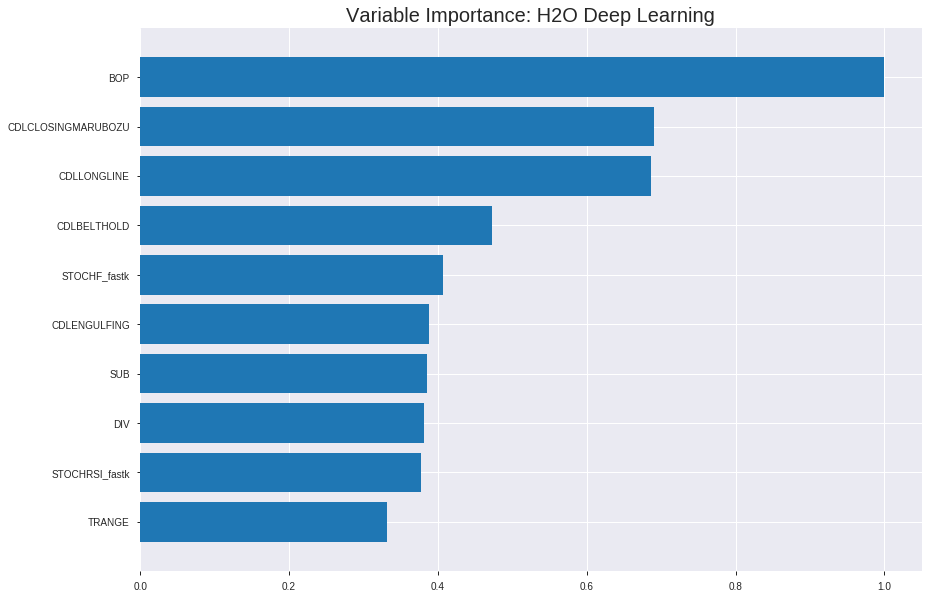

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_131255_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1931173109088587
RMSE: 0.4394511473518515
LogLoss: 0.5650051832731592
Mean Per-Class Error: 0.2838583570016955
AUC: 0.7865750440069547
pr_auc: 0.767703013560899
Gini: 0.5731500880139093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3581102700146326: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      514  370   0.4186   (370.0/884.0)
1      125  713   0.1492   (125.0/838.0)
Total  639  1083  0.2875   (495.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35811      0.742322  247
max f2                       0.144455     0.847422  334
max f0point5                 0.412289     0.696792  220
max accuracy                 0.408883     0.712544  222
max precision                0.998354     1         0
max recall                   0.0136852    1         391
max specificity              0.998354     1         0
max absolute_mcc             0.35811      0.447252  247
max min_per_class_accuracy   0.441865     0.696897  203
max mean_per_class_accuracy  0.35811      0.716142  247

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 41.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.949942           2.05489   2.05489            1                0.978839  1                           0.978839            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.895879           2.05489   2.05489            1                0.925415  1                           0.95289             0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.859395           2.05489   2.05489            1                0.875343  1                           0.927538            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.824806           1.81314   1.99533            0.882353         0.84275   0.971014                    0.906648            0.0178998       0.0799523                  81.3141   99.533
    5        0.0505226                   0.796679           1.71241   1.9368             0.833333         0.811398  0.942529                    0.886941            0.0178998       0.097852                   71.2411   93.6795
    6        0.100465                    0.682817           1.69648   1.81733            0.825581         0.731038  0.884393                    0.80944             0.0847255       0.182578                   69.6481   81.7333
    7        0.150407                    0.634666           1.64869   1.76134            0.802326         0.657704  0.857143                    0.759057            0.0823389       0.264916                   64.8693   76.1337
    8        0.200348                    0.598511           1.52922   1.70348            0.744186         0.616323  0.828986                    0.723477            0.0763723       0.341289                   52.9222   70.3476
    9        0.300232                    0.541529           1.38586   1.59781            0.674419         0.571042  0.777563                    0.672763            0.138425        0.479714                   38.5858   59.7808
    10       0.400116                    0.492814           1.07523   1.46735            0.523256         0.517868  0.714078                    0.634096            0.107399        0.587112                   7.52345   46.7354
    11       0.5                         0.437419           1.17081   1.40811            0.569767         0.466293  0.68525                     0.600574            0.116945        0.704057                   17.0811   40.8115
    12       0.599884                    0.376829           1.11108   1.35866            0.540698         0.408957  0.661181                    0.568669            0.110979        0.815036                   11.1076   35.8656
    13       0.699768                    0.299017           0.848241  1.2858             0.412791         0.338832  0.625726                    0.535862            0.0847255       0.899761                   -15.1759  28.58
    14       0.799652                    0.188387           0.513723  1.18936            0.25             0.244058  0.578794                    0.499413            0.0513126       0.951074                   -48.6277  18.936
    15       0.899535                    0.0716555          0.358412  1.09709            0.174419         0.130118  0.533893                    0.458407            0.0357995       0.986874                   -64.1588  9.70924
    16       1                           2.00835e-05        0.130658  1                  0.0635838        0.026762  0.486643                    0.415042            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20970560476754296
RMSE: 0.4579362453088235
LogLoss: 0.6080086439317852
Mean Per-Class Error: 0.31306276483050843
AUC: 0.7460027145127118
pr_auc: 0.7553786156952531
Gini: 0.49200542902542366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4130143365444632: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   148  0.6271   (148.0/236.0)
1      26   230  0.1016   (26.0/256.0)
Total  114  378  0.3537   (174.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413014     0.725552  290
max f2                       0.222902     0.850777  365
max f0point5                 0.563614     0.708333  157
max accuracy                 0.521254     0.689024  203
max precision                0.937664     1         0
max recall                   0.0337619    1         392
max specificity              0.937664     1         0
max absolute_mcc             0.563614     0.377799  157
max min_per_class_accuracy   0.540298     0.683594  183
max mean_per_class_accuracy  0.521254     0.686937  203

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 50.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.808473           1.92187   1.92187            1                0.877645  1                           0.877645            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.778991           1.92187   1.92187            1                0.794852  1                           0.836249            0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.744967           1.5375    1.79375            0.8              0.759618  0.933333                    0.810705            0.015625        0.0546875                  53.75     79.375
    4        0.0406504                   0.714824           1.5375    1.72969            0.8              0.730104  0.9                         0.790555            0.015625        0.0703125                  53.75     72.9687
    5        0.050813                    0.703901           1.5375    1.69125            0.8              0.709693  0.88                        0.774382            0.015625        0.0859375                  53.75     69.125
    6        0.101626                    0.661873           1.61437   1.65281            0.84             0.683175  0.86                        0.728779            0.0820312       0.167969                   61.4375   65.2812
    7        0.150407                    0.640355           1.76172   1.68813            0.916667         0.649354  0.878378                    0.703019            0.0859375       0.253906                   76.1719   68.8133
    8        0.20122                     0.625716           1.23      1.57244            0.64             0.633539  0.818182                    0.685474            0.0625          0.316406                   23        57.2443
    9        0.300813                    0.594754           1.29432   1.48036            0.673469         0.609624  0.77027                     0.660361            0.128906        0.445312                   29.4324   48.0363
    10       0.400407                    0.567027           1.2551    1.42433            0.653061         0.579424  0.741117                    0.64023             0.125           0.570312                   25.5102   42.4334
    11       0.5                         0.541203           1.01977   1.34375            0.530612         0.553358  0.699187                    0.622926            0.101562        0.671875                   1.97704   34.375
    12       0.599593                    0.505264           0.941327  1.27691            0.489796         0.524262  0.664407                    0.606538            0.09375         0.765625                   -5.86735  27.6907
    13       0.699187                    0.453883           0.705995  1.19559            0.367347         0.478854  0.622093                    0.58835             0.0703125       0.835938                   -29.4005  19.5585
    14       0.79878                     0.388814           0.823661  1.14921            0.428571         0.424651  0.597964                    0.56794             0.0820312       0.917969                   -17.6339  14.9213
    15       0.898374                    0.279445           0.549107  1.08269            0.285714         0.334033  0.563348                    0.542009            0.0546875       0.972656                   -45.0893  8.26852
    16       1                           0.000359065        0.269062  1                  0.14             0.151359  0.520325                    0.502309            


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:31:55  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:31:57  10 min 31.408 sec  312 obs/sec       0.410569  1             707        0.619025         2.1145              -0.533861      0.627865        0.51233            1.48409          0.463415                         0.684731           3.60141               -0.87853         0.584257          0.60315              1.5375             0.447154
    2019-08-26 13:32:24  10 min 58.850 sec  425 obs/sec       6.68118   17            11505      0.4786           0.649067            0.0831151      0.676801        0.658015           1.82657          0.423345                         0.494169           0.681468              0.0215726        0.624843          0.613336             1.15312            0.412602
    2019-08-26 13:32:52  11 min 26.870 sec  466 obs/sec       14.162    36            24387      0.474528         0.639822            0.0986504      0.733115        0.703275           1.82657          0.357724                         0.489159           0.671286              0.0413111        0.710813          0.714231             1.92187            0.343496
    2019-08-26 13:33:20  11 min 54.847 sec  481 obs/sec       21.6974   55            37363      0.453408         0.592477            0.177099       0.763251        0.739481           2.05489          0.318815                         0.478602           0.649127              0.0822457        0.720116          0.726702             1.92187            0.365854
    2019-08-26 13:33:49  12 min 23.164 sec  487 obs/sec       29.2108   74            50301      0.448941         0.582529            0.193233       0.774369        0.746385           2.05489          0.30662                          0.47907            0.647823              0.0804466        0.720976          0.728765             1.92187            0.363821
    2019-08-26 13:34:17  12 min 51.447 sec  491 obs/sec       36.7695   93            63317      0.439451         0.565005            0.226979       0.786575        0.767703           2.05489          0.287456                         0.457936           0.608009              0.159789         0.746003          0.755379             1.92187            0.353659
    2019-08-26 13:34:45  13 min 19.320 sec  494 obs/sec       44.2468   112           76193      0.43413          0.551255            0.245588       0.794039        0.773073           2.05489          0.308362                         0.462804           0.616598              0.141831         0.736485          0.753301             1.92187            0.378049
    2019-08-26 13:35:13  13 min 47.289 sec  497 obs/sec       51.7451   131           89105      0.428787         0.541717            0.264042       0.80563         0.785149           2.05489          0.285714                         0.46153            0.614313              0.146549         0.739026          0.749469             1.92187            0.355691
    2019-08-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.007456651174057346
CDLCLOSINGMARUBOZU       0.6905888319015503     0.6905888319015503   0.005149480024189586
CDLLONGLINE              0.6861208081245422     0.6861208081245422   0.005116163529447043
CDLBELTHOLD              0.4731156527996063     0.4731156527996063   0.003527858387913092
STOCHF_fastk             0.40638625621795654    0.40638625621795654  0.003030280554548395
---                      ---                    ---                  ---
BBANDS_upperband_14_4_2  0.10257235169410706    0.10257235169410706  0.0007648462466856863
BBANDS_lowerband_20_7_2  0.10228084027767181    0.10228084027767181  0.0007626725477400734
T3_8_7                   0.1008024662733078     0.1008024662733078   0.0007516488284847366
CDLTASUKIGAP             0.09492199122905731    0.09492199122905731  0.0007078001773420113
CDLHIKKAKEMOD            0.09351964294910431    0.09351964294910431  0.0006973433553938625


See the whole table with table.as_data_frame()


('accuracy', 0.6963562753036437)

('F1', 0.6468085106382978)

('auc', 0.7328767123287672)

('logloss', 0.6232869357571224)

('mean_per_class_error', 0.32239251322392515)

('rmse', 0.46517688648976335)

('mse', 0.2163895357243102)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


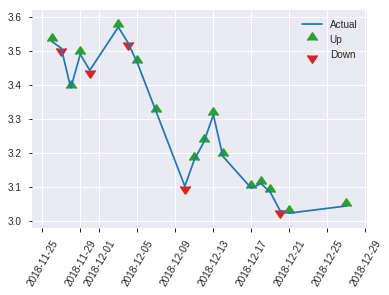


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2163895357243102
RMSE: 0.46517688648976335
LogLoss: 0.6232869357571224
Mean Per-Class Error: 0.32239251322392515
AUC: 0.7328767123287672
pr_auc: 0.6289896371641983
Gini: 0.46575342465753433
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5188519011728269: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   58   0.3973   (58.0/146.0)
1      25   76   0.2475   (25.0/101.0)
Total  113  134  0.336    (83.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.518852     0.646809  133
max f2                       0.10596      0.813205  216
max f0point5                 0.620095     0.62963   75
max accuracy                 0.620095     0.696356  75
max precision                0.992386     1         0
max recall                   0.10596      1         216
max specificity              0.992386     1         0
max absolute_mcc             0.579593     0.358068  94
max min_per_class_accuracy   0.549488     0.653465  115
max mean_per_class_accuracy  0.518852     0.677607  133

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.988005           2.44554   2.44554            1                0.990951   1                           0.990951            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.976482           2.44554   2.44554            1                0.985903   1                           0.988932            0.019802        0.049505                   144.554   144.554
    3        0.0323887                   0.962097           1.63036   2.13985            0.666667         0.967941   0.875                       0.98106             0.019802        0.0693069                  63.0363   113.985
    4        0.0404858                   0.932983           0         1.71188            0                0.952616   0.7                         0.975371            0               0.0693069                  -100      71.1881
    5        0.0526316                   0.92165            1.63036   1.69307            0.666667         0.928422   0.692308                    0.964537            0.019802        0.0891089                  63.0363   69.3069
    6        0.101215                    0.843039           1.83416   1.76079            0.75             0.878204   0.72                        0.923097            0.0891089       0.178218                   83.4158   76.0792
    7        0.149798                    0.808882           1.63036   1.71849            0.666667         0.828038   0.702703                    0.892267            0.0792079       0.257426                   63.0363   71.8491
    8        0.202429                    0.692459           1.50495   1.66297            0.615385         0.724515   0.68                        0.848651            0.0792079       0.336634                   50.495    66.297
    9        0.299595                    0.627141           1.52847   1.61935            0.625            0.660041   0.662162                    0.787481            0.148515        0.485149                   52.8465   61.9347
    10       0.40081                     0.575892           1.07604   1.48215            0.44             0.599027   0.606061                    0.739891            0.108911        0.594059                   7.60396   48.2148
    11       0.502024                    0.533394           0.880396  1.36083            0.36             0.555741   0.556452                    0.702764            0.0891089       0.683168                   -11.9604  36.0827
    12       0.59919                     0.493127           0.917079  1.28887            0.375            0.514556   0.527027                    0.672244            0.0891089       0.772277                   -8.29208  28.8868
    13       0.700405                    0.407421           0.880396  1.22984            0.36             0.455024   0.50289                     0.640854            0.0891089       0.861386                   -11.9604  22.984
    14       0.797571                    0.269571           0.815182  1.17932            0.333333         0.352679   0.482234                    0.605746            0.0792079       0.940594                   -18.4818  17.9324
    15       0.898785                    0.0788498          0.586931  1.11261            0.24             0.171951   0.454955                    0.556895            0.0594059       1                          -41.3069  11.2613
    16       1                           0.000156161        0         1                  0                0.0233277  0.408907                    0

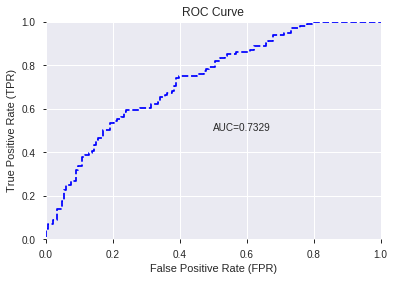

This function is available for GLM models only


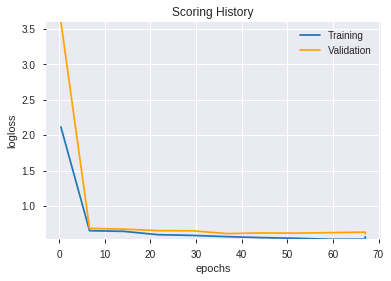

--2019-08-26 13:51:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M   102MB/s    in 3.7s    

2019-08-26 13:51:58 (95.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_131255_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_131255_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_135207_model_5  0.736878  0.649618              0.321206  0.477309  0.227824
1  DeepLearning_grid_1_AutoML_20190826_135207_model_8  0.736267  0.595579              0.323851  0.455534  0.207512
2  DeepLearning_grid_1_AutoML_20190826_135207_model_3  0.734165  0.701380              0.347823  0.486446  0.236629
3  DeepLearning_grid_1_AutoML_20190826_135207_model_6  0.733419  0.619024              0.350095  0.466801  0.217903
4  DeepLearning_grid_1_AutoML_20190826_135207_model_9  0.726977  0.619714              0.346670  0.465876  0.217041
5  DeepLearning_grid_1_AutoML_20190826_135207_model_7  0.726570  0.969949              0.318595  0.546028  0.298147
6  DeepLearning_grid_1_AutoML_20190826_135207_model_2  0.706225  0.791701              0.354299  0.512944  0.263112
7  DeepLearning_grid_1_AutoML_20190826_135207_model_4  0.697409  0.981734              0.355079  0.539597  0.291164
8               DeepLearning_1_AutoML_20190826_135207  0.691510  0.697112              0.352028  0.488457  0.238590
9  DeepLearning_grid_1_AutoML_20190826_135207_model_1  0.688051  1.043289              0.373728  0.555254  0.308307

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.036361
1     CDLCLOSINGMARUBOZU             0.837409           0.837409    0.030449
2           CDLSHORTLINE             0.794279           0.794279    0.028880
3            CDLLONGLINE             0.633692           0.633692    0.023041
4                    SIN             0.632903           0.632903    0.023013
5                    DIV             0.623976           0.623976    0.022688
6                    day             0.617202           0.617202    0.022442
7                    SUB             0.616660           0.616660    0.022422
8           CDLENGULFING             0.616596           0.616596    0.022420
9                 TRANGE             0.582895           0.582895    0.021194
10                  DX_8             0.582452           0.582452    0.021178
11               quarter             0.580877           0.580877    0.021121
12        CDLSPINNINGTOP             0.574026           0.574026    0.020872
13             CORREL_12             0.573210           0.573210    0.020842
14           aroondown_8             0.572258           0.572258    0.020808
15          aroondown_14             0.570178           0.570178    0.020732
16                ADX_24             0.562359           0.562359    0.020448
17              CORREL_8             0.560556           0.560556    0.020382
18                 month             0.549493           0.549493    0.019980
19             CDLTAKURI             0.543200           0.543200    0.019751
20             CORREL_30             0.540582           0.540582    0.019656
21           STOCH_slowd             0.538649           0.538649    0.019586
22               CDLDOJI             0.536555           0.536555    0.019509
23         days_in_month             0.534434           0.534434    0.019432
24      CDLDRAGONFLYDOJI             0.529812           0.529812    0.019264
25             CORREL_24             0.525039           0.525039    0.019091
26            AROONOSC_8             0.523180           0.523180    0.019023
27                 DX_12             0.519450           0.519450    0.018888
28             CDLHAMMER             0.518040           0.518040    0.018836
29             CORREL_14             0.516953           0.516953    0.018797
30          STOCHF_fastk             0.512285           0.512285    0.018627
31        STOCHRSI_fastk             0.509277           0.509277    0.018518
32         CDLHANGINGMAN             0.508844           0.508844    0.018502
33  HT_PHASOR_quadrature             0.506692           0.506692    0.018424
34                 DX_30             0.505523           0.505523    0.018381
35                 ADOSC             0.492377           0.492377    0.017903
36              WILLR_30             0.491826           0.491826    0.017883
37             PLUS_DM_8             0.488613           0.488613    0.017766
38                ULTOSC             0.486983           0.486983    0.017707
39              WILLR_12             0.483183           0.483183    0.017569
40              WILLR_20             0.479663           0.479663    0.017441
41              WILLR_24             0.476094           0.476094    0.017311
42           CDLBELTHOLD             0.474348           0.474348    0.017248
43       CDLSHOOTINGSTAR             0.473888           0.473888    0.017231
44                 DX_24             0.468158           0.468158    0.017023
45               WILLR_8             0.466030           0.466030    0.016945
46           CDLMARUBOZU             0.464378           0.464378    0.016885
47              WILLR_14             0.455015           0.455015    0.016545
48                 DX_20             0.449454           0.449454    0.016342
49        CDLMATCHINGLOW             0.402770           0.402770    0.014645

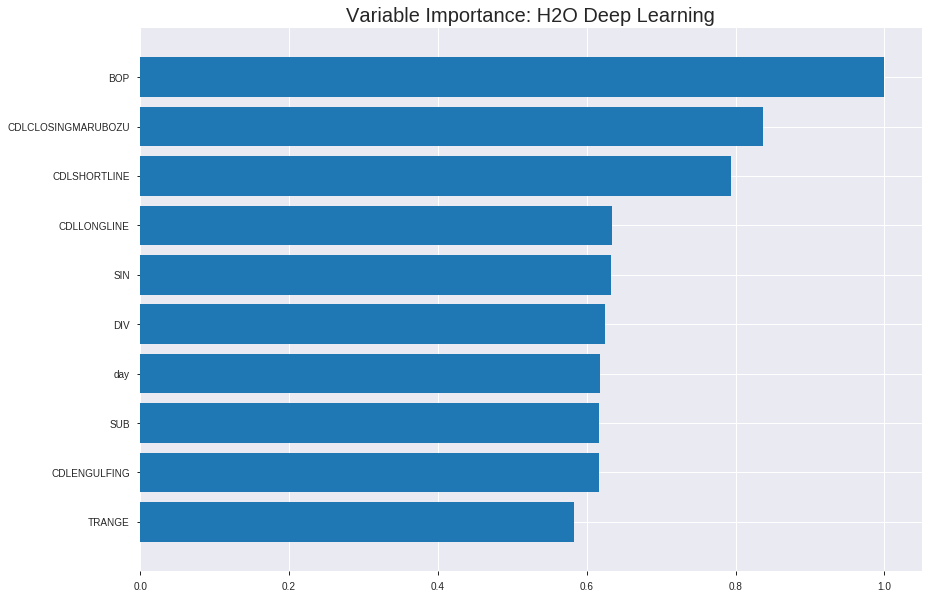

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_135207_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17768055553305115
RMSE: 0.42152171418925877
LogLoss: 0.5209643134332214
Mean Per-Class Error: 0.2613135671011566
AUC: 0.8205035961511464
pr_auc: 0.8084786697810693
Gini: 0.6410071923022929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.429310407285608: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      417  467   0.5283   (467.0/884.0)
1      50   788   0.0597   (50.0/838.0)
Total  467  1255  0.3002   (517.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42931      0.752986  258
max f2                       0.274251     0.862762  302
max f0point5                 0.681438     0.736515  138
max accuracy                 0.577772     0.736934  194
max precision                0.994238     1         0
max recall                   0.0203722    1         385
max specificity              0.994238     1         0
max absolute_mcc             0.577772     0.480587  194
max min_per_class_accuracy   0.611863     0.727924  174
max mean_per_class_accuracy  0.577772     0.738686  194

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 54.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.95863            2.05489   2.05489            1                0.972519   1                           0.972519            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.941698           2.05489   2.05489            1                0.948084   1                           0.96065             0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.924415           2.05489   2.05489            1                0.931851   1                           0.951235            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.913046           1.81314   1.99533            0.882353         0.917593   0.971014                    0.942946            0.0178998       0.0799523                  81.3141   99.533
    5        0.0505226                   0.90249            2.05489   2.00765            1                0.906625   0.977011                    0.935432            0.0214797       0.101432                   105.489   100.765
    6        0.100465                    0.852219           1.79206   1.90048            0.872093         0.877587   0.924855                    0.906676            0.0894988       0.190931                   79.2058   90.0479
    7        0.150407                    0.8102             1.81595   1.87241            0.883721         0.83118    0.911197                    0.881608            0.0906921       0.281623                   81.5952   87.2412
    8        0.200348                    0.772256           1.43365   1.76304            0.697674         0.790539   0.857971                    0.858907            0.071599        0.353222                   43.3646   76.3038
    9        0.300232                    0.717192           1.49338   1.67333            0.726744         0.744625   0.814313                    0.820887            0.149165        0.502387                   49.3381   67.3326
    10       0.400116                    0.660757           1.20665   1.55683            0.587209         0.688915   0.75762                     0.787941            0.120525        0.622912                   20.6652   55.6827
    11       0.5                         0.607186           1.14692   1.47494            0.55814          0.632782   0.71777                     0.756946            0.114558        0.73747                    14.6917   47.494
    12       0.599884                    0.549959           0.943817  1.38651            0.459302         0.58055    0.674734                    0.727575            0.0942721       0.831742                   -5.6183   38.6505
    13       0.699768                    0.469118           0.800452  1.30285            0.389535         0.515774   0.634025                    0.697343            0.0799523       0.911695                   -19.9548  30.2853
    14       0.799652                    0.271582           0.621247  1.21771            0.302326         0.381382   0.592593                    0.657876            0.0620525       0.973747                   -37.8753  21.7714
    15       0.899535                    0.0596669          0.238941  1.10903            0.116279         0.161301   0.539703                    0.602737            0.0238663       0.997613                   -76.1059  10.9032
    16       1                           0.000304085        0.023756  1                  0.0115607        0.0252893  0.486643                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22021089766105423
RMSE: 0.46926633979122584
LogLoss: 0.629977471482969
Mean Per-Class Error: 0.29770259533898313
AUC: 0.7426923331567796
pr_auc: 0.7535829643365517
Gini: 0.48538466631355925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49736414430292797: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      92   144  0.6102   (144.0/236.0)
1      27   229  0.1055   (27.0/256.0)
Total  119  373  0.3476   (171.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497364     0.72814   289
max f2                       0.0617293    0.853985  378
max f0point5                 0.676477     0.718439  182
max accuracy                 0.676477     0.70122   182
max precision                0.979421     1         0
max recall                   0.0385716    1         384
max specificity              0.979421     1         0
max absolute_mcc             0.676477     0.404531  182
max min_per_class_accuracy   0.667695     0.6875    190
max mean_per_class_accuracy  0.676477     0.702297  182

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 60.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.960582           1.92187   1.92187            1                0.973999   1                           0.973999            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.941101           1.92187   1.92187            1                0.950461   1                           0.96223             0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.930812           1.92187   1.92187            1                0.935041   1                           0.953167            0.0195312       0.0585938                  92.1875   92.1875
    4        0.0406504                   0.922333           1.5375    1.82578            0.8              0.928123   0.95                        0.946906            0.015625        0.0742188                  53.75     82.5781
    5        0.050813                    0.917669           1.5375    1.76812            0.8              0.918311   0.92                        0.941187            0.015625        0.0898438                  53.75     76.8125
    6        0.101626                    0.874037           1.61437   1.69125            0.84             0.898147   0.88                        0.919667            0.0820312       0.171875                   61.4375   69.125
    7        0.150407                    0.828819           1.44141   1.61022            0.75             0.852546   0.837838                    0.897898            0.0703125       0.242188                   44.1406   61.022
    8        0.20122                     0.797861           1.38375   1.55303            0.72             0.814004   0.808081                    0.876713            0.0703125       0.3125                     38.375    55.303
    9        0.300813                    0.743573           1.29432   1.46738            0.673469         0.77017    0.763514                    0.841438            0.128906        0.441406                   29.4324   46.7378
    10       0.400407                    0.709408           1.2551    1.41458            0.653061         0.727445   0.736041                    0.813085            0.125           0.566406                   25.5102   41.4578
    11       0.5                         0.66906            1.17666   1.36719            0.612245         0.68948    0.711382                    0.788464            0.117188        0.683594                   17.6658   36.7188
    12       0.599593                    0.603009           0.784439  1.27039            0.408163         0.638469   0.661017                    0.76355             0.078125        0.761719                   -21.5561  27.0392
    13       0.699187                    0.544963           0.745217  1.19559            0.387755         0.574369   0.622093                    0.736602            0.0742188       0.835938                   -25.4783  19.5585
    14       0.79878                     0.455824           0.705995  1.13454            0.367347         0.503322   0.590331                    0.707517            0.0703125       0.90625                    -29.4005  13.4542
    15       0.898374                    0.182004           0.588329  1.07399            0.306122         0.331311   0.558824                    0.665811            0.0585938       0.964844                   -41.1671  7.3989
    16       1                           0.000309329        0.345937  1                  0.18             0.0713077  0.520325                    0.6


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:55:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:55:33  1 min 26.107 sec  1262 obs/sec      1.28688   1             2216       0.443148         0.574536            0.213917       0.784773        0.759289           1.94073          0.307782                         0.475958           0.641637              0.0923567        0.719967          0.723579             1.5375             0.400407
    2019-08-26 13:55:40  1 min 33.813 sec  2028 obs/sec      10.3101   8             17754      0.421522         0.520964            0.28877        0.820504        0.808479           2.05489          0.300232                         0.469266           0.629977              0.117698         0.742692          0.753583             1.92187            0.347561
    2019-08-26 13:55:48  1 min 41.541 sec  2250 obs/sec      20.6173   16            35503      0.401728         0.479734            0.353996       0.854305        0.845697           2.05489          0.264808                         0.473627           0.648793              0.101225         0.705086          0.708547             1.92187            0.355691
    2019-08-26 13:55:56  1 min 49.148 sec  2350 obs/sec      30.9344   24            53269      0.379308         0.43386             0.42409        0.877377        0.869152           2.05489          0.230546                         0.468828           0.665284              0.119344         0.724444          0.71491              1.5375             0.410569
    2019-08-26 13:56:03  1 min 56.562 sec  2416 obs/sec      41.1754   32            70904      0.361979         0.400884            0.475511       0.907915        0.885399           2.05489          0.19338                          0.478476           0.676869              0.0827263        0.701834          0.701885             1.92187            0.380081
    2019-08-26 13:56:11  2 min  4.645 sec  2474 obs/sec      52.7085   41            90764      0.330995         0.341881            0.561457       0.935686        0.918413           2.05489          0.153891                         0.48335            0.722931              0.0639435        0.690943          0.683769             1.5375             0.408537
    2019-08-26 13:56:12  2 min  5.384 sec  2472 obs/sec      52.7085   41            90764      0.421522         0.520964            0.28877        0.820504        0.808479           2.05489          0.300232                         0.469266           0.629977              0.117698         0.742692          0.753583             1.92187            0.347561

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03636057150484099
CDLCLOSINGMARUBOZU  0.8374091982841492     0.8374091982841492   0.03044867703302237
CDLSHORTLINE        0.794278621673584      0.794278621673584    0.028880424618128894
CDLLONGLINE         0.6336923241615295     0.6336923241615295   0.023041415064744167
SIN                 0.6329028606414795     0.6329028606414795   0.023012709719972924
---                 ---                    ---                  ---
WILLR_8             0.4660295844078064     0.4660295844078064   0.016945102027231373
CDLMARUBOZU         0.4643784761428833     0.4643784761428833   0.0168850667871024
WILLR_14            0.45501530170440674    0.45501530170440674  0.016544616413419876
DX_20               0.4494544267654419     0.4494544267654419   0.016342419822572167
CDLMATCHINGLOW      0.4027702808380127     0.4027702808380127   0.014644957596435446


See the whole table with table.as_data_frame()


('accuracy', 0.6882591093117408)

('F1', 0.6666666666666667)

('auc', 0.736877797368778)

('logloss', 0.6496181201642975)

('mean_per_class_error', 0.31133866811338673)

('rmse', 0.4773090966330579)

('mse', 0.2278239737286658)

deeplearning prediction progress: |███████████████████████████████████████| 100%


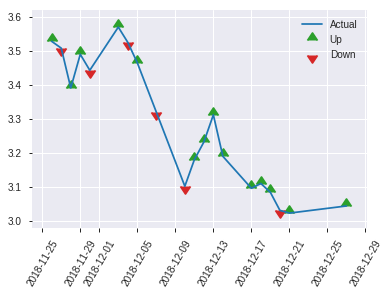


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2278239737286658
RMSE: 0.4773090966330579
LogLoss: 0.6496181201642975
Mean Per-Class Error: 0.31133866811338673
AUC: 0.736877797368778
pr_auc: 0.6198433844155223
Gini: 0.473755594737556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5361491804829032: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   75   0.5137   (75.0/146.0)
1      13   88   0.1287   (13.0/101.0)
Total  84   163  0.3563   (88.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536149     0.666667  162
max f2                       0.290877     0.811258  199
max f0point5                 0.735763     0.616438  65
max accuracy                 0.735763     0.688259  65
max precision                0.986726     1         0
max recall                   0.0166806    1         240
max specificity              0.986726     1         0
max absolute_mcc             0.57297      0.375721  142
max min_per_class_accuracy   0.643474     0.657534  116
max mean_per_class_accuracy  0.57297      0.688661  142

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 55.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.961128           2.44554    2.44554            1                0.981279   1                           0.981279            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.938039           1.22277    1.95644            0.5              0.944918   0.8                         0.966735            0.00990099      0.039604                   22.2772   95.6436
    3        0.0323887                   0.934684           1.63036    1.83416            0.666667         0.936963   0.75                        0.95557             0.019802        0.0594059                  63.0363   83.4158
    4        0.0404858                   0.91216            2.44554    1.95644            1                0.931919   0.8                         0.95084             0.019802        0.0792079                  144.554   95.6436
    5        0.0526316                   0.897393           0.815182   1.69307            0.333333         0.903583   0.692308                    0.939935            0.00990099      0.0891089                  -18.4818  69.3069
    6        0.101215                    0.84976            1.63036    1.66297            0.666667         0.880023   0.68                        0.911177            0.0792079       0.168317                   63.0363   66.297
    7        0.149798                    0.80405            1.63036    1.65239            0.666667         0.82262    0.675676                    0.882456            0.0792079       0.247525                   63.0363   65.2395
    8        0.202429                    0.758902           1.69307    1.66297            0.692308         0.784855   0.68                        0.85708             0.0891089       0.336634                   69.3069   66.297
    9        0.299595                    0.725408           1.32467    1.55325            0.541667         0.740826   0.635135                    0.819376            0.128713        0.465347                   32.467    55.3251
    10       0.40081                     0.683809           0.978218   1.40804            0.4              0.705251   0.575758                    0.790556            0.0990099       0.564356                   -2.17822  40.8041
    11       0.502024                    0.619057           1.3695     1.40027            0.56             0.656003   0.572581                    0.763429            0.138614        0.70297                    36.9505   40.0271
    12       0.59919                     0.563166           1.12087    1.35496            0.458333         0.590296   0.554054                    0.735353            0.108911        0.811881                   12.0875   35.4964
    13       0.700405                    0.514526           0.880396   1.28638            0.36             0.539584   0.526012                    0.707063            0.0891089       0.90099                    -11.9604  28.6385
    14       0.797571                    0.328712           0.611386   1.20415            0.25             0.432467   0.492386                    0.67361             0.0594059       0.960396                   -38.8614  20.4151
    15       0.898785                    0.067756           0.293465   1.1016             0.12             0.187472   0.45045                     0.618864            0.029703        0.990099                   -70.6535  10.1597
    16       1                           0.000335811        0.0978218  1                  0.04             0.0340219  0.408907   

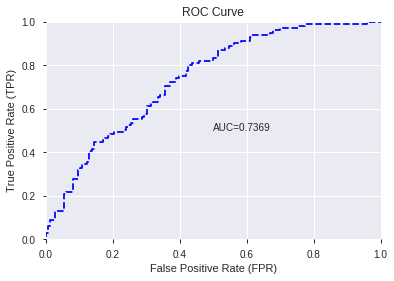

This function is available for GLM models only


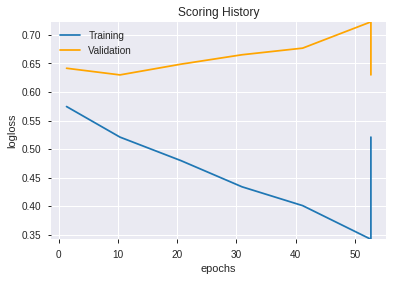

--2019-08-26 14:01:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_135207_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_135207_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'SIN',
 'DIV',
 'day',
 'SUB',
 'CDLENGULFING',
 'TRANGE',
 'DX_8',
 'quarter',
 'CDLSPINNINGTOP',
 'CORREL_12',
 'aroondown_8',
 'aroondown_14',
 'ADX_24',
 'CORREL_8',
 'month',
 'CDLTAKURI',
 'CORREL_30',
 'STOCH_slowd',
 'CDLDOJI',
 'days_in_month',
 'CDLDRAGONFLYDOJI',
 'CORREL_24',
 'AROONOSC_8',
 'DX_12',
 'CDLHAMMER',
 'CORREL_14',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'HT_PHASOR_quadrature',
 'DX_30',
 'ADOSC',
 'WILLR_30',
 'PLUS_DM_8',
 'ULTOSC',
 'WILLR_12',
 'WILLR_20',
 'WILLR_24',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR',
 'DX_24',
 'WILLR_8',
 'CDLMARUBOZU',
 'WILLR_14',
 'DX_20',
 'CDLMATCHINGLOW']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_140152_model_1  0.727248  0.606957              0.343246  0.458535  0.210254

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.407219           1.000000    0.133901
1     CDLCLOSINGMARUBOZU             0.246288           0.604806    0.080984
2            CDLLONGLINE             0.163202           0.400772    0.053664
3           CDLENGULFING             0.152971           0.375649    0.050300
4                    SUB             0.126650           0.311013    0.041645
5            STOCH_slowd             0.121647           0.298727    0.040000
6        CDLSHOOTINGSTAR             0.103875           0.255085    0.034156
7           STOCHF_fastk             0.102305           0.251229    0.033640
8                 TRANGE             0.098891           0.242845    0.032517
9           CDLSHORTLINE             0.092053           0.226052    0.030269
10             CDLHAMMER             0.089279           0.219242    0.029357
11              WILLR_12             0.078296           0.192270    0.025745
12         CDLHANGINGMAN             0.075450           0.185282    0.024809
13                ULTOSC             0.074871           0.183860    0.024619
14             CORREL_24             0.071118           0.174644    0.023385
15             PLUS_DM_8             0.063894           0.156905    0.021010
16           aroondown_8             0.060150           0.147710    0.019778
17                   DIV             0.058784           0.144355    0.019329
18          aroondown_14             0.057573           0.141382    0.018931
19                ADX_24             0.056486           0.138711    0.018574
20                  DX_8             0.056385           0.138465    0.018541
21              WILLR_14             0.055610           0.136561    0.018286
22               WILLR_8             0.052481           0.128878    0.017257
23        CDLSPINNINGTOP             0.046797           0.114918    0.015388
24        STOCHRSI_fastk             0.046203           0.113460    0.015192
25              WILLR_20             0.041830           0.102721    0.013754
26      CDLDRAGONFLYDOJI             0.038163           0.093716    0.012549
27             CDLTAKURI             0.038091           0.093540    0.012525
28        CDLMATCHINGLOW             0.036788           0.090340    0.012097
29            AROONOSC_8             0.035091           0.086172    0.011538
30         days_in_month             0.033744           0.082865    0.011096
31           CDLBELTHOLD             0.028634           0.070315    0.009415
32              CORREL_8             0.024948           0.061265    0.008203
33                   SIN             0.024105           0.059194    0.007926
34           CDLMARUBOZU             0.023375           0.057401    0.007686
35               quarter             0.022299           0.054760    0.007332
36             CORREL_12             0.020921           0.051376    0.006879
37             CORREL_30             0.016873           0.041435    0.005548
38                 ADOSC             0.016739           0.041107    0.005504
39                   day             0.014146           0.034738    0.004651
40                 DX_12             0.013139           0.032265    0.004320
41                 DX_30             0.008631           0.021195    0.002838
42              WILLR_24             0.008046           0.019758    0.002646
43                 DX_20             0.007588           0.018635    0.002495
44                 DX_24             0.005864           0.014400    0.001928
45  HT_PHASOR_quadrature             0.005551           0.013632    0.001825
46              WILLR_30             0.005351           0.013140    0.001759
47               CDLDOJI             0.005222           0.012823    0.001717
48                 month             0.004709           0.011564    0.001548
49             CORREL_14             0.002869           0.007046    0.000943

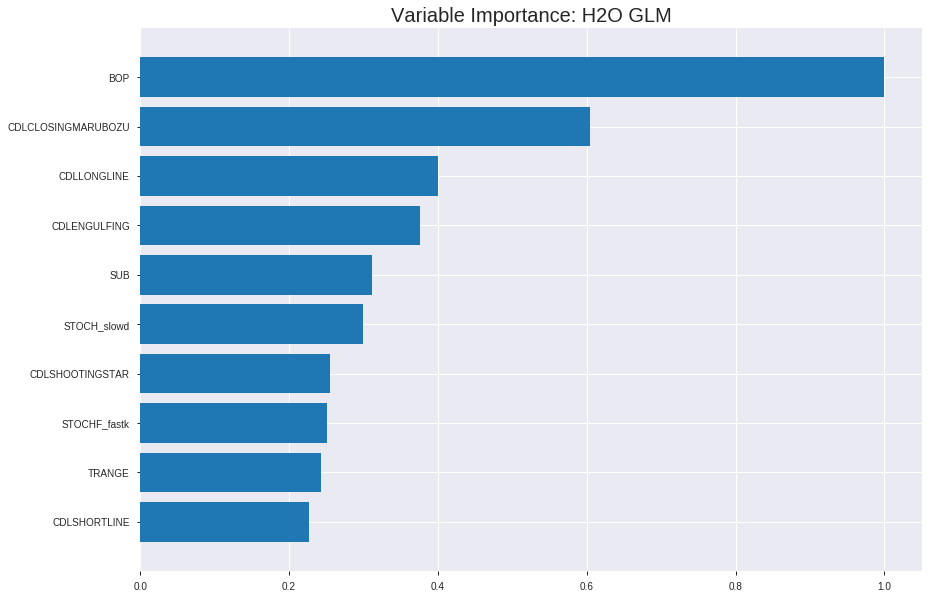

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_140152_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1877326552335382
RMSE: 0.4332812657310932
LogLoss: 0.5558652856021695
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2385.969939946232
Residual deviance: 1914.4000436138717
AIC: 2016.4000436138717
AUC: 0.7901185487964233
pr_auc: 0.7583567977644987
Gini: 0.5802370975928466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3766237148978952: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      469  415   0.4695   (415.0/884.0)
1      112  726   0.1337   (112.0/838.0)
Total  581  1141  0.306    (527.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376624     0.733704  253
max f2                       0.246918     0.850042  319
max f0point5                 0.578309     0.722417  149
max accuracy                 0.468293     0.718351  204
max precision                0.938832     1         0
max recall                   0.0749339    1         392
max specificity              0.938832     1         0
max absolute_mcc             0.468293     0.438683  204
max min_per_class_accuracy   0.488931     0.71599   194
max mean_per_class_accuracy  0.468293     0.719159  204

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.890065           1.94073   1.94073            0.944444         0.907064  0.944444                    0.907064            0.0202864       0.0202864                  94.0732   94.0732
    2        0.0203252                   0.876749           1.81314   1.87876            0.882353         0.882803  0.914286                    0.89528             0.0178998       0.0381862                  81.3141   87.8759
    3        0.0301974                   0.859598           1.93402   1.89682            0.941176         0.867874  0.923077                    0.88632             0.0190931       0.0572792                  93.4017   89.6824
    4        0.0400697                   0.845786           1.45051   1.78686            0.705882         0.85258   0.869565                    0.878008            0.0143198       0.071599                   45.0512   78.6863
    5        0.0505226                   0.833747           1.71241   1.77146            0.833333         0.839475  0.862069                    0.870035            0.0178998       0.0894988                  71.2411   77.1459
    6        0.100465                    0.784762           1.69648   1.73419            0.825581         0.809315  0.843931                    0.839851            0.0847255       0.174224                   69.6481   73.4187
    7        0.150407                    0.747375           1.55312   1.67406            0.755814         0.766353  0.814672                    0.815446            0.0775656       0.25179                    55.3117   67.4063
    8        0.200348                    0.706986           1.67259   1.6737             0.813953         0.72757   0.814493                    0.793541            0.0835322       0.335322                   67.2587   67.3695
    9        0.300232                    0.628807           1.52922   1.62563            0.744186         0.662873  0.791103                    0.750069            0.152745        0.488067                   52.9222   62.5631
    10       0.400116                    0.558954           1.26639   1.53595            0.616279         0.592689  0.74746                     0.710781            0.126492        0.614558                   26.6387   53.595
    11       0.5                         0.483166           1.05134   1.43914            0.511628         0.523964  0.700348                    0.673461            0.105012        0.71957                    5.13404   43.9141
    12       0.599884                    0.41632            0.967711  1.36065            0.47093          0.448933  0.662149                    0.636076            0.0966587       0.816229                   -3.22889  36.0645
    13       0.699768                    0.356923           0.764611  1.27557            0.372093         0.385589  0.620747                    0.600322            0.0763723       0.892601                   -23.5389  27.5568
    14       0.799652                    0.279358           0.573458  1.18787            0.27907          0.320498  0.578068                    0.565369            0.0572792       0.949881                   -42.6542  18.7868
    15       0.899535                    0.16827            0.358412  1.09577            0.174419         0.225195  0.533247                    0.527597            0.0357995       0.98568                    -64.1588  9.57658
    16       1                           0.0355158          0.142536  1                  0.0693642        0.11996   0.486643                    0.486644          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20733419678537413
RMSE: 0.455339649915724
LogLoss: 0.6005709193294988
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 683.4768170160789
Residual deviance: 590.9617846202268
AIC: 692.9617846202268
AUC: 0.7416909427966102
pr_auc: 0.7444321291176677
Gini: 0.4833818855932204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2856975192926213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      66   170  0.7203   (170.0/236.0)
1      15   241  0.0586   (15.0/256.0)
Total  81   411  0.376    (185.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285698     0.722639  325
max f2                       0.139611     0.852197  386
max f0point5                 0.579264     0.722997  174
max accuracy                 0.579264     0.70122   174
max precision                0.934489     1         0
max recall                   0.139611     1         386
max specificity              0.934489     1         0
max absolute_mcc             0.579264     0.408365  174
max min_per_class_accuracy   0.554363     0.690678  194
max mean_per_class_accuracy  0.579264     0.703456  174

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.892715           1.5375    1.5375             0.8              0.914136  0.8                         0.914136            0.015625        0.015625                   53.75     53.75
    2        0.0203252                   0.879227           1.5375    1.5375             0.8              0.886729  0.8                         0.900433            0.015625        0.03125                    53.75     53.75
    3        0.0304878                   0.862543           1.92187   1.66562            1                0.872183  0.866667                    0.891016            0.0195312       0.0507812                  92.1875   66.5625
    4        0.0406504                   0.851615           1.92187   1.72969            1                0.857956  0.9                         0.882751            0.0195312       0.0703125                  92.1875   72.9687
    5        0.050813                    0.846036           1.5375    1.69125            0.8              0.850249  0.88                        0.876251            0.015625        0.0859375                  53.75     69.125
    6        0.101626                    0.786324           1.5375    1.61437            0.8              0.808617  0.84                        0.842434            0.078125        0.164062                   53.75     61.4375
    7        0.150407                    0.756293           1.68164   1.63619            0.875            0.769886  0.851351                    0.818905            0.0820312       0.246094                   68.1641   63.6191
    8        0.20122                     0.717264           1.5375    1.61127            0.8              0.736835  0.838384                    0.79818             0.078125        0.324219                   53.75     61.1269
    9        0.300813                    0.657742           1.37277   1.53231            0.714286         0.681788  0.797297                    0.759645            0.136719        0.460938                   37.2768   53.2306
    10       0.400407                    0.603067           1.13744   1.43409            0.591837         0.631051  0.746193                    0.727659            0.113281        0.574219                   13.7436   43.4089
    11       0.5                         0.556613           1.01977   1.35156            0.530612         0.579011  0.703252                    0.698051            0.101562        0.675781                   1.97704   35.1562
    12       0.599593                    0.478792           0.823661  1.26388            0.428571         0.523596  0.657627                    0.669073            0.0820312       0.757812                   -17.6339  26.3877
    13       0.699187                    0.400793           0.509885  1.15648            0.265306         0.445214  0.601744                    0.637186            0.0507812       0.808594                   -49.0115  15.6477
    14       0.79878                     0.3194             1.01977   1.13943            0.530612         0.363609  0.592875                    0.603076            0.101562        0.910156                   1.97704   13.9432
    15       0.898374                    0.223423           0.588329  1.07834            0.306122         0.270407  0.561086                    0.566197            0.0585938       0.96875                    -41.1671  7.83371
    16       1                           0.0305497          0.3075    1                  0.16             0.156662  0.520325                    0.524577            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:01:53  0.000 sec   2            23        51            1.36267           1.3721
    2019-08-26 14:01:53  0.067 sec   4            14        51            1.35092           1.36333
    2019-08-26 14:01:53  0.131 sec   6            8.7       51            1.33465           1.35116
    2019-08-26 14:01:53  0.213 sec   8            5.4       51            1.31344           1.33526
    2019-08-26 14:01:53  0.272 sec   10           3.4       51            1.28763           1.31586
    2019-08-26 14:01:53  0.326 sec   12           2.1       51            1.25848           1.29391
    2019-08-26 14:01:53  0.355 sec   14           1.3       51            1.22808           1.27108
    2019-08-26 14:01:53  0.380 sec   16           0.8       51            1.19874           1.24943
    2019-08-26 14:01:53  0.400 sec   18           0.5       51            1.17264           1.23095
    2019-08-26 14:01:53  0.421 sec   20           0.31      51            1.15102           1.2169
    2019-08-26 14:01:53  0.438 sec   22           0.19      51            1.13409           1.20762
    2019-08-26 14:01:53  0.479 sec   24           0.12      51            1.12127           1.20264
    2019-08-26 14:01:53  0.504 sec   26           0.074     51            1.11173           1.20114
    2019-08-26 14:01:53  0.528 sec   28           0.046     51            1.10473           1.20227
    2019-08-26 14:01:53  0.550 sec   30           0.029     51            1.09973           1.20524
    2019-08-26 14:01:53  0.568 sec   32           0.018     51            1.09629           1.20928
    2019-08-26 14:01:53  0.589 sec   34           0.011     51            1.094             1.21374
    2019-08-26 14:01:53  0.606 sec   36           0.0069    51            1.0925            1.21807

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882591093117408)

('F1', 0.6620689655172414)

('auc', 0.7272480672724807)

('logloss', 0.606957154018007)

('mean_per_class_error', 0.331852705818527)

('rmse', 0.45853485308569375)

('mse', 0.21025421149431875)

glm prediction progress: |████████████████████████████████████████████████| 100%


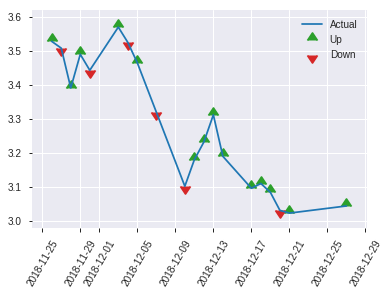


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21025421149431875
RMSE: 0.45853485308569375
LogLoss: 0.606957154018007
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 340.1862737963396
Residual deviance: 299.8368340848954
AIC: 401.8368340848954
AUC: 0.7272480672724807
pr_auc: 0.6046581917161399
Gini: 0.4544961345449614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31562036061829896: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   93   0.637    (93.0/146.0)
1      5    96   0.0495   (5.0/101.0)
Total  58   189  0.3968   (98.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31562      0.662069  188
max f2                       0.265296     0.818182  200
max f0point5                 0.659006     0.615616  57
max accuracy                 0.659006     0.688259  57
max precision                0.948161     1         0
max recall                   0.169401     1         232
max specificity              0.948161     1         0
max absolute_mcc             0.31562      0.363615  188
max min_per_class_accuracy   0.524588     0.633663  109
max mean_per_class_accuracy  0.366636     0.668147  170

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.893832           1.63036   1.63036            0.666667         0.91361   0.666667                    0.91361             0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.89002            1.22277   1.46733            0.5              0.892527  0.6                         0.905177            0.00990099      0.029703                   22.2772   46.7327
    3        0.0323887                   0.87057            1.63036   1.52847            0.666667         0.880052  0.625                       0.895755            0.019802        0.049505                   63.0363   52.8465
    4        0.0404858                   0.858622           1.22277   1.46733            0.5              0.862422  0.6                         0.889089            0.00990099      0.0594059                  22.2772   46.7327
    5        0.0526316                   0.844141           2.44554   1.69307            1                0.851407  0.692308                    0.880393            0.029703        0.0891089                  144.554   69.3069
    6        0.101215                    0.75326            1.83416   1.76079            0.75             0.788785  0.72                        0.836421            0.0891089       0.178218                   83.4158   76.0792
    7        0.149798                    0.712447           1.63036   1.71849            0.666667         0.735094  0.702703                    0.803558            0.0792079       0.257426                   63.0363   71.8491
    8        0.202429                    0.679623           1.69307   1.71188            0.692308         0.693859  0.7                         0.775036            0.0891089       0.346535                   69.3069   71.1881
    9        0.299595                    0.609808           1.32467   1.5863             0.541667         0.644601  0.648649                    0.732733            0.128713        0.475248                   32.467    58.6299
    10       0.40081                     0.553159           0.880396  1.40804            0.36             0.58033   0.575758                    0.694247            0.0891089       0.564356                   -11.9604  40.8041
    11       0.502024                    0.465157           0.880396  1.30166            0.36             0.508986  0.532258                    0.656896            0.0891089       0.653465                   -11.9604  30.1661
    12       0.59919                     0.409019           1.12087   1.27234            0.458333         0.436171  0.52027                     0.621103            0.108911        0.762376                   12.0875   27.2344
    13       0.700405                    0.363555           1.27168   1.27225            0.52             0.385305  0.520231                    0.587028            0.128713        0.891089                   27.1683   27.2249
    14       0.797571                    0.282112           0.713284  1.20415            0.291667         0.32943   0.492386                    0.555646            0.0693069       0.960396                   -28.6716  20.4151
    15       0.898785                    0.207328           0.195644  1.09058            0.08             0.238592  0.445946                    0.519941            0.019802        0.980198                   -80.4356  9.05807
    16       1                           0.0106452          0.195644  1                  0.08             0.146723  0.408907                    0.482166         

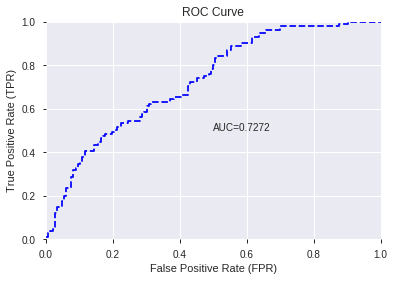

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


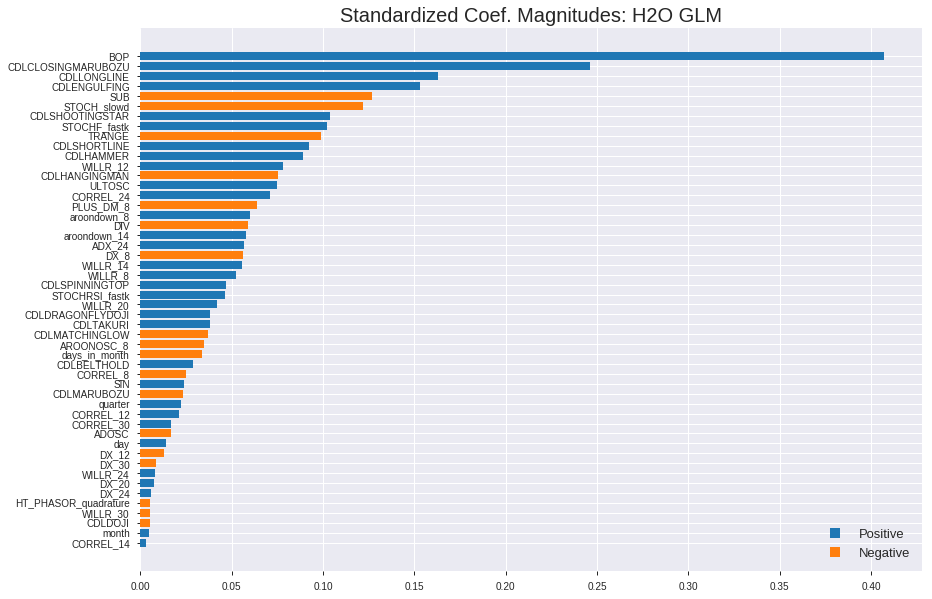

'log_likelihood'
--2019-08-26 14:01:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_140152_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_140152_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'SUB',
 'STOCH_slowd',
 'CDLSHOOTINGSTAR',
 'STOCHF_fastk',
 'TRANGE',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'WILLR_12',
 'CDLHANGINGMAN',
 'ULTOSC',
 'CORREL_24',
 'PLUS_DM_8',
 'aroondown_8',
 'DIV',
 'aroondown_14',
 'ADX_24',
 'DX_8',
 'WILLR_14',
 'WILLR_8',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'WILLR_20',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'AROONOSC_8',
 'days_in_month',
 'CDLBELTHOLD',
 'CORREL_8',
 'SIN',
 'CDLMARUBOZU',
 'quarter',
 'CORREL_12',
 'CORREL_30',
 'ADOSC',
 'day',
 'DX_12',
 'DX_30',
 'WILLR_24',
 'DX_20',
 'DX_24',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'CDLDOJI',
 'month',
 'CORREL_14']

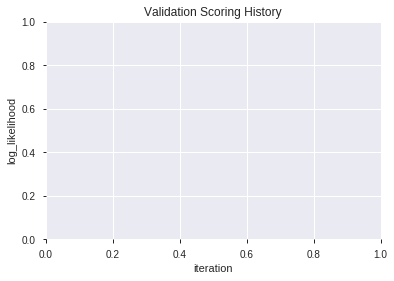

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_140204_model_5  0.745219  0.619918              0.341347  0.466888  0.217985
1  XGBoost_grid_1_AutoML_20190826_140204_model_6  0.744677  0.603473              0.332226  0.457726  0.209513
2  XGBoost_grid_1_AutoML_20190826_140204_model_3  0.735861  0.602953              0.323071  0.458077  0.209834
3               XGBoost_3_AutoML_20190826_140204  0.732538  0.604713              0.345517  0.458688  0.210395
4  XGBoost_grid_1_AutoML_20190826_140204_model_1  0.730774  0.609604              0.342093  0.461522  0.213003
5  XGBoost_grid_1_AutoML_20190826_140204_model_7  0.729147  0.620263              0.334497  0.466706  0.217814
6  XGBoost_grid_1_AutoML_20190826_140204_model_4  0.723179  0.618519              0.339821  0.465229  0.216438
7               XGBoost_1_AutoML_20190826_140204  0.720806  0.623204              0.345517  0.467502  0.218558
8               XGBoost_2_AutoML_20190826_140204  0.719924  0.617597              0.357690  0.465412  0.216609
9  XGBoost_grid_1_AutoML_20190826_140204_model_2  0.716737  0.617690              0.329547  0.465411  0.216607

variable  relative_importance  scaled_importance  percentage
0                    BOP          2615.398438           1.000000    0.108588
1                    day           955.269775           0.365248    0.039661
2                   DX_8           922.978516           0.352902    0.038321
3                 ADX_24           872.562195           0.333625    0.036228
4                    DIV           870.397888           0.332797    0.036138
5           STOCHF_fastk           841.214111           0.321639    0.034926
6              PLUS_DM_8           797.316528           0.304855    0.033103
7                    SUB           788.388306           0.301441    0.032733
8            STOCH_slowd           788.005066           0.301294    0.032717
9                 TRANGE           777.976807           0.297460    0.032301
10               WILLR_8           773.849426           0.295882    0.032129
11              CORREL_8           742.164124           0.283767    0.030814
12                 DX_12           704.356201           0.269311    0.029244
13             CORREL_30           704.053467           0.269195    0.029231
14             CORREL_14           697.266663           0.266601    0.028950
15             CORREL_12           639.080872           0.244353    0.026534
16                   SIN           630.340576           0.241011    0.026171
17                 ADOSC           615.931274           0.235502    0.025573
18                 month           581.228516           0.222233    0.024132
19              WILLR_12           546.648987           0.209012    0.022696
20                ULTOSC           544.950867           0.208362    0.022626
21  HT_PHASOR_quadrature           507.708954           0.194123    0.021079
22        STOCHRSI_fastk           493.595673           0.188727    0.020493
23                 DX_20           481.902435           0.184256    0.020008
24             CORREL_24           469.364685           0.179462    0.019487
25                 DX_30           441.762238           0.168908    0.018341
26                 DX_24           424.180664           0.162186    0.017611
27              WILLR_20           423.559509           0.161948    0.017586
28              WILLR_30           380.968994           0.145664    0.015817
29              WILLR_24           374.021393           0.143007    0.015529
30           aroondown_8           356.440765           0.136285    0.014799
31            AROONOSC_8           314.390289           0.120207    0.013053
32              WILLR_14           303.638977           0.116097    0.012607
33    CDLCLOSINGMARUBOZU           283.882263           0.108543    0.011786
34          aroondown_14           276.263336           0.105630    0.011470
35           CDLLONGLINE           203.094025           0.077653    0.008432
36         days_in_month           159.781204           0.061092    0.006634
37               quarter           158.609207           0.060644    0.006585
38          CDLSHORTLINE           149.043274           0.056987    0.006188
39        CDLSPINNINGTOP            96.556839           0.036919    0.004009
40          CDLENGULFING            68.280388           0.026107    0.002835
41             CDLHAMMER            64.389046           0.024619    0.002673
42       CDLSHOOTINGSTAR            61.497295           0.023514    0.002553
43           CDLBELTHOLD            60.219368           0.023025    0.002500
44               CDLDOJI            55.243263           0.021122    0.002294
45      CDLDRAGONFLYDOJI            19.918690           0.007616    0.000827
46         CDLHANGINGMAN            19.901192           0.007609    0.000826
47        CDLMATCHINGLOW            14.157973           0.005413    0.000588
48           CDLMARUBOZU            10.722506           0.004100    0.000445
49             CDLTAKURI             3.110778           0.001189    0.000129

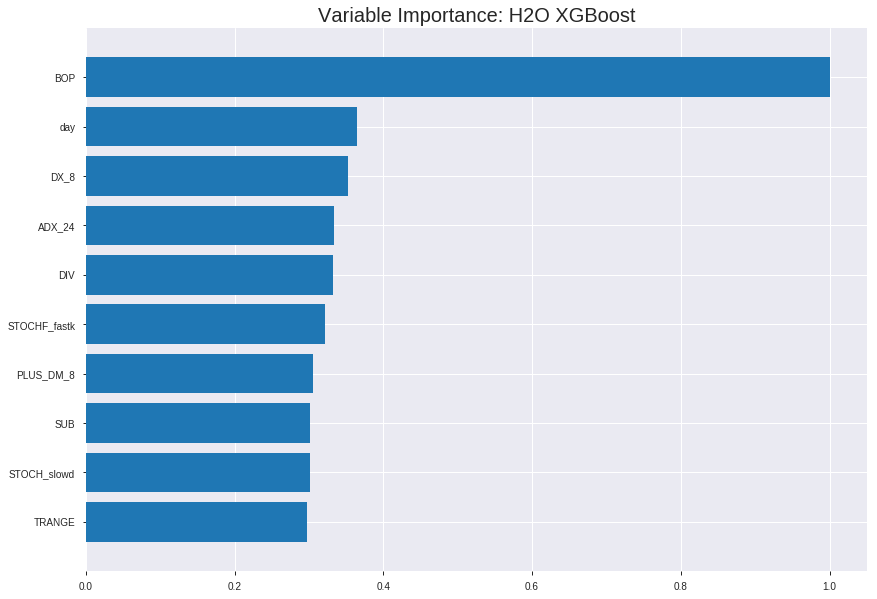

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_140204_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.02849253093270636
RMSE: 0.16879730724364758
LogLoss: 0.16666559797845248
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988066825775656
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5115189552307129: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      884  0    0        (0.0/884.0)
1      0    838  0        (0.0/838.0)
Total  884  838  0        (0.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.511519     1        198
max f2                       0.511519     1        198
max f0point5                 0.511519     1        198
max accuracy                 0.511519     1        198
max precision                0.960939     1        0
max recall                   0.511519     1        198
max specificity              0.960939     1        0
max absolute_mcc             0.511519     1        198
max min_per_class_accuracy   0.511519     1        198
max mean_per_class_accuracy  0.511519     1        198

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010453                    0.946135           2.05489  2.05489            1                0.94957    1                           0.94957             0.0214797       0.0214797                  105.489  105.489
    2        0.0203252                   0.938629           2.05489  2.05489            1                0.942058   1                           0.945922            0.0202864       0.0417661                  105.489  105.489
    3        0.0301974                   0.935242           2.05489  2.05489            1                0.936922   1                           0.942979            0.0202864       0.0620525                  105.489  105.489
    4        0.0400697                   0.930404           2.05489  2.05489            1                0.932179   1                           0.940318            0.0202864       0.0823389                  105.489  105.489
    5        0.0505226                   0.927538           2.05489  2.05489            1                0.928991   1                           0.937975            0.0214797       0.103819                   105.489  105.489
    6        0.100465                    0.913141           2.05489  2.05489            1                0.920334   1                           0.929206            0.102625        0.206444                   105.489  105.489
    7        0.150407                    0.896422           2.05489  2.05489            1                0.904779   1                           0.921095            0.102625        0.309069                   105.489  105.489
    8        0.200348                    0.879379           2.05489  2.05489            1                0.887781   1                           0.91279             0.102625        0.411695                   105.489  105.489
    9        0.300232                    0.843267           2.05489  2.05489            1                0.860976   1                           0.895552            0.205251        0.616945                   105.489  105.489
    10       0.400116                    0.783823           2.05489  2.05489            1                0.816983   1                           0.875938            0.205251        0.822196                   105.489  105.489
    11       0.5                         0.337447           1.78011  2                  0.866279         0.673087   0.973287                    0.835415            0.177804        1                          78.011   100
    12       0.599884                    0.206677           0        1.66699            0                0.256095   0.811229                    0.738955            0               1                          -100     66.6989
    13       0.699768                    0.149744           0        1.42905            0                0.177914   0.695436                    0.658873            0               1                          -100     42.9046
    14       0.799652                    0.110052           0        1.25054            0                0.128736   0.608569                    0.592654            0               1                          -100     25.0545
    15       0.899535                    0.0718068          0        1.11168            0                0.0905236  0.540994                    0.536898            0               1                          -100     11.1685
    16       1                           0.0343445          0        1                  0                0.0558434  0.486643                    0.488569            0               1 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21043984345803404
RMSE: 0.45873722702439795
LogLoss: 0.6104545107702948
Mean Per-Class Error: 0.31875662076271194
AUC: 0.7337046477754238
pr_auc: 0.7101272108261448
Gini: 0.46740929555084754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3590071201324463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  132  0.5593   (132.0/236.0)
1      28   228  0.1094   (28.0/256.0)
Total  132  360  0.3252   (160.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359007     0.74026   288
max f2                       0.137931     0.863821  367
max f0point5                 0.531364     0.692365  213
max accuracy                 0.531364     0.682927  213
max precision                0.945563     1         0
max recall                   0.121684     1         373
max specificity              0.945563     1         0
max absolute_mcc             0.359007     0.373562  288
max min_per_class_accuracy   0.569887     0.671875  196
max mean_per_class_accuracy  0.531364     0.681243  213

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.930356           1.5375    1.5375             0.8              0.942225  0.8                         0.942225            0.015625        0.015625                   53.75     53.75
    2        0.0203252                   0.915051           1.15312   1.34531            0.6              0.920787  0.7                         0.931506            0.0117188       0.0273438                  15.3125   34.5312
    3        0.0304878                   0.907461           1.92187   1.5375             1                0.912829  0.8                         0.92528             0.0195312       0.046875                   92.1875   53.75
    4        0.0406504                   0.903031           1.5375    1.5375             0.8              0.904746  0.8                         0.920147            0.015625        0.0625                     53.75     53.75
    5        0.050813                    0.896812           1.5375    1.5375             0.8              0.899512  0.8                         0.91602             0.015625        0.078125                   53.75     53.75
    6        0.101626                    0.851775           1.38375   1.46062            0.72             0.870944  0.76                        0.893482            0.0703125       0.148438                   38.375    46.0625
    7        0.150407                    0.814794           1.60156   1.50633            0.833333         0.836228  0.783784                    0.874913            0.078125        0.226562                   60.1562   50.6334
    8        0.20122                     0.7778             1.61437   1.53362            0.84             0.794088  0.79798                     0.854503            0.0820312       0.308594                   61.4375   53.3617
    9        0.300813                    0.733182           1.17666   1.41543            0.612245         0.757281  0.736486                    0.822314            0.117188        0.425781                   17.6658   41.5435
    10       0.400407                    0.640066           1.29432   1.38531            0.673469         0.690373  0.720812                    0.789497            0.128906        0.554688                   29.4324   38.5311
    11       0.5                         0.574814           1.09821   1.32812            0.571429         0.606554  0.691057                    0.753057            0.109375        0.664062                   9.82143   32.8125
    12       0.599593                    0.503825           0.941327  1.26388            0.489796         0.533603  0.657627                    0.716605            0.09375         0.757812                   -5.86735  26.3877
    13       0.699187                    0.402436           0.902105  1.21235            0.469388         0.448784  0.630814                    0.678456            0.0898438       0.847656                   -9.78954  21.2346
    14       0.79878                     0.281653           0.705995  1.14921            0.367347         0.341752  0.597964                    0.636475            0.0703125       0.917969                   -29.4005  14.9213
    15       0.898374                    0.158765           0.627551  1.09138            0.326531         0.223437  0.567873                    0.590686            0.0625          0.980469                   -37.2449  9.13815
    16       1                           0.0486702          0.192187  1                  0.1              0.106944  0.520325                    0.541525            0.019


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:02:23  5.432 sec   0                  0.5              0.693147            0.5             0                  1                0.513357                         0.5                0.693147              0.5               0                    1                  0.479675
    2019-08-26 14:02:23  5.710 sec   5                  0.437392         0.574561            0.976014        0.972037           2.05489          0.0783972                        0.483283           0.659999              0.693815          0.671239             1.5375             0.347561
    2019-08-26 14:02:23  5.969 sec   10                 0.383525         0.481436            0.9952          0.994184           2.05489          0.0301974                        0.472105           0.637694              0.711848          0.681065             1.15312            0.351626
    2019-08-26 14:02:23  6.190 sec   15                 0.342415         0.414432            0.997935        0.996843           2.05489          0.0209059                        0.465231           0.623471              0.719702          0.690388             1.15312            0.339431
    2019-08-26 14:02:24  6.411 sec   20                 0.311861         0.366699            0.999337        0.996938           2.05489          0.0127758                        0.460005           0.612377              0.72902           0.707899             1.5375             0.331301
    2019-08-26 14:02:24  6.647 sec   25                 0.281558         0.321507            0.999758        0.996169           2.05489          0.0058072                        0.459582           0.611307              0.725329          0.696669             1.5375             0.335366
    2019-08-26 14:02:24  6.885 sec   30                 0.257548         0.286367            0.999906        0.998708           2.05489          0.00522648                       0.458926           0.609484              0.726231          0.699312             1.15312            0.341463
    2019-08-26 14:02:24  7.139 sec   35                 0.23459          0.253524            0.999974        0.99878            2.05489          0.00116144                       0.458019           0.608236              0.727456          0.693873             1.15312            0.339431
    2019-08-26 14:02:25  7.391 sec   40                 0.213404         0.224609            0.999996        0.998802           2.05489          0.00058072                       0.456651           0.604925              0.732827          0.704251             1.15312            0.331301
    2019-08-26 14:02:25  7.649 sec   45                 0.196201         0.201618            1               0.998807           2.05489          0                                0.456214           0.604369              0.735881          0.708871             1.5375             0.327236
    2019-08-26 14:02:25  7.929 sec   50                 0.181223         0.182479            1               0.998807           2.05489          0                                0.457644           0.60783               0.734598          0.708965             1.5375             0.327236
    2019-08-26 14:02:25  8.231 sec   55                 0.168797         0.166666            1               0.998807           2.05489          0                                0.458737           0.610455              0.733705          0

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               2615.3984375           1.0                    0.10858771191075589
day               955.269775390625       0.3652482779272996     0.039661474779469304
DX_8              922.978515625          0.352901685032455      0.03832078650712454
ADX_24            872.5621948242188      0.33362495836706285    0.03622757086540055
DIV               870.3978881835938      0.332797433730819      0.03613771185860105
---               ---                    ---                    ---
CDLDRAGONFLYDOJI  19.918689727783203     0.007615929352172829   0.0008269963424264128
CDLHANGINGMAN     19.90119171142578      0.007609238969511995   0.0008262698490814654
CDLMATCHINGLOW    14.157973289489746     0.005413314119367232   0.0005878193940762761
CDLMARUBOZU       10.722505569458008     0.004099759874333873   0.00044518354413744337
CDLTAKURI         3.1107778549194336     0.0011894087762371517  0.00012915517753816453


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7125506072874493)

('F1', 0.662020905923345)

('auc', 0.7452190424521904)

('logloss', 0.619918441947934)

('mean_per_class_error', 0.3106605181066052)

('rmse', 0.46688844735605867)

('mse', 0.21798482227455118)

xgboost prediction progress: |████████████████████████████████████████████| 100%


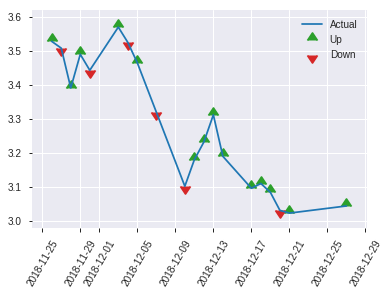


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21798482227455118
RMSE: 0.46688844735605867
LogLoss: 0.619918441947934
Mean Per-Class Error: 0.3106605181066052
AUC: 0.7452190424521904
pr_auc: 0.6672665686005141
Gini: 0.4904380849043808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28087830543518066: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   91   0.6233   (91.0/146.0)
1      6    95   0.0594   (6.0/101.0)
Total  61   186  0.3927   (97.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280878     0.662021  185
max f2                       0.195112     0.819536  199
max f0point5                 0.733845     0.656836  67
max accuracy                 0.733845     0.712551  67
max precision                0.917413     1         0
max recall                   0.0480607    1         246
max specificity              0.917413     1         0
max absolute_mcc             0.733845     0.39075   67
max min_per_class_accuracy   0.595662     0.650685  116
max mean_per_class_accuracy  0.682934     0.689339  88

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.897361           2.44554    2.44554            1                0.907797   1                           0.907797            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.892015           1.22277    1.95644            0.5              0.895782   0.8                         0.902991            0.00990099      0.039604                   22.2772   95.6436
    3        0.0323887                   0.883348           2.44554    2.13985            1                0.88888    0.875                       0.897699            0.029703        0.0693069                  144.554   113.985
    4        0.0404858                   0.87946            2.44554    2.20099            1                0.880433   0.9                         0.894246            0.019802        0.0891089                  144.554   120.099
    5        0.0526316                   0.874709           1.63036    2.06931            0.666667         0.877383   0.846154                    0.890355            0.019802        0.108911                   63.0363   106.931
    6        0.101215                    0.858557           2.03795    2.05426            0.833333         0.867046   0.84                        0.879167            0.0990099       0.207921                   103.795   105.426
    7        0.149798                    0.819256           1.42657    1.85068            0.583333         0.83527    0.756757                    0.86493             0.0693069       0.277228                   42.6568   85.0682
    8        0.202429                    0.785289           1.88119    1.85861            0.769231         0.803847   0.76                        0.849048            0.0990099       0.376238                   88.1188   85.8614
    9        0.299595                    0.707937           1.22277    1.65239            0.5              0.746142   0.675676                    0.815673            0.118812        0.49505                    22.2772   65.2395
    10       0.40081                     0.64902            1.07604    1.50685            0.44             0.682075   0.616162                    0.781936            0.108911        0.60396                    7.60396   50.6851
    11       0.502024                    0.578425           0.684752   1.34111            0.28             0.612876   0.548387                    0.747851            0.0693069       0.673267                   -31.5248  34.1105
    12       0.59919                     0.468036           0.917079   1.27234            0.375            0.509615   0.52027                     0.709219            0.0891089       0.762376                   -8.29208  27.2344
    13       0.700405                    0.326531           1.17386    1.25811            0.48             0.391137   0.514451                    0.663253            0.118812        0.881188                   17.3861   25.8113
    14       0.797571                    0.219325           0.917079   1.21657            0.375            0.275735   0.497462                    0.616043            0.0891089       0.970297                   -8.29208  21.6565
    15       0.898785                    0.105715           0.0978218  1.09058            0.04             0.15637    0.445946                    0.564278            0.00990099      0.980198                   -90.2178  9.05807
    16       1                           0.0480607          0.195644   1                  0.08             0.0779152  0.408907 

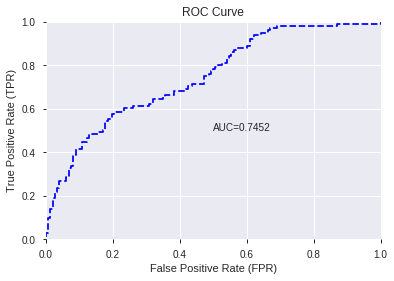

This function is available for GLM models only


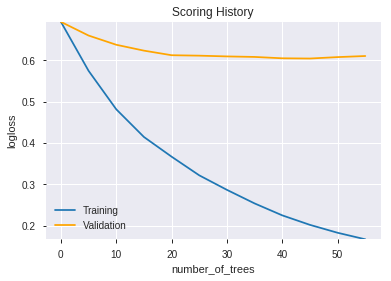

--2019-08-26 14:02:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_140204_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_140204_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'day',
 'DX_8',
 'ADX_24',
 'DIV',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'SUB',
 'STOCH_slowd',
 'TRANGE',
 'WILLR_8',
 'CORREL_8',
 'DX_12',
 'CORREL_30',
 'CORREL_14',
 'CORREL_12',
 'SIN',
 'ADOSC',
 'month',
 'WILLR_12',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'DX_20',
 'CORREL_24',
 'DX_30',
 'DX_24',
 'WILLR_20',
 'WILLR_30',
 'WILLR_24',
 'aroondown_8',
 'AROONOSC_8',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'aroondown_14',
 'CDLLONGLINE',
 'days_in_month',
 'quarter',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLBELTHOLD',
 'CDLDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'CDLMARUBOZU',
 'CDLTAKURI']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_140238_model_1  0.719517  0.652618              0.342873  0.469332  0.220272

variable  relative_importance  scaled_importance    percentage
0                          BOP         2.962645e-01           1.000000  4.121721e-02
1           CDLCLOSINGMARUBOZU         1.902085e-01           0.642023  2.646239e-02
2                  CDLLONGLINE         1.405614e-01           0.474446  1.955532e-02
3                 CDLENGULFING         1.263801e-01           0.426579  1.758238e-02
4                 STOCHF_fastk         1.144440e-01           0.386290  1.592179e-02
...                        ...                  ...                ...           ...
1039  BBANDS_middleband_14_0_2         3.499655e-06           0.000012  4.868825e-07
1040  BBANDS_middleband_20_2_5         3.108780e-06           0.000010  4.325028e-07
1041                   MA_12_5         2.552882e-06           0.000009  3.551646e-07
1042  BBANDS_middleband_14_1_2         1.546548e-06           0.000005  2.151604e-07
1043  BBANDS_middleband_30_5_4         5.161110e-07           0.000002  7.180291e-08

[1044 rows x 4 columns]

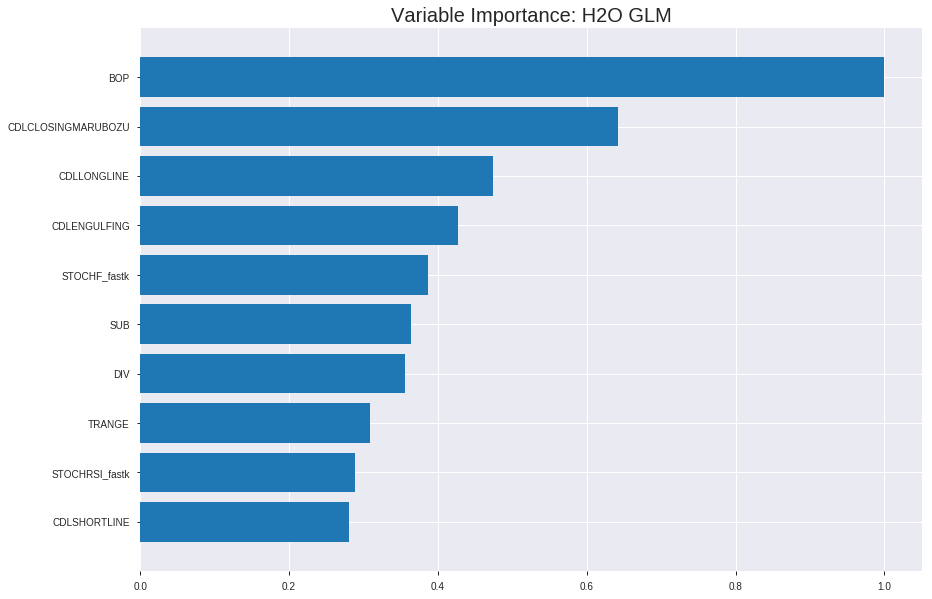

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_140238_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1824883435213441
RMSE: 0.4271865441716816
LogLoss: 0.5439202660634302
Null degrees of freedom: 1721
Residual degrees of freedom: 677
Null deviance: 2385.969939946232
Residual deviance: 1873.261396322454
AIC: 3963.261396322454
AUC: 0.8057693657598894
pr_auc: 0.7770637287480776
Gini: 0.6115387315197789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4113295960399713: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      526  358   0.405    (358.0/884.0)
1      126  712   0.1504   (126.0/838.0)
Total  652  1070  0.2811   (484.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41133      0.746331  241
max f2                       0.230142     0.853532  326
max f0point5                 0.56586      0.727194  159
max accuracy                 0.502086     0.732288  194
max precision                0.930271     1         0
max recall                   0.0894466    1         385
max specificity              0.930271     1         0
max absolute_mcc             0.502086     0.464093  194
max min_per_class_accuracy   0.495852     0.729117  197
max mean_per_class_accuracy  0.502086     0.731988  194

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.880656           2.05489   2.05489            1                0.900404  1                           0.900404            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.859588           1.81314   1.93747            0.882353         0.870365  0.942857                    0.885814            0.0178998       0.0393795                  81.3141   93.747
    3        0.0301974                   0.848534           1.93402   1.93634            0.941176         0.855103  0.942308                    0.875774            0.0190931       0.0584726                  93.4017   93.6341
    4        0.0400697                   0.835173           1.45051   1.81664            0.705882         0.839907  0.884058                    0.866937            0.0143198       0.0727924                  45.0512   81.6644
    5        0.0505226                   0.824631           1.82657   1.8187             0.888889         0.830061  0.885057                    0.859308            0.0190931       0.0918854                  82.6571   81.8698
    6        0.100465                    0.773259           1.76816   1.79358            0.860465         0.797613  0.872832                    0.828639            0.0883055       0.180191                   76.8163   79.3577
    7        0.150407                    0.735079           1.67259   1.7534             0.813953         0.753756  0.853282                    0.803774            0.0835322       0.263723                   67.2587   75.3403
    8        0.200348                    0.69201            1.72038   1.74517            0.837209         0.714055  0.849275                    0.781409            0.0859189       0.349642                   72.0375   74.517
    9        0.300232                    0.620539           1.46949   1.65345            0.715116         0.654681  0.804642                    0.739248            0.146778        0.49642                    46.9487   65.3453
    10       0.400116                    0.55545            1.25444   1.55384            0.610465         0.588217  0.756168                    0.701545            0.125298        0.621718                   25.444    55.3845
    11       0.5                         0.488721           1.13497   1.47017            0.552326         0.524751  0.715447                    0.666227            0.113365        0.735084                   13.497    47.0167
    12       0.599884                    0.423886           0.907976  1.37656            0.44186          0.455582  0.669894                    0.631154            0.0906921       0.825776                   -9.20242  37.6559
    13       0.699768                    0.365368           0.836294  1.29944            0.406977         0.393213  0.632365                    0.597191            0.0835322       0.909308                   -16.3706  29.9442
    14       0.799652                    0.279973           0.513723  1.2013             0.25             0.322654  0.584604                    0.562898            0.0513126       0.960621                   -48.6277  20.1299
    15       0.899535                    0.1849             0.274782  1.09842            0.133721         0.235091  0.534538                    0.526499            0.0274463       0.988067                   -72.5218  9.8419
    16       1                           0.0237024          0.11878   1                  0.0578035        0.129788  0.486643                    0.486644            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20461216012439506
RMSE: 0.45234075664745826
LogLoss: 0.5940726791458725
Null degrees of freedom: 491
Residual degrees of freedom: -553
Null deviance: 683.4768170160789
Residual deviance: 584.5675162795384
AIC: 2674.5675162795383
AUC: 0.7475172139830508
pr_auc: 0.7537716954653044
Gini: 0.49503442796610164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3139761066663007: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      66   170  0.7203   (170.0/236.0)
1      13   243  0.0508   (13.0/256.0)
Total  79   413  0.372    (183.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313976     0.726457  325
max f2                       0.172484     0.852765  384
max f0point5                 0.635344     0.719538  134
max accuracy                 0.52571      0.695122  212
max precision                0.926164     1         0
max recall                   0.172484     1         384
max specificity              0.926164     1         0
max absolute_mcc             0.635344     0.395378  134
max min_per_class_accuracy   0.556759     0.6875    194
max mean_per_class_accuracy  0.590138     0.69369   168

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.901467           1.92187   1.92187            1                0.915516  1                           0.915516            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.872367           1.92187   1.92187            1                0.893797  1                           0.904656            0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.860799           1.15312   1.66562            0.6              0.866141  0.866667                    0.891818            0.0117188       0.0507812                  15.3125   66.5625
    4        0.0406504                   0.849427           1.92187   1.72969            1                0.854976  0.9                         0.882607            0.0195312       0.0703125                  92.1875   72.9687
    5        0.050813                    0.831526           1.5375    1.69125            0.8              0.840819  0.88                        0.87425             0.015625        0.0859375                  53.75     69.125
    6        0.101626                    0.793454           1.69125   1.69125            0.88             0.807544  0.88                        0.840897            0.0859375       0.171875                   69.125    69.125
    7        0.150407                    0.755925           1.28125   1.55828            0.666667         0.778703  0.810811                    0.820726            0.0625          0.234375                   28.125    55.8277
    8        0.20122                     0.733877           1.61437   1.57244            0.84             0.743028  0.818182                    0.801105            0.0820312       0.316406                   61.4375   57.2443
    9        0.300813                    0.66336            1.41199   1.51932            0.734694         0.701208  0.790541                    0.768031            0.140625        0.457031                   41.199    51.932
    10       0.400407                    0.610791           1.21588   1.44385            0.632653         0.636061  0.751269                    0.735206            0.121094        0.578125                   21.588    44.3845
    11       0.5                         0.560523           1.01977   1.35937            0.530612         0.585584  0.707317                    0.705403            0.101562        0.679688                   1.97704   35.9375
    12       0.599593                    0.501372           0.941327  1.28994            0.489796         0.528246  0.671186                    0.675977            0.09375         0.773438                   -5.86735  28.9936
    13       0.699187                    0.415559           0.588329  1.19               0.306122         0.457666  0.619186                    0.644881            0.0585938       0.832031                   -41.1671  18.9998
    14       0.79878                     0.341352           0.784439  1.13943            0.408163         0.382673  0.592875                    0.612188            0.078125        0.910156                   -21.5561  13.9432
    15       0.898374                    0.246667           0.509885  1.06964            0.265306         0.299215  0.556561                    0.577492            0.0507812       0.960938                   -49.0115  6.96408
    16       1                           0.0343924          0.384375  1                  0.2              0.179758  0.520325                    0.537072            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 14:02:42  0.000 sec   2            .23E2     1043          1.3544248352670156  1.3664956034867897
     2019-08-26 14:02:44  1.942 sec   4            .16E2     1043          1.3464680234321098  1.360853872936092
     2019-08-26 14:02:46  3.910 sec   6            .12E2     1043          1.3367116679784488  1.3537065812532112
     2019-08-26 14:02:48  6.147 sec   8            .87E1     1044          1.3249307621843904  1.3449373912503693
     2019-08-26 14:02:50  8.096 sec   10           .63E1     1044          1.310901806021185   1.3343326947058332
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 14:03:16  34.552 sec  36           .1E0      1045          1.0765263587725888  1.1881513821595389
     2019-08-26 14:03:18  36.610 sec  38           .74E-1    1045          1.0665772186838907  1.1904110882371308
     2019-08-26 14:03:20  38.619 sec  40           .54E-1    1045          1.057824108831301   1.1943390038782185
     2019-08-26 14:03:22  40.694 sec  42           .39E-1    1045          1.0500754905925547  1.1995112376220682
     2019-08-26 14:03:24  42.696 sec  44           .29E-1    1045          1.04326166656065    1.2055003033087557


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882591093117408)

('F1', 0.6596491228070176)

('auc', 0.7195171571951716)

('logloss', 0.6526182204299404)

('mean_per_class_error', 0.3247321307473213)

('rmse', 0.46933167943940624)

('mse', 0.22027222532541357)

glm prediction progress: |████████████████████████████████████████████████| 100%


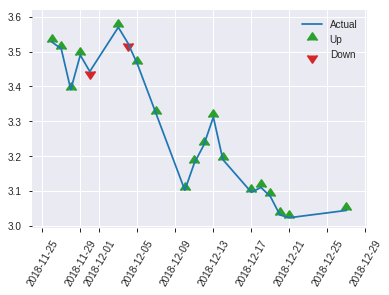


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22027222532541357
RMSE: 0.46933167943940624
LogLoss: 0.6526182204299404
Null degrees of freedom: 246
Residual degrees of freedom: -798
Null deviance: 340.1862737963396
Residual deviance: 322.39340089239056
AIC: 2412.3934008923907
AUC: 0.7195171571951716
pr_auc: 0.5870628725589275
Gini: 0.43903431439034324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38034535209041814: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   90   0.6164   (90.0/146.0)
1      7    94   0.0693   (7.0/101.0)
Total  63   184  0.3927   (97.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380345     0.659649  183
max f2                       0.270688     0.803571  211
max f0point5                 0.590173     0.618661  97
max accuracy                 0.624778     0.688259  81
max precision                0.999924     1         0
max recall                   0.146409     1         237
max specificity              0.999924     1         0
max absolute_mcc             0.380345     0.354438  183
max min_per_class_accuracy   0.5443       0.653465  111
max mean_per_class_accuracy  0.590173     0.675268  97

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.907069           1.63036    1.63036            0.666667         0.971801  0.666667                    0.971801            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.883016           2.44554    1.95644            1                0.895099  0.8                         0.94112             0.019802        0.039604                   144.554   95.6436
    3        0.0323887                   0.875707           0.815182   1.52847            0.333333         0.880758  0.625                       0.918484            0.00990099      0.049505                   -18.4818  52.8465
    4        0.0404858                   0.867197           1.22277    1.46733            0.5              0.869109  0.6                         0.908609            0.00990099      0.0594059                  22.2772   46.7327
    5        0.0526316                   0.86223            1.63036    1.50495            0.666667         0.865248  0.615385                    0.898603            0.019802        0.0792079                  63.0363   50.495
    6        0.101215                    0.797976           1.63036    1.56515            0.666667         0.826965  0.64                        0.864217            0.0792079       0.158416                   63.0363   56.5149
    7        0.149798                    0.748393           1.83416    1.65239            0.75             0.780782  0.675676                    0.837157            0.0891089       0.247525                   83.4158   65.2395
    8        0.202429                    0.705244           1.50495    1.61406            0.615385         0.727465  0.66                        0.808637            0.0792079       0.326733                   50.495    61.4059
    9        0.299595                    0.64086            1.42657    1.55325            0.583333         0.665822  0.635135                    0.762318            0.138614        0.465347                   42.6568   55.3251
    10       0.40081                     0.589577           1.3695     1.50685            0.56             0.615793  0.616162                    0.725317            0.138614        0.60396                    36.9505   50.6851
    11       0.502024                    0.520887           0.880396   1.38055            0.36             0.547024  0.564516                    0.689371            0.0891089       0.693069                   -11.9604  38.0549
    12       0.59919                     0.469199           0.611386   1.25582            0.25             0.491691  0.513514                    0.657315            0.0594059       0.752475                   -38.8614  25.582
    13       0.700405                    0.402744           0.978218   1.2157             0.4              0.436232  0.49711                     0.625366            0.0990099       0.851485                   -2.17822  21.5704
    14       0.797571                    0.320068           0.917079   1.17932            0.375            0.366108  0.482234                    0.593781            0.0891089       0.940594                   -8.29208  17.9324
    15       0.898785                    0.229101           0.489109   1.1016             0.2              0.275071  0.45045                     0.557891            0.049505        0.990099                   -51.0891  10.1597
    16       1                           0.0169594          0.0978218  1                  0.04             0.158479  0.408907                    0

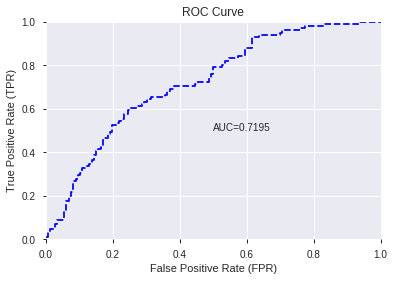

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


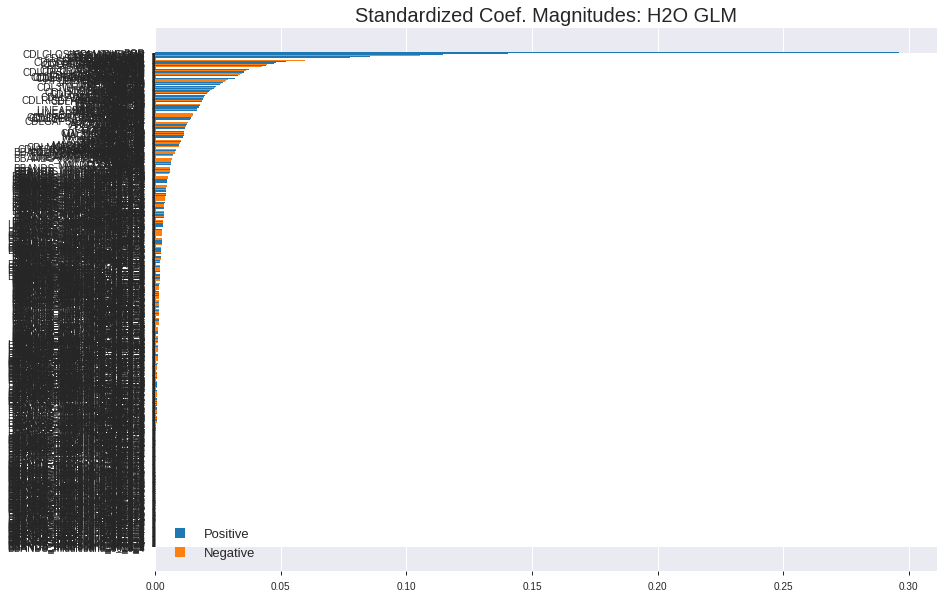

'log_likelihood'
--2019-08-26 14:03:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_140238_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_140238_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

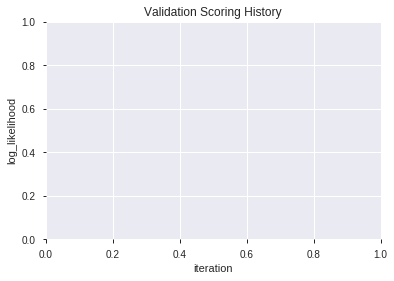

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190826_140350  0.742642  0.607417              0.323478  0.461534  0.213014
1  XGBoost_grid_1_AutoML_20190826_140350_model_1  0.740608  0.611076              0.320426  0.461720  0.213186
2               XGBoost_2_AutoML_20190826_140350  0.737759  0.615215              0.321952  0.463650  0.214972
3  XGBoost_grid_1_AutoML_20190826_140350_model_5  0.733284  0.637971              0.328801  0.473468  0.224172
4  XGBoost_grid_1_AutoML_20190826_140350_model_7  0.730300  0.623872              0.323851  0.468032  0.219054
5  XGBoost_grid_1_AutoML_20190826_140350_model_6  0.725010  0.616859              0.310152  0.464910  0.216141
6  XGBoost_grid_1_AutoML_20190826_140350_model_2  0.724332  0.617828              0.322325  0.465136  0.216351
7               XGBoost_1_AutoML_20190826_140350  0.719110  0.628427              0.332972  0.469435  0.220369
8  XGBoost_grid_1_AutoML_20190826_140350_model_3  0.715855  0.629632              0.337549  0.470493  0.221364
9  XGBoost_grid_1_AutoML_20190826_140350_model_4  0.715177  0.629374              0.318900  0.470477  0.221349

variable  relative_importance  scaled_importance  percentage
0                        BOP          2678.809082           1.000000    0.278993
1               STOCHF_fastk           423.909332           0.158245    0.044149
2                        SUB           392.602112           0.146558    0.040889
3         CDLCLOSINGMARUBOZU           321.979980           0.120195    0.033534
4                    BETA_14           152.417297           0.056897    0.015874
..                       ...                  ...                ...         ...
278                   SMA_30             0.881330           0.000329    0.000092
279  BBANDS_upperband_14_0_5             0.880766           0.000329    0.000092
280              MINUS_DI_24             0.569071           0.000212    0.000059
281  BBANDS_upperband_12_5_5             0.443903           0.000166    0.000046
282  BBANDS_upperband_20_6_5             0.298393           0.000111    0.000031

[283 rows x 4 columns]

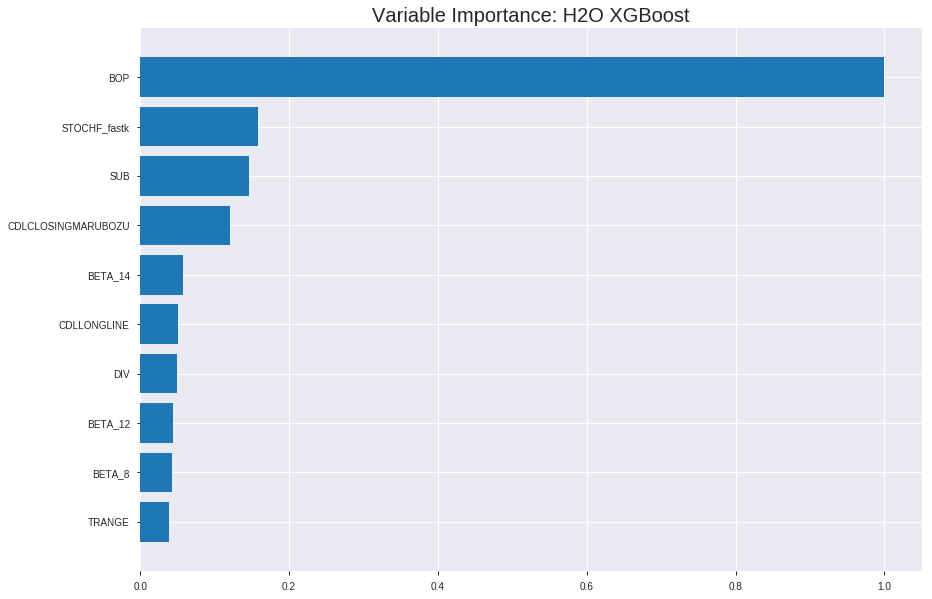

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190826_140350


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12038741038092707
RMSE: 0.34696888964419714
LogLoss: 0.4009168596818515
Mean Per-Class Error: 0.13221255089147832
AUC: 0.9447996198663052
pr_auc: 0.9451074430033917
Gini: 0.8895992397326105
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5049699246883392: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  128  0.1448   (128.0/884.0)
1      103  735  0.1229   (103.0/838.0)
Total  859  863  0.1341   (231.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50497      0.864198  196
max f2                       0.319114     0.91029   278
max f0point5                 0.584206     0.888612  158
max accuracy                 0.527179     0.868177  186
max precision                0.914476     1         0
max recall                   0.198175     1         329
max specificity              0.914476     1         0
max absolute_mcc             0.527179     0.736189  186
max min_per_class_accuracy   0.512577     0.861991  192
max mean_per_class_accuracy  0.527179     0.867787  186

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.77 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.881725           2.05489    2.05489            1                0.893855  1                           0.893855            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.868877           2.05489    2.05489            1                0.876094  1                           0.885228            0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.862496           2.05489    2.05489            1                0.865805  1                           0.878878            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.855047           2.05489    2.05489            1                0.858384  1                           0.873829            0.0202864       0.0823389                  105.489   105.489
    5        0.0505226                   0.846471           2.05489    2.05489            1                0.850981  1                           0.869102            0.0214797       0.103819                   105.489   105.489
    6        0.100465                    0.81297            2.05489    2.05489            1                0.829011  1                           0.849172            0.102625        0.206444                   105.489   105.489
    7        0.150407                    0.782305           2.05489    2.05489            1                0.797609  1                           0.832051            0.102625        0.309069                   105.489   105.489
    8        0.200348                    0.747023           2.031      2.04894            0.988372         0.766319  0.997101                    0.815665            0.101432        0.410501                   103.1     104.894
    9        0.300232                    0.667667           1.88763    1.99527            0.918605         0.707667  0.970986                    0.779735            0.188544        0.599045                   88.7634   99.5273
    10       0.400116                    0.585113           1.61285    1.89981            0.784884         0.628055  0.924528                    0.74187             0.161098        0.760143                   61.2852   89.9806
    11       0.5                         0.505533           1.15886    1.75179            0.563953         0.546329  0.852497                    0.702807            0.115752        0.875895                   15.8864   75.179
    12       0.599884                    0.411532           0.621247   1.56355            0.302326         0.459085  0.760891                    0.662226            0.0620525       0.937947                   -37.8753  56.3548
    13       0.699768                    0.312251           0.501776   1.41199            0.244186         0.36153   0.687137                    0.619305            0.0501193       0.988067                   -49.8224  41.1993
    14       0.799652                    0.212143           0.107523   1.24905            0.0523256        0.265336  0.607843                    0.575091            0.0107399       0.998807                   -89.2477  24.9052
    15       0.899535                    0.143487           0.0119471  1.11168            0.00581395       0.174863  0.540994                    0.53065             0.00119332      1                          -98.8053  11.1685
    16       1                           0.0466137          0          1                  0                0.102838  0.486643                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20541348133236917
RMSE: 0.45322564063871007
LogLoss: 0.5966327234452062
Mean Per-Class Error: 0.29608050847457634
AUC: 0.7436357918432204
pr_auc: 0.7322375904520527
Gini: 0.48727158368644075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2985565662384033: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   167  0.7076   (167.0/236.0)
1      12   244  0.0469   (12.0/256.0)
Total  81   411  0.3638   (179.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.298557     0.731634  325
max f2                       0.155917     0.858008  371
max f0point5                 0.633275     0.719965  162
max accuracy                 0.592336     0.703252  181
max precision                0.887133     1         0
max recall                   0.143423     1         377
max specificity              0.887133     1         0
max absolute_mcc             0.592336     0.407556  181
max min_per_class_accuracy   0.574648     0.690678  189
max mean_per_class_accuracy  0.592336     0.703919  181

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 54.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.867599           1.92187   1.92187            1                0.878535  1                           0.878535            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.851022           1.5375    1.72969            0.8              0.861252  0.9                         0.869894            0.015625        0.0351562                  53.75     72.9687
    3        0.0304878                   0.839557           1.92187   1.79375            1                0.844952  0.933333                    0.86158             0.0195312       0.0546875                  92.1875   79.375
    4        0.0406504                   0.83213            1.92187   1.82578            1                0.837903  0.95                        0.855661            0.0195312       0.0742188                  92.1875   82.5781
    5        0.050813                    0.822526           1.15312   1.69125            0.6              0.827254  0.88                        0.849979            0.0117188       0.0859375                  15.3125   69.125
    6        0.101626                    0.794922           1.23      1.46062            0.64             0.807433  0.76                        0.828706            0.0625          0.148438                   23        46.0625
    7        0.150407                    0.76258            1.44141   1.45439            0.75             0.778282  0.756757                    0.812352            0.0703125       0.21875                    44.1406   45.4392
    8        0.20122                     0.741368           1.61437   1.49479            0.84             0.75314   0.777778                    0.7974              0.0820312       0.300781                   61.4375   49.4792
    9        0.300813                    0.693395           1.41199   1.46738            0.734694         0.716599  0.763514                    0.770648            0.140625        0.441406                   41.199    46.7378
    10       0.400407                    0.650548           1.33355   1.43409            0.693878         0.671889  0.746193                    0.746084            0.132812        0.574219                   33.3546   43.4089
    11       0.5                         0.57916            1.13744   1.375              0.591837         0.624765  0.715447                    0.721918            0.113281        0.6875                     13.7436   37.5
    12       0.599593                    0.50858            0.823661  1.28342            0.428571         0.539826  0.667797                    0.691672            0.0820312       0.769531                   -17.6339  28.3422
    13       0.699187                    0.437228           0.705995  1.20117            0.367347         0.478462  0.625                       0.661302            0.0703125       0.839844                   -29.4005  20.1172
    14       0.79878                     0.337835           0.705995  1.13943            0.367347         0.387935  0.592875                    0.627218            0.0703125       0.910156                   -29.4005  13.9432
    15       0.898374                    0.198211           0.627551  1.08269            0.326531         0.274338  0.563348                    0.588098            0.0625          0.972656                   -37.2449  8.26852
    16       1                           0.0522345          0.269062  1                  0.14             0.145697  0.520325                    0.543139            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:04:03  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.513357                         0.5                0.693147              0.5               0                    1                  0.479675
    2019-08-26 14:04:04  0.708 sec   5                  0.46945          0.633535            0.860536        0.847508           2.05489          0.220674                         0.48224            0.658057              0.734706          0.717269             1.5375             0.327236
    2019-08-26 14:04:04  0.911 sec   10                 0.44764          0.591986            0.874084        0.86623            2.05489          0.222997                         0.472665           0.639063              0.734358          0.714566             1.5375             0.378049
    2019-08-26 14:04:04  1.148 sec   15                 0.426753         0.552504            0.888851        0.884997           2.05489          0.195122                         0.465429           0.624315              0.735318          0.71747              1.5375             0.378049
    2019-08-26 14:04:04  1.366 sec   20                 0.411783         0.524173            0.898155        0.895443           2.05489          0.191057                         0.460417           0.613728              0.741401          0.731385             1.5375             0.304878
    2019-08-26 14:04:04  1.568 sec   25                 0.399542         0.500776            0.906904        0.90574            2.05489          0.183508                         0.45888            0.610043              0.735898          0.727339             1.92187            0.319106
    2019-08-26 14:04:05  1.790 sec   30                 0.389337         0.480979            0.91135         0.909823           2.05489          0.181765                         0.456956           0.60563               0.738033          0.728691             1.92187            0.315041
    2019-08-26 14:04:05  1.995 sec   35                 0.380321         0.463615            0.918138        0.917911           2.05489          0.178281                         0.456446           0.604007              0.737114          0.725338             1.5375             0.323171
    2019-08-26 14:04:05  2.202 sec   40                 0.37277          0.448833            0.923542        0.922974           2.05489          0.171312                         0.454856           0.60059               0.740599          0.728437             1.5375             0.321138
    2019-08-26 14:04:05  2.410 sec   45                 0.366839         0.437231            0.928045        0.927728           2.05489          0.162602                         0.454849           0.60042               0.740805          0.729319             1.92187            0.365854
    2019-08-26 14:04:05  2.616 sec   50                 0.359438         0.423606            0.934814        0.934825           2.05489          0.147503                         0.452526           0.595312              0.745159          0.734682             1.92187            0.363821
    2019-08-26 14:04:06  2.834 sec   55                 0.352229         0.410566            0.941015        0.941052           2.05489          0.138211                         0.452754           0.595688              0.745746          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2678.80908203125       1.0                     0.27899311965424456
STOCHF_fastk             423.9093322753906      0.15824544388730927     0.04414939006119111
SUB                      392.60211181640625     0.14655845183215124     0.04088879968834821
CDLCLOSINGMARUBOZU       321.97998046875        0.12019519518151085     0.03353363247114053
BETA_14                  152.41729736328125     0.05689740951890024     0.015873985781923085
---                      ---                    ---                     ---
SMA_30                   0.8813304901123047     0.0003290008593833875   9.178897612829871e-05
BBANDS_upperband_14_0_5  0.8807659149169922     0.00032879010334291433  9.173017664308112e-05
MINUS_DI_24              0.5690708160400391     0.0002124342566468126   5.9267695983324683e-05
BBANDS_upperband_12_5_5  0.44390296936035156    0.00016570907286298842  4.6231691193057655e-05
BBANDS_upperband_20_6_5  0.29839324951171875    0.00011139026349927755  3.107711711277177e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6923076923076923)

('F1', 0.6691176470588236)

('auc', 0.7426420724264208)

('logloss', 0.6074167472685941)

('mean_per_class_error', 0.31405126814051265)

('rmse', 0.46153392328950205)

('mse', 0.21301356234699997)

xgboost prediction progress: |████████████████████████████████████████████| 100%


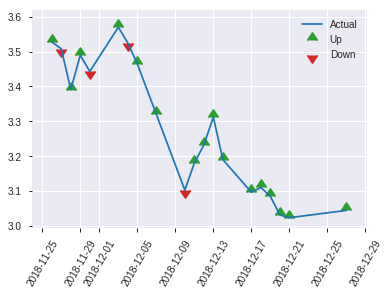


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21301356234699997
RMSE: 0.46153392328950205
LogLoss: 0.6074167472685941
Mean Per-Class Error: 0.31405126814051265
AUC: 0.7426420724264208
pr_auc: 0.640391587407364
Gini: 0.48528414485284155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.376529335975647: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   80   0.5479   (80.0/146.0)
1      10   91   0.099    (10.0/101.0)
Total  76   171  0.3644   (90.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376529     0.669118  170
max f2                       0.270353     0.815308  196
max f0point5                 0.710546     0.6231    56
max accuracy                 0.710546     0.692308  56
max precision                0.865945     1         0
max recall                   0.180509     1         215
max specificity              0.865945     1         0
max absolute_mcc             0.376529     0.376064  170
max min_per_class_accuracy   0.603956     0.678082  115
max mean_per_class_accuracy  0.609346     0.685949  111

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.845381           2.44554   2.44554            1                0.854203  1                           0.854203            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.836535           1.22277   1.95644            0.5              0.839807  0.8                         0.848445            0.00990099      0.039604                   22.2772   95.6436
    3        0.0323887                   0.826549           2.44554   2.13985            1                0.832496  0.875                       0.842464            0.029703        0.0693069                  144.554   113.985
    4        0.0404858                   0.815376           1.22277   1.95644            0.5              0.823671  0.8                         0.838705            0.00990099      0.0792079                  22.2772   95.6436
    5        0.0526316                   0.807985           1.63036   1.88119            0.666667         0.811169  0.769231                    0.832351            0.019802        0.0990099                  63.0363   88.1188
    6        0.101215                    0.784832           2.03795   1.95644            0.833333         0.797028  0.8                         0.815396            0.0990099       0.19802                    103.795   95.6436
    7        0.149798                    0.757403           1.01898   1.65239            0.416667         0.775903  0.675676                    0.802587            0.049505        0.247525                   1.89769   65.2395
    8        0.202429                    0.722142           1.88119   1.71188            0.769231         0.741996  0.7                         0.786833            0.0990099       0.346535                   88.1188   71.1881
    9        0.299595                    0.690987           1.12087   1.5202             0.458333         0.7046    0.621622                    0.760163            0.108911        0.455446                   12.0875   52.0203
    10       0.40081                     0.632884           1.27168   1.45745            0.52             0.661456  0.59596                     0.735237            0.128713        0.584158                   27.1683   45.7446
    11       0.502024                    0.585621           1.17386   1.40027            0.48             0.608421  0.572581                    0.709669            0.118812        0.70297                    17.3861   40.0271
    12       0.59919                     0.479492           0.815182  1.30539            0.333333         0.5393    0.533784                    0.682042            0.0792079       0.782178                   -18.4818  30.5392
    13       0.700405                    0.359374           1.17386   1.28638            0.48             0.42139   0.526012                    0.644375            0.118812        0.90099                    17.3861   28.6385
    14       0.797571                    0.266945           0.713284  1.21657            0.291667         0.309518  0.497462                    0.603581            0.0693069       0.970297                   -28.6716  21.6565
    15       0.898785                    0.157277           0.293465  1.11261            0.12             0.20358   0.454955                    0.558535            0.029703        1                          -70.6535  11.2613
    16       1                           0.0527568          0         1                  0                0.10629   0.408907                    0.512762         

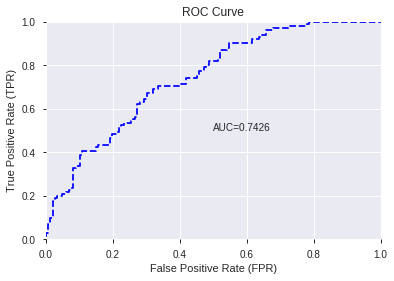

This function is available for GLM models only


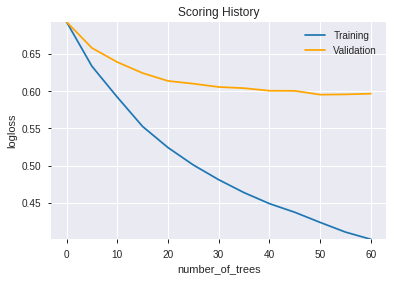

--2019-08-26 14:04:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190826_140350',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190826_140350',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a58e',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_140450_model_5  0.748949  0.601053              0.336023  0.458504  0.210226
1  DeepLearning_grid_1_AutoML_20190826_140450_model_8  0.740743  0.608473              0.346297  0.459972  0.211574
2  DeepLearning_grid_1_AutoML_20190826_140450_model_3  0.735861  0.687863              0.372542  0.486322  0.236510
3  DeepLearning_grid_1_AutoML_20190826_140450_model_6  0.733962  0.644222              0.353520  0.474263  0.224925
4  DeepLearning_grid_1_AutoML_20190826_140450_model_7  0.729893  0.859645              0.348196  0.525133  0.275764
5  DeepLearning_grid_1_AutoML_20190826_140450_model_9  0.728062  0.613173              0.354672  0.461490  0.212973
6  DeepLearning_grid_1_AutoML_20190826_140450_model_1  0.705683  1.189968              0.383189  0.572379  0.327617
7  DeepLearning_grid_1_AutoML_20190826_140450_model_2  0.701546  0.951648              0.355418  0.550286  0.302815
8  DeepLearning_grid_1_AutoML_20190826_140450_model_4  0.696257  0.876165              0.344025  0.522641  0.273154
9               DeepLearning_1_AutoML_20190826_140450  0.694697  0.686587              0.350129  0.486827  0.237000

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.035950
1     CDLCLOSINGMARUBOZU             0.847670           0.847670    0.030473
2           CDLSHORTLINE             0.781393           0.781393    0.028091
3            CDLLONGLINE             0.653837           0.653837    0.023505
4                    SUB             0.636273           0.636273    0.022874
5                    SIN             0.633619           0.633619    0.022778
6           CDLENGULFING             0.622665           0.622665    0.022385
7               CORREL_8             0.620397           0.620397    0.022303
8                    day             0.598419           0.598419    0.021513
9           aroondown_14             0.597852           0.597852    0.021493
10                  DX_8             0.585591           0.585591    0.021052
11             CORREL_24             0.564808           0.564808    0.020305
12         CDLHANGINGMAN             0.564427           0.564427    0.020291
13          STOCHF_fastk             0.562600           0.562600    0.020225
14        CDLSPINNINGTOP             0.559654           0.559654    0.020119
15         days_in_month             0.556493           0.556493    0.020006
16            AROONOSC_8             0.555239           0.555239    0.019961
17             CORREL_12             0.550508           0.550508    0.019791
18           STOCH_slowd             0.547799           0.547799    0.019693
19        STOCHRSI_fastk             0.544726           0.544726    0.019583
20             PLUS_DM_8             0.544086           0.544086    0.019560
21                 DX_12             0.541809           0.541809    0.019478
22                ADX_24             0.541420           0.541420    0.019464
23       CDLSHOOTINGSTAR             0.538156           0.538156    0.019346
24                 month             0.537511           0.537511    0.019323
25                ULTOSC             0.536982           0.536982    0.019304
26           aroondown_8             0.535804           0.535804    0.019262
27               quarter             0.533468           0.533468    0.019178
28                TRANGE             0.532774           0.532774    0.019153
29               CDLDOJI             0.532162           0.532162    0.019131
30             CORREL_30             0.529100           0.529100    0.019021
31                 DX_24             0.528897           0.528897    0.019014
32              WILLR_12             0.528662           0.528662    0.019005
33                   DIV             0.527679           0.527679    0.018970
34                 DX_20             0.512894           0.512894    0.018438
35              WILLR_30             0.512252           0.512252    0.018415
36             CDLTAKURI             0.509135           0.509135    0.018303
37               WILLR_8             0.501401           0.501401    0.018025
38      CDLDRAGONFLYDOJI             0.496783           0.496783    0.017859
39                 ADOSC             0.495618           0.495618    0.017817
40  HT_PHASOR_quadrature             0.494558           0.494558    0.017779
41             CORREL_14             0.491806           0.491806    0.017680
42           CDLBELTHOLD             0.486296           0.486296    0.017482
43              WILLR_20             0.484365           0.484365    0.017413
44              WILLR_24             0.482379           0.482379    0.017341
45                 DX_30             0.476666           0.476666    0.017136
46           CDLMARUBOZU             0.466584           0.466584    0.016773
47             CDLHAMMER             0.464692           0.464692    0.016705
48              WILLR_14             0.447232           0.447232    0.016078
49        CDLMATCHINGLOW             0.421591           0.421591    0.015156

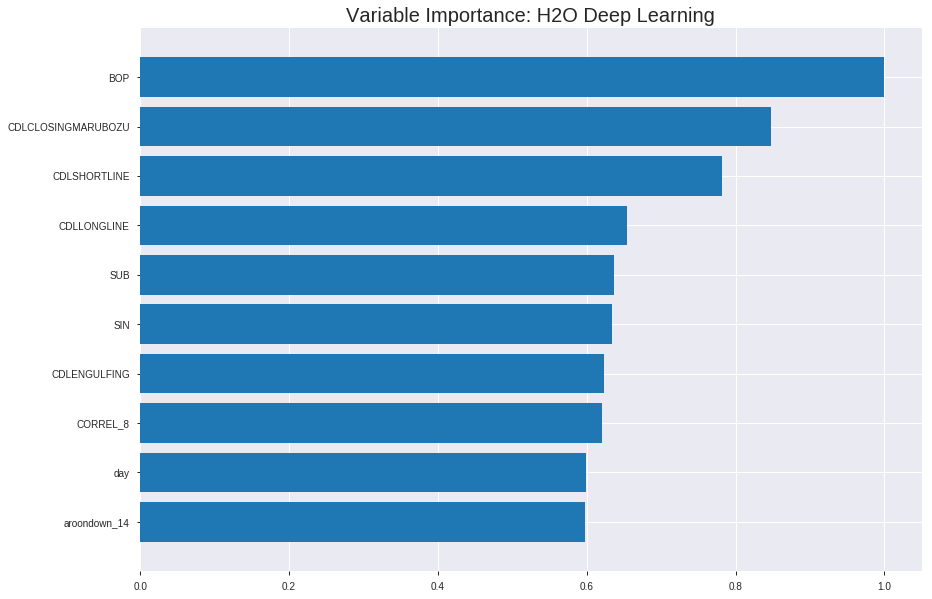

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_140450_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17726751251369707
RMSE: 0.42103148636853405
LogLoss: 0.5251107667674317
Mean Per-Class Error: 0.26226255143144095
AUC: 0.8228861812762557
pr_auc: 0.8113514382744397
Gini: 0.6457723625525114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4606288266972502: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      459  425   0.4808   (425.0/884.0)
1      67   771   0.08     (67.0/838.0)
Total  526  1196  0.2857   (492.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460629     0.758112  239
max f2                       0.347523     0.865466  285
max f0point5                 0.607937     0.734445  141
max accuracy                 0.552496     0.738095  180
max precision                0.984141     1         0
max recall                   0.0733931    1         373
max specificity              0.984141     1         0
max absolute_mcc             0.460629     0.476683  239
max min_per_class_accuracy   0.547743     0.734163  183
max mean_per_class_accuracy  0.552496     0.737737  180

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.933397           2.05489   2.05489            1                0.952903   1                           0.952903            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.89794            2.05489   2.05489            1                0.913588   1                           0.933807            0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.871247           2.05489   2.05489            1                0.884614   1                           0.917724            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.84629            2.05489   2.05489            1                0.856502   1                           0.902641            0.0202864       0.0823389                  105.489   105.489
    5        0.0505226                   0.823729           1.94073   2.03127            0.944444         0.835429   0.988506                    0.888735            0.0202864       0.102625                   94.0732   103.127
    6        0.100465                    0.766976           1.83985   1.93611            0.895349         0.79312    0.942197                    0.841204            0.0918854       0.194511                   83.9846   93.6113
    7        0.150407                    0.7222             1.67259   1.84861            0.813953         0.740687   0.899614                    0.807828            0.0835322       0.278043                   67.2587   84.861
    8        0.200348                    0.686153           1.55312   1.77495            0.755814         0.704507   0.863768                    0.782072            0.0775656       0.355609                   55.3117   77.4951
    9        0.300232                    0.621568           1.50533   1.68525            0.732558         0.653637   0.820116                    0.739343            0.150358        0.505967                   50.5328   68.525
    10       0.400116                    0.582113           1.2186    1.56876            0.593023         0.600875   0.763425                    0.704776            0.121718        0.627685                   21.8599   56.8757
    11       0.5                         0.545703           1.12302   1.47971            0.546512         0.563509   0.720093                    0.676556            0.112172        0.739857                   12.3023   47.9714
    12       0.599884                    0.50822            0.884082  1.38054            0.430233         0.528234   0.67183                     0.651859            0.0883055       0.828162                   -11.5918  38.0538
    13       0.699768                    0.457206           0.943817  1.3182             0.459302         0.485221   0.641494                    0.628074            0.0942721       0.922434                   -5.6183   31.8201
    14       0.799652                    0.339632           0.52567   1.21921            0.255814         0.408807   0.593319                    0.600685            0.052506        0.97494                    -47.433   21.9206
    15       0.899535                    0.144616           0.226994  1.10903            0.110465         0.248211   0.539703                    0.561547            0.022673        0.997613                   -77.3006  10.9032
    16       1                           0.00552942         0.023756  1                  0.0115607        0.0714429  0.486643                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21417156244396662
RMSE: 0.4627867353803117
LogLoss: 0.6110492437831608
Mean Per-Class Error: 0.3238877118644068
AUC: 0.7263804290254238
pr_auc: 0.7347271825454895
Gini: 0.45276085805084754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5003200409803221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   143  0.6059   (143.0/236.0)
1      32   224  0.125    (32.0/256.0)
Total  125  367  0.3557   (175.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50032      0.719101  286
max f2                       0.206999     0.856372  367
max f0point5                 0.618917     0.695971  171
max accuracy                 0.598049     0.674797  190
max precision                0.986185     1         0
max recall                   0.103585     1         379
max specificity              0.986185     1         0
max absolute_mcc             0.618917     0.355983  171
max min_per_class_accuracy   0.589605     0.667969  199
max mean_per_class_accuracy  0.618917     0.676112  171

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 57.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.93896            1.92187   1.92187            1                0.962105  1                           0.962105            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.911157           1.92187   1.92187            1                0.921649  1                           0.941877            0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.887191           1.92187   1.92187            1                0.899958  1                           0.927904            0.0195312       0.0585938                  92.1875   92.1875
    4        0.0406504                   0.870505           1.92187   1.92187            1                0.880015  1                           0.915932            0.0195312       0.078125                   92.1875   92.1875
    5        0.050813                    0.847232           1.15312   1.76812            0.6              0.858287  0.92                        0.904403            0.0117188       0.0898438                  15.3125   76.8125
    6        0.101626                    0.790189           1.38375   1.57594            0.72             0.817586  0.82                        0.860994            0.0703125       0.160156                   38.375    57.5937
    7        0.150407                    0.755547           1.44141   1.53231            0.75             0.772332  0.797297                    0.832239            0.0703125       0.230469                   44.1406   53.2306
    8        0.20122                     0.72771            1.30688   1.47538            0.68             0.740939  0.767677                    0.809183            0.0664062       0.296875                   30.6875   47.5379
    9        0.300813                    0.675936           1.37277   1.44141            0.714286         0.700716  0.75                        0.773272            0.136719        0.433594                   37.2768   44.1406
    10       0.400407                    0.626645           1.2551    1.39507            0.653061         0.649526  0.725888                    0.742493            0.125           0.558594                   25.5102   39.5067
    11       0.5                         0.589951           1.05899   1.32812            0.55102          0.610226  0.691057                    0.716147            0.105469        0.664062                   5.89923   32.8125
    12       0.599593                    0.554623           0.941327  1.26388            0.489796         0.571385  0.657627                    0.692102            0.09375         0.757812                   -5.86735  26.3877
    13       0.699187                    0.518858           0.784439  1.19559            0.408163         0.538736  0.622093                    0.670256            0.078125        0.835938                   -21.5561  19.5585
    14       0.79878                     0.469117           0.666773  1.12965            0.346939         0.496669  0.587786                    0.648613            0.0664062       0.902344                   -33.3227  12.9652
    15       0.898374                    0.298237           0.627551  1.07399            0.326531         0.402044  0.558824                    0.621278            0.0625          0.964844                   -37.2449  7.3989
    16       1                           0.00442005         0.345937  1                  0.18             0.150591  0.520325                    0.573444          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:08:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:08:37  1 min 51.675 sec  1206 obs/sec      1.3252    1             2282       0.437598         0.562581            0.233487       0.784216        0.754631           1.82657          0.328688                         0.470699           0.631385              0.112302         0.729534          0.742156             1.5375             0.386179
    2019-08-26 14:08:45  1 min 59.532 sec  2007 obs/sec      10.5012   8             18083      0.421031         0.525111            0.290424       0.822886        0.811351           2.05489          0.285714                         0.462787           0.611049              0.141896         0.72638           0.734727             1.92187            0.355691
    2019-08-26 14:08:53  2 min  7.643 sec  2216 obs/sec      21.1086   16            36349      0.40604          0.489972            0.340054       0.85461         0.848522           2.05489          0.253775                         0.466373           0.629458              0.128546         0.731934          0.721822             1.5375             0.353659
    2019-08-26 14:09:01  2 min 15.445 sec  2328 obs/sec      31.7387   24            54654      0.37607          0.42605             0.433882       0.882186        0.869808           2.05489          0.217189                         0.464969           0.654477              0.133783         0.731636          0.723337             1.5375             0.333333
    2019-08-26 14:09:08  2 min 23.001 sec  2399 obs/sec      42.2195   32            72702      0.355673         0.386536            0.493627       0.909846        0.895303           2.05489          0.18583                          0.476896           0.678067              0.0887737        0.715878          0.72008              1.5375             0.404472
    2019-08-26 14:09:16  2 min 30.364 sec  2457 obs/sec      52.7213   40            90786      0.330192         0.336842            0.56358        0.930159        0.907636           2.05489          0.162021                         0.473356           0.714542              0.102252         0.725553          0.711308             1.5375             0.347561
    2019-08-26 14:09:17  2 min 31.105 sec  2455 obs/sec      52.7213   40            90786      0.421031         0.525111            0.290424       0.822886        0.811351           2.05489          0.285714                         0.462787           0.611049              0.141896         0.72638           0.734727             1.92187            0.355691

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03594958788861142
CDLCLOSINGMARUBOZU  0.8476701974868774     0.8476701974868774   0.030473394265111097
CDLSHORTLINE        0.7813928723335266     0.7813928723335266   0.028090751739488638
CDLLONGLINE         0.6538370251655579     0.6538370251655579   0.02350517160101746
SUB                 0.6362734436988831     0.6362734436988831   0.022873768085442444
---                 ---                    ---                  ---
DX_30               0.47666576504707336    0.47666576504707336  0.017135937814051965
CDLMARUBOZU         0.46658381819725037    0.46658381819725037  0.016773495979685943
CDLHAMMER           0.4646916687488556     0.4646916687488556   0.016705473986792486
WILLR_14            0.4472324848175049     0.4472324848175049   0.016077823519588964
CDLMATCHINGLOW      0.4215908646583557     0.4215908646583557   0.01515601784207124


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7044534412955465)

('F1', 0.6643109540636043)

('auc', 0.7489488674894886)

('logloss', 0.6010527122013362)

('mean_per_class_error', 0.3156110131561102)

('rmse', 0.4585040507947688)

('mse', 0.21022596459521192)

deeplearning prediction progress: |███████████████████████████████████████| 100%


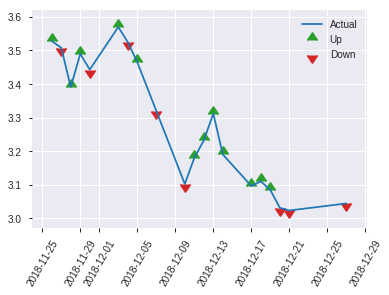


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21022596459521192
RMSE: 0.4585040507947688
LogLoss: 0.6010527122013362
Mean Per-Class Error: 0.3156110131561102
AUC: 0.7489488674894886
pr_auc: 0.6463433389777385
Gini: 0.49789773497897727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4548735721231565: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   88   0.6027   (88.0/146.0)
1      7    94   0.0693   (7.0/101.0)
Total  65   182  0.3846   (95.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454874     0.664311  180
max f2                       0.375914     0.818182  199
max f0point5                 0.631515     0.642317  73
max accuracy                 0.631515     0.704453  73
max precision                0.973267     1         0
max recall                   0.208612     1         217
max specificity              0.973267     1         0
max absolute_mcc             0.597902     0.378584  87
max min_per_class_accuracy   0.576165     0.653465  109
max mean_per_class_accuracy  0.597902     0.684389  87

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 52.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.932445           2.44554   2.44554            1                0.950539   1                           0.950539            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.889374           2.44554   2.44554            1                0.919103   1                           0.937964            0.019802        0.049505                   144.554   144.554
    3        0.0323887                   0.853401           0         1.52847            0                0.867977   0.625                       0.911719            0               0.049505                   -100      52.8465
    4        0.0404858                   0.844574           2.44554   1.71188            1                0.847253   0.7                         0.898826            0.019802        0.0693069                  144.554   71.1881
    5        0.0526316                   0.839928           1.63036   1.69307            0.666667         0.841951   0.692308                    0.885701            0.019802        0.0891089                  63.0363   69.3069
    6        0.101215                    0.785119           2.03795   1.85861            0.833333         0.812105   0.76                        0.850375            0.0990099       0.188119                   103.795   85.8614
    7        0.149798                    0.716128           1.83416   1.85068            0.75             0.747232   0.756757                    0.816923            0.0891089       0.277228                   83.4158   85.0682
    8        0.202429                    0.669868           1.88119   1.85861            0.769231         0.692693   0.76                        0.784624            0.0990099       0.376238                   88.1188   85.8614
    9        0.299595                    0.630448           1.32467   1.68544            0.541667         0.651047   0.689189                    0.741301            0.128713        0.50495                    32.467    68.5443
    10       0.40081                     0.588231           1.07604   1.53155            0.44             0.603532   0.626263                    0.706511            0.108911        0.613861                   7.60396   53.1553
    11       0.502024                    0.553712           0.489109  1.32138            0.2              0.573221   0.540323                    0.679638            0.049505        0.663366                   -51.0891  32.1383
    12       0.59919                     0.532312           1.22277   1.30539            0.5              0.543778   0.533784                    0.657607            0.118812        0.782178                   22.2772   30.5392
    13       0.700405                    0.478898           0.978218  1.25811            0.4              0.508455   0.514451                    0.636053            0.0990099       0.881188                   -2.17822  25.8113
    14       0.797571                    0.391583           0.815182  1.20415            0.333333         0.438439   0.492386                    0.611978            0.0792079       0.960396                   -18.4818  20.4151
    15       0.898785                    0.167919           0.391287  1.11261            0.16             0.28594    0.454955                    0.575262            0.039604        1                          -60.8713  11.2613
    16       1                           0.00771766         0         1                  0                0.0977098  0.408907                   

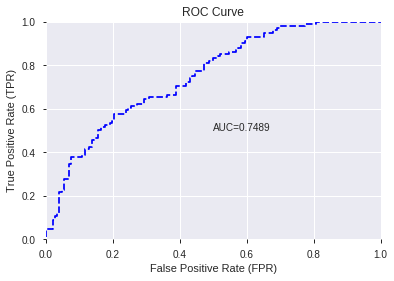

This function is available for GLM models only


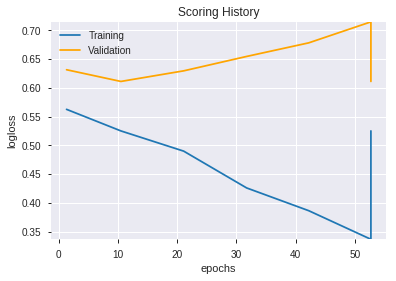

--2019-08-26 14:14:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_140450_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_140450_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'SUB',
 'SIN',
 'CDLENGULFING',
 'CORREL_8',
 'day',
 'aroondown_14',
 'DX_8',
 'CORREL_24',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'CDLSPINNINGTOP',
 'days_in_month',
 'AROONOSC_8',
 'CORREL_12',
 'STOCH_slowd',
 'STOCHRSI_fastk',
 'PLUS_DM_8',
 'DX_12',
 'ADX_24',
 'CDLSHOOTINGSTAR',
 'month',
 'ULTOSC',
 'aroondown_8',
 'quarter',
 'TRANGE',
 'CDLDOJI',
 'CORREL_30',
 'DX_24',
 'WILLR_12',
 'DIV',
 'DX_20',
 'WILLR_30',
 'CDLTAKURI',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'ADOSC',
 'HT_PHASOR_quadrature',
 'CORREL_14',
 'CDLBELTHOLD',
 'WILLR_20',
 'WILLR_24',
 'DX_30',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'WILLR_14',
 'CDLMATCHINGLOW']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_141457_model_1  0.727248  0.606957              0.343246  0.458535  0.210254

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.407219           1.000000    0.133901
1     CDLCLOSINGMARUBOZU             0.246288           0.604806    0.080984
2            CDLLONGLINE             0.163202           0.400772    0.053664
3           CDLENGULFING             0.152971           0.375649    0.050300
4                    SUB             0.126650           0.311013    0.041645
5            STOCH_slowd             0.121647           0.298727    0.040000
6        CDLSHOOTINGSTAR             0.103875           0.255085    0.034156
7           STOCHF_fastk             0.102305           0.251229    0.033640
8                 TRANGE             0.098891           0.242845    0.032517
9           CDLSHORTLINE             0.092053           0.226052    0.030269
10             CDLHAMMER             0.089279           0.219242    0.029357
11              WILLR_12             0.078296           0.192270    0.025745
12         CDLHANGINGMAN             0.075450           0.185282    0.024809
13                ULTOSC             0.074871           0.183860    0.024619
14             CORREL_24             0.071118           0.174644    0.023385
15             PLUS_DM_8             0.063894           0.156905    0.021010
16           aroondown_8             0.060150           0.147710    0.019778
17                   DIV             0.058784           0.144355    0.019329
18          aroondown_14             0.057573           0.141382    0.018931
19                ADX_24             0.056486           0.138711    0.018574
20                  DX_8             0.056385           0.138465    0.018541
21              WILLR_14             0.055610           0.136561    0.018286
22               WILLR_8             0.052481           0.128878    0.017257
23        CDLSPINNINGTOP             0.046797           0.114918    0.015388
24        STOCHRSI_fastk             0.046203           0.113460    0.015192
25              WILLR_20             0.041830           0.102721    0.013754
26      CDLDRAGONFLYDOJI             0.038163           0.093716    0.012549
27             CDLTAKURI             0.038091           0.093540    0.012525
28        CDLMATCHINGLOW             0.036788           0.090340    0.012097
29            AROONOSC_8             0.035091           0.086172    0.011538
30         days_in_month             0.033744           0.082865    0.011096
31           CDLBELTHOLD             0.028634           0.070315    0.009415
32              CORREL_8             0.024948           0.061265    0.008203
33                   SIN             0.024105           0.059194    0.007926
34           CDLMARUBOZU             0.023375           0.057401    0.007686
35               quarter             0.022299           0.054760    0.007332
36             CORREL_12             0.020921           0.051376    0.006879
37             CORREL_30             0.016873           0.041435    0.005548
38                 ADOSC             0.016739           0.041107    0.005504
39                   day             0.014146           0.034738    0.004651
40                 DX_12             0.013139           0.032265    0.004320
41                 DX_30             0.008631           0.021195    0.002838
42              WILLR_24             0.008046           0.019758    0.002646
43                 DX_20             0.007588           0.018635    0.002495
44                 DX_24             0.005864           0.014400    0.001928
45  HT_PHASOR_quadrature             0.005551           0.013632    0.001825
46              WILLR_30             0.005351           0.013140    0.001759
47               CDLDOJI             0.005222           0.012823    0.001717
48                 month             0.004709           0.011564    0.001548
49             CORREL_14             0.002869           0.007046    0.000943

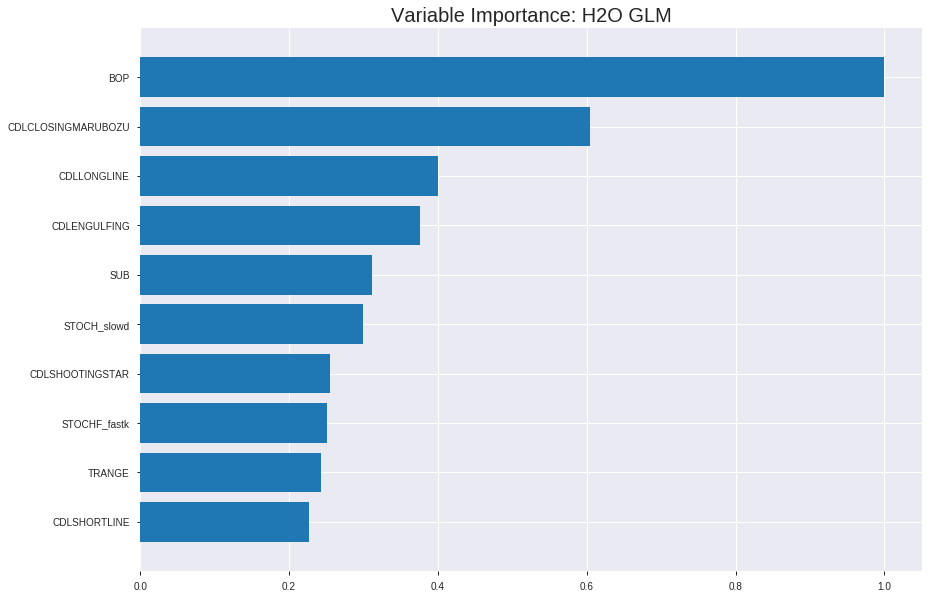

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_141457_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1877326552335382
RMSE: 0.4332812657310932
LogLoss: 0.5558652856021695
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2385.969939946232
Residual deviance: 1914.4000436138717
AIC: 2016.4000436138717
AUC: 0.7901185487964233
pr_auc: 0.7583567977644987
Gini: 0.5802370975928466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3766237148978952: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      469  415   0.4695   (415.0/884.0)
1      112  726   0.1337   (112.0/838.0)
Total  581  1141  0.306    (527.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376624     0.733704  253
max f2                       0.246918     0.850042  319
max f0point5                 0.578309     0.722417  149
max accuracy                 0.468293     0.718351  204
max precision                0.938832     1         0
max recall                   0.0749339    1         392
max specificity              0.938832     1         0
max absolute_mcc             0.468293     0.438683  204
max min_per_class_accuracy   0.488931     0.71599   194
max mean_per_class_accuracy  0.468293     0.719159  204

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.890065           1.94073   1.94073            0.944444         0.907064  0.944444                    0.907064            0.0202864       0.0202864                  94.0732   94.0732
    2        0.0203252                   0.876749           1.81314   1.87876            0.882353         0.882803  0.914286                    0.89528             0.0178998       0.0381862                  81.3141   87.8759
    3        0.0301974                   0.859598           1.93402   1.89682            0.941176         0.867874  0.923077                    0.88632             0.0190931       0.0572792                  93.4017   89.6824
    4        0.0400697                   0.845786           1.45051   1.78686            0.705882         0.85258   0.869565                    0.878008            0.0143198       0.071599                   45.0512   78.6863
    5        0.0505226                   0.833747           1.71241   1.77146            0.833333         0.839475  0.862069                    0.870035            0.0178998       0.0894988                  71.2411   77.1459
    6        0.100465                    0.784762           1.69648   1.73419            0.825581         0.809315  0.843931                    0.839851            0.0847255       0.174224                   69.6481   73.4187
    7        0.150407                    0.747375           1.55312   1.67406            0.755814         0.766353  0.814672                    0.815446            0.0775656       0.25179                    55.3117   67.4063
    8        0.200348                    0.706986           1.67259   1.6737             0.813953         0.72757   0.814493                    0.793541            0.0835322       0.335322                   67.2587   67.3695
    9        0.300232                    0.628807           1.52922   1.62563            0.744186         0.662873  0.791103                    0.750069            0.152745        0.488067                   52.9222   62.5631
    10       0.400116                    0.558954           1.26639   1.53595            0.616279         0.592689  0.74746                     0.710781            0.126492        0.614558                   26.6387   53.595
    11       0.5                         0.483166           1.05134   1.43914            0.511628         0.523964  0.700348                    0.673461            0.105012        0.71957                    5.13404   43.9141
    12       0.599884                    0.41632            0.967711  1.36065            0.47093          0.448933  0.662149                    0.636076            0.0966587       0.816229                   -3.22889  36.0645
    13       0.699768                    0.356923           0.764611  1.27557            0.372093         0.385589  0.620747                    0.600322            0.0763723       0.892601                   -23.5389  27.5568
    14       0.799652                    0.279358           0.573458  1.18787            0.27907          0.320498  0.578068                    0.565369            0.0572792       0.949881                   -42.6542  18.7868
    15       0.899535                    0.16827            0.358412  1.09577            0.174419         0.225195  0.533247                    0.527597            0.0357995       0.98568                    -64.1588  9.57658
    16       1                           0.0355158          0.142536  1                  0.0693642        0.11996   0.486643                    0.486644          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20733419678537413
RMSE: 0.455339649915724
LogLoss: 0.6005709193294988
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 683.4768170160789
Residual deviance: 590.9617846202268
AIC: 692.9617846202268
AUC: 0.7416909427966102
pr_auc: 0.7444321291176677
Gini: 0.4833818855932204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2856975192926213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      66   170  0.7203   (170.0/236.0)
1      15   241  0.0586   (15.0/256.0)
Total  81   411  0.376    (185.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285698     0.722639  325
max f2                       0.139611     0.852197  386
max f0point5                 0.579264     0.722997  174
max accuracy                 0.579264     0.70122   174
max precision                0.934489     1         0
max recall                   0.139611     1         386
max specificity              0.934489     1         0
max absolute_mcc             0.579264     0.408365  174
max min_per_class_accuracy   0.554363     0.690678  194
max mean_per_class_accuracy  0.579264     0.703456  174

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.892715           1.5375    1.5375             0.8              0.914136  0.8                         0.914136            0.015625        0.015625                   53.75     53.75
    2        0.0203252                   0.879227           1.5375    1.5375             0.8              0.886729  0.8                         0.900433            0.015625        0.03125                    53.75     53.75
    3        0.0304878                   0.862543           1.92187   1.66562            1                0.872183  0.866667                    0.891016            0.0195312       0.0507812                  92.1875   66.5625
    4        0.0406504                   0.851615           1.92187   1.72969            1                0.857956  0.9                         0.882751            0.0195312       0.0703125                  92.1875   72.9687
    5        0.050813                    0.846036           1.5375    1.69125            0.8              0.850249  0.88                        0.876251            0.015625        0.0859375                  53.75     69.125
    6        0.101626                    0.786324           1.5375    1.61437            0.8              0.808617  0.84                        0.842434            0.078125        0.164062                   53.75     61.4375
    7        0.150407                    0.756293           1.68164   1.63619            0.875            0.769886  0.851351                    0.818905            0.0820312       0.246094                   68.1641   63.6191
    8        0.20122                     0.717264           1.5375    1.61127            0.8              0.736835  0.838384                    0.79818             0.078125        0.324219                   53.75     61.1269
    9        0.300813                    0.657742           1.37277   1.53231            0.714286         0.681788  0.797297                    0.759645            0.136719        0.460938                   37.2768   53.2306
    10       0.400407                    0.603067           1.13744   1.43409            0.591837         0.631051  0.746193                    0.727659            0.113281        0.574219                   13.7436   43.4089
    11       0.5                         0.556613           1.01977   1.35156            0.530612         0.579011  0.703252                    0.698051            0.101562        0.675781                   1.97704   35.1562
    12       0.599593                    0.478792           0.823661  1.26388            0.428571         0.523596  0.657627                    0.669073            0.0820312       0.757812                   -17.6339  26.3877
    13       0.699187                    0.400793           0.509885  1.15648            0.265306         0.445214  0.601744                    0.637186            0.0507812       0.808594                   -49.0115  15.6477
    14       0.79878                     0.3194             1.01977   1.13943            0.530612         0.363609  0.592875                    0.603076            0.101562        0.910156                   1.97704   13.9432
    15       0.898374                    0.223423           0.588329  1.07834            0.306122         0.270407  0.561086                    0.566197            0.0585938       0.96875                    -41.1671  7.83371
    16       1                           0.0305497          0.3075    1                  0.16             0.156662  0.520325                    0.524577            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:14:57  0.000 sec   2            23        51            1.36267           1.3721
    2019-08-26 14:14:57  0.010 sec   4            14        51            1.35092           1.36333
    2019-08-26 14:14:57  0.021 sec   6            8.7       51            1.33465           1.35116
    2019-08-26 14:14:57  0.031 sec   8            5.4       51            1.31344           1.33526
    2019-08-26 14:14:57  0.042 sec   10           3.4       51            1.28763           1.31586
    2019-08-26 14:14:57  0.052 sec   12           2.1       51            1.25848           1.29391
    2019-08-26 14:14:57  0.065 sec   14           1.3       51            1.22808           1.27108
    2019-08-26 14:14:57  0.076 sec   16           0.8       51            1.19874           1.24943
    2019-08-26 14:14:57  0.087 sec   18           0.5       51            1.17264           1.23095
    2019-08-26 14:14:57  0.109 sec   20           0.31      51            1.15102           1.2169
    2019-08-26 14:14:57  0.120 sec   22           0.19      51            1.13409           1.20762
    2019-08-26 14:14:57  0.134 sec   24           0.12      51            1.12127           1.20264
    2019-08-26 14:14:57  0.145 sec   26           0.074     51            1.11173           1.20114
    2019-08-26 14:14:57  0.156 sec   28           0.046     51            1.10473           1.20227
    2019-08-26 14:14:57  0.167 sec   30           0.029     51            1.09973           1.20524
    2019-08-26 14:14:57  0.185 sec   32           0.018     51            1.09629           1.20928
    2019-08-26 14:14:57  0.196 sec   34           0.011     51            1.094             1.21374
    2019-08-26 14:14:57  0.206 sec   36           0.0069    51            1.0925            1.21807

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6882591093117408)

('F1', 0.6620689655172414)

('auc', 0.7272480672724807)

('logloss', 0.606957154018007)

('mean_per_class_error', 0.331852705818527)

('rmse', 0.45853485308569375)

('mse', 0.21025421149431875)

glm prediction progress: |████████████████████████████████████████████████| 100%


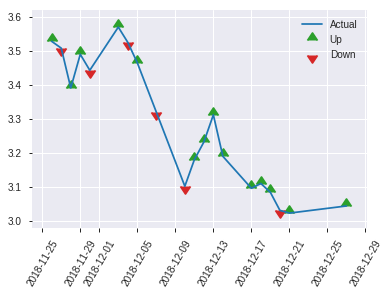


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21025421149431875
RMSE: 0.45853485308569375
LogLoss: 0.606957154018007
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 340.1862737963396
Residual deviance: 299.8368340848954
AIC: 401.8368340848954
AUC: 0.7272480672724807
pr_auc: 0.6046581917161399
Gini: 0.4544961345449614
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31562036061829896: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   93   0.637    (93.0/146.0)
1      5    96   0.0495   (5.0/101.0)
Total  58   189  0.3968   (98.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31562      0.662069  188
max f2                       0.265296     0.818182  200
max f0point5                 0.659006     0.615616  57
max accuracy                 0.659006     0.688259  57
max precision                0.948161     1         0
max recall                   0.169401     1         232
max specificity              0.948161     1         0
max absolute_mcc             0.31562      0.363615  188
max min_per_class_accuracy   0.524588     0.633663  109
max mean_per_class_accuracy  0.366636     0.668147  170

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.893832           1.63036   1.63036            0.666667         0.91361   0.666667                    0.91361             0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.89002            1.22277   1.46733            0.5              0.892527  0.6                         0.905177            0.00990099      0.029703                   22.2772   46.7327
    3        0.0323887                   0.87057            1.63036   1.52847            0.666667         0.880052  0.625                       0.895755            0.019802        0.049505                   63.0363   52.8465
    4        0.0404858                   0.858622           1.22277   1.46733            0.5              0.862422  0.6                         0.889089            0.00990099      0.0594059                  22.2772   46.7327
    5        0.0526316                   0.844141           2.44554   1.69307            1                0.851407  0.692308                    0.880393            0.029703        0.0891089                  144.554   69.3069
    6        0.101215                    0.75326            1.83416   1.76079            0.75             0.788785  0.72                        0.836421            0.0891089       0.178218                   83.4158   76.0792
    7        0.149798                    0.712447           1.63036   1.71849            0.666667         0.735094  0.702703                    0.803558            0.0792079       0.257426                   63.0363   71.8491
    8        0.202429                    0.679623           1.69307   1.71188            0.692308         0.693859  0.7                         0.775036            0.0891089       0.346535                   69.3069   71.1881
    9        0.299595                    0.609808           1.32467   1.5863             0.541667         0.644601  0.648649                    0.732733            0.128713        0.475248                   32.467    58.6299
    10       0.40081                     0.553159           0.880396  1.40804            0.36             0.58033   0.575758                    0.694247            0.0891089       0.564356                   -11.9604  40.8041
    11       0.502024                    0.465157           0.880396  1.30166            0.36             0.508986  0.532258                    0.656896            0.0891089       0.653465                   -11.9604  30.1661
    12       0.59919                     0.409019           1.12087   1.27234            0.458333         0.436171  0.52027                     0.621103            0.108911        0.762376                   12.0875   27.2344
    13       0.700405                    0.363555           1.27168   1.27225            0.52             0.385305  0.520231                    0.587028            0.128713        0.891089                   27.1683   27.2249
    14       0.797571                    0.282112           0.713284  1.20415            0.291667         0.32943   0.492386                    0.555646            0.0693069       0.960396                   -28.6716  20.4151
    15       0.898785                    0.207328           0.195644  1.09058            0.08             0.238592  0.445946                    0.519941            0.019802        0.980198                   -80.4356  9.05807
    16       1                           0.0106452          0.195644  1                  0.08             0.146723  0.408907                    0.482166         

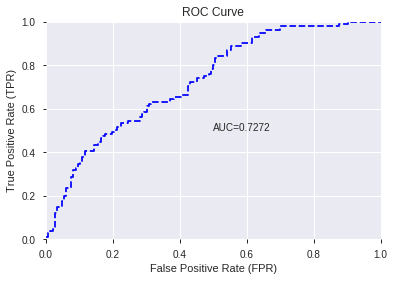

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


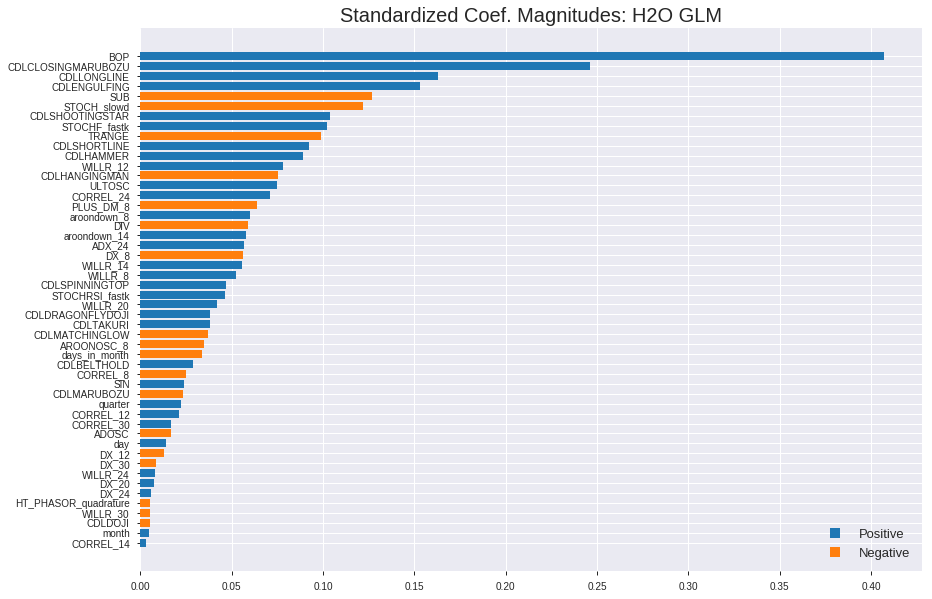

'log_likelihood'
--2019-08-26 14:15:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_141457_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_141457_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLENGULFING',
 'SUB',
 'STOCH_slowd',
 'CDLSHOOTINGSTAR',
 'STOCHF_fastk',
 'TRANGE',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'WILLR_12',
 'CDLHANGINGMAN',
 'ULTOSC',
 'CORREL_24',
 'PLUS_DM_8',
 'aroondown_8',
 'DIV',
 'aroondown_14',
 'ADX_24',
 'DX_8',
 'WILLR_14',
 'WILLR_8',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'WILLR_20',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'AROONOSC_8',
 'days_in_month',
 'CDLBELTHOLD',
 'CORREL_8',
 'SIN',
 'CDLMARUBOZU',
 'quarter',
 'CORREL_12',
 'CORREL_30',
 'ADOSC',
 'day',
 'DX_12',
 'DX_30',
 'WILLR_24',
 'DX_20',
 'DX_24',
 'HT_PHASOR_quadrature',
 'WILLR_30',
 'CDLDOJI',
 'month',
 'CORREL_14']

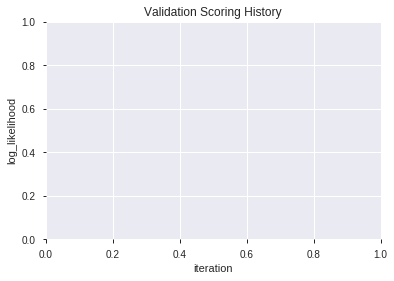

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_141508_model_5  0.745219  0.619918              0.341347  0.466888  0.217985
1  XGBoost_grid_1_AutoML_20190826_141508_model_6  0.744677  0.603473              0.332226  0.457726  0.209513
2  XGBoost_grid_1_AutoML_20190826_141508_model_3  0.735861  0.602953              0.323071  0.458077  0.209834
3               XGBoost_3_AutoML_20190826_141508  0.732538  0.604713              0.345517  0.458688  0.210395
4  XGBoost_grid_1_AutoML_20190826_141508_model_1  0.730774  0.609604              0.342093  0.461522  0.213003
5  XGBoost_grid_1_AutoML_20190826_141508_model_7  0.729147  0.620263              0.334497  0.466706  0.217814
6  XGBoost_grid_1_AutoML_20190826_141508_model_4  0.723179  0.618519              0.339821  0.465229  0.216438
7               XGBoost_1_AutoML_20190826_141508  0.720806  0.623204              0.345517  0.467502  0.218558
8               XGBoost_2_AutoML_20190826_141508  0.719924  0.617597              0.357690  0.465412  0.216609
9  XGBoost_grid_1_AutoML_20190826_141508_model_2  0.716737  0.617690              0.329547  0.465411  0.216607

variable  relative_importance  scaled_importance  percentage
0                    BOP          2615.398438           1.000000    0.108588
1                    day           955.269775           0.365248    0.039661
2                   DX_8           922.978516           0.352902    0.038321
3                 ADX_24           872.562195           0.333625    0.036228
4                    DIV           870.397888           0.332797    0.036138
5           STOCHF_fastk           841.214111           0.321639    0.034926
6              PLUS_DM_8           797.316528           0.304855    0.033103
7                    SUB           788.388306           0.301441    0.032733
8            STOCH_slowd           788.005066           0.301294    0.032717
9                 TRANGE           777.976807           0.297460    0.032301
10               WILLR_8           773.849426           0.295882    0.032129
11              CORREL_8           742.164124           0.283767    0.030814
12                 DX_12           704.356201           0.269311    0.029244
13             CORREL_30           704.053467           0.269195    0.029231
14             CORREL_14           697.266663           0.266601    0.028950
15             CORREL_12           639.080872           0.244353    0.026534
16                   SIN           630.340576           0.241011    0.026171
17                 ADOSC           615.931274           0.235502    0.025573
18                 month           581.228516           0.222233    0.024132
19              WILLR_12           546.648987           0.209012    0.022696
20                ULTOSC           544.950867           0.208362    0.022626
21  HT_PHASOR_quadrature           507.708954           0.194123    0.021079
22        STOCHRSI_fastk           493.595673           0.188727    0.020493
23                 DX_20           481.902435           0.184256    0.020008
24             CORREL_24           469.364685           0.179462    0.019487
25                 DX_30           441.762238           0.168908    0.018341
26                 DX_24           424.180664           0.162186    0.017611
27              WILLR_20           423.559509           0.161948    0.017586
28              WILLR_30           380.968994           0.145664    0.015817
29              WILLR_24           374.021393           0.143007    0.015529
30           aroondown_8           356.440765           0.136285    0.014799
31            AROONOSC_8           314.390289           0.120207    0.013053
32              WILLR_14           303.638977           0.116097    0.012607
33    CDLCLOSINGMARUBOZU           283.882263           0.108543    0.011786
34          aroondown_14           276.263336           0.105630    0.011470
35           CDLLONGLINE           203.094025           0.077653    0.008432
36         days_in_month           159.781204           0.061092    0.006634
37               quarter           158.609207           0.060644    0.006585
38          CDLSHORTLINE           149.043274           0.056987    0.006188
39        CDLSPINNINGTOP            96.556839           0.036919    0.004009
40          CDLENGULFING            68.280388           0.026107    0.002835
41             CDLHAMMER            64.389046           0.024619    0.002673
42       CDLSHOOTINGSTAR            61.497295           0.023514    0.002553
43           CDLBELTHOLD            60.219368           0.023025    0.002500
44               CDLDOJI            55.243263           0.021122    0.002294
45      CDLDRAGONFLYDOJI            19.918690           0.007616    0.000827
46         CDLHANGINGMAN            19.901192           0.007609    0.000826
47        CDLMATCHINGLOW            14.157973           0.005413    0.000588
48           CDLMARUBOZU            10.722506           0.004100    0.000445
49             CDLTAKURI             3.110778           0.001189    0.000129

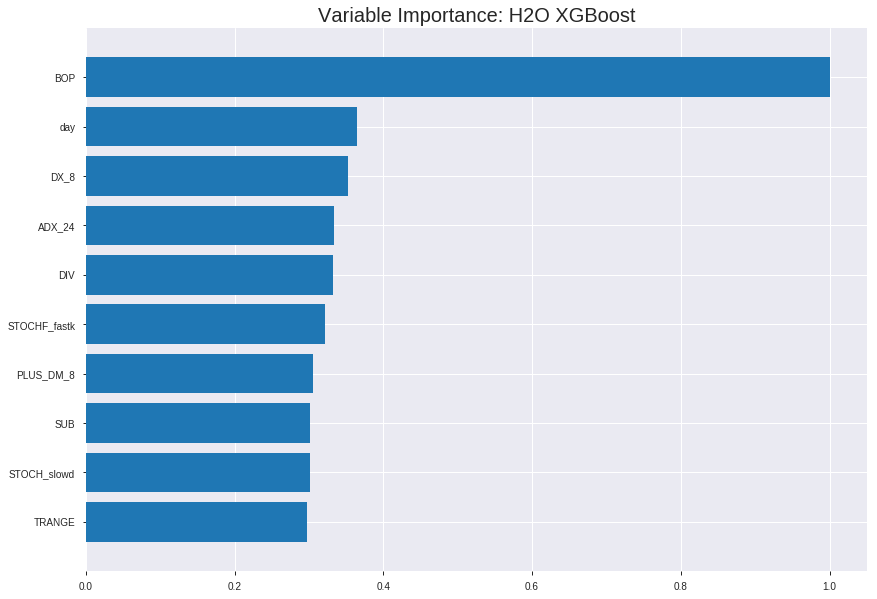

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_141508_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.02849253093270636
RMSE: 0.16879730724364758
LogLoss: 0.16666559797845248
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988066825775656
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5115189552307129: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      884  0    0        (0.0/884.0)
1      0    838  0        (0.0/838.0)
Total  884  838  0        (0.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.511519     1        198
max f2                       0.511519     1        198
max f0point5                 0.511519     1        198
max accuracy                 0.511519     1        198
max precision                0.960939     1        0
max recall                   0.511519     1        198
max specificity              0.960939     1        0
max absolute_mcc             0.511519     1        198
max min_per_class_accuracy   0.511519     1        198
max mean_per_class_accuracy  0.511519     1        198

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010453                    0.946135           2.05489  2.05489            1                0.94957    1                           0.94957             0.0214797       0.0214797                  105.489  105.489
    2        0.0203252                   0.938629           2.05489  2.05489            1                0.942058   1                           0.945922            0.0202864       0.0417661                  105.489  105.489
    3        0.0301974                   0.935242           2.05489  2.05489            1                0.936922   1                           0.942979            0.0202864       0.0620525                  105.489  105.489
    4        0.0400697                   0.930404           2.05489  2.05489            1                0.932179   1                           0.940318            0.0202864       0.0823389                  105.489  105.489
    5        0.0505226                   0.927538           2.05489  2.05489            1                0.928991   1                           0.937975            0.0214797       0.103819                   105.489  105.489
    6        0.100465                    0.913141           2.05489  2.05489            1                0.920334   1                           0.929206            0.102625        0.206444                   105.489  105.489
    7        0.150407                    0.896422           2.05489  2.05489            1                0.904779   1                           0.921095            0.102625        0.309069                   105.489  105.489
    8        0.200348                    0.879379           2.05489  2.05489            1                0.887781   1                           0.91279             0.102625        0.411695                   105.489  105.489
    9        0.300232                    0.843267           2.05489  2.05489            1                0.860976   1                           0.895552            0.205251        0.616945                   105.489  105.489
    10       0.400116                    0.783823           2.05489  2.05489            1                0.816983   1                           0.875938            0.205251        0.822196                   105.489  105.489
    11       0.5                         0.337447           1.78011  2                  0.866279         0.673087   0.973287                    0.835415            0.177804        1                          78.011   100
    12       0.599884                    0.206677           0        1.66699            0                0.256095   0.811229                    0.738955            0               1                          -100     66.6989
    13       0.699768                    0.149744           0        1.42905            0                0.177914   0.695436                    0.658873            0               1                          -100     42.9046
    14       0.799652                    0.110052           0        1.25054            0                0.128736   0.608569                    0.592654            0               1                          -100     25.0545
    15       0.899535                    0.0718068          0        1.11168            0                0.0905236  0.540994                    0.536898            0               1                          -100     11.1685
    16       1                           0.0343445          0        1                  0                0.0558434  0.486643                    0.488569            0               1 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.21043984345803404
RMSE: 0.45873722702439795
LogLoss: 0.6104545107702948
Mean Per-Class Error: 0.31875662076271194
AUC: 0.7337046477754238
pr_auc: 0.7101272108261448
Gini: 0.46740929555084754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3590071201324463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  132  0.5593   (132.0/236.0)
1      28   228  0.1094   (28.0/256.0)
Total  132  360  0.3252   (160.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359007     0.74026   288
max f2                       0.137931     0.863821  367
max f0point5                 0.531364     0.692365  213
max accuracy                 0.531364     0.682927  213
max precision                0.945563     1         0
max recall                   0.121684     1         373
max specificity              0.945563     1         0
max absolute_mcc             0.359007     0.373562  288
max min_per_class_accuracy   0.569887     0.671875  196
max mean_per_class_accuracy  0.531364     0.681243  213

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.930356           1.5375    1.5375             0.8              0.942225  0.8                         0.942225            0.015625        0.015625                   53.75     53.75
    2        0.0203252                   0.915051           1.15312   1.34531            0.6              0.920787  0.7                         0.931506            0.0117188       0.0273438                  15.3125   34.5312
    3        0.0304878                   0.907461           1.92187   1.5375             1                0.912829  0.8                         0.92528             0.0195312       0.046875                   92.1875   53.75
    4        0.0406504                   0.903031           1.5375    1.5375             0.8              0.904746  0.8                         0.920147            0.015625        0.0625                     53.75     53.75
    5        0.050813                    0.896812           1.5375    1.5375             0.8              0.899512  0.8                         0.91602             0.015625        0.078125                   53.75     53.75
    6        0.101626                    0.851775           1.38375   1.46062            0.72             0.870944  0.76                        0.893482            0.0703125       0.148438                   38.375    46.0625
    7        0.150407                    0.814794           1.60156   1.50633            0.833333         0.836228  0.783784                    0.874913            0.078125        0.226562                   60.1562   50.6334
    8        0.20122                     0.7778             1.61437   1.53362            0.84             0.794088  0.79798                     0.854503            0.0820312       0.308594                   61.4375   53.3617
    9        0.300813                    0.733182           1.17666   1.41543            0.612245         0.757281  0.736486                    0.822314            0.117188        0.425781                   17.6658   41.5435
    10       0.400407                    0.640066           1.29432   1.38531            0.673469         0.690373  0.720812                    0.789497            0.128906        0.554688                   29.4324   38.5311
    11       0.5                         0.574814           1.09821   1.32812            0.571429         0.606554  0.691057                    0.753057            0.109375        0.664062                   9.82143   32.8125
    12       0.599593                    0.503825           0.941327  1.26388            0.489796         0.533603  0.657627                    0.716605            0.09375         0.757812                   -5.86735  26.3877
    13       0.699187                    0.402436           0.902105  1.21235            0.469388         0.448784  0.630814                    0.678456            0.0898438       0.847656                   -9.78954  21.2346
    14       0.79878                     0.281653           0.705995  1.14921            0.367347         0.341752  0.597964                    0.636475            0.0703125       0.917969                   -29.4005  14.9213
    15       0.898374                    0.158765           0.627551  1.09138            0.326531         0.223437  0.567873                    0.590686            0.0625          0.980469                   -37.2449  9.13815
    16       1                           0.0486702          0.192187  1                  0.1              0.106944  0.520325                    0.541525            0.019


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:15:16  3.294 sec   0                  0.5              0.693147            0.5             0                  1                0.513357                         0.5                0.693147              0.5               0                    1                  0.479675
    2019-08-26 14:15:16  3.545 sec   5                  0.437392         0.574561            0.976014        0.972037           2.05489          0.0783972                        0.483283           0.659999              0.693815          0.671239             1.5375             0.347561
    2019-08-26 14:15:16  3.785 sec   10                 0.383525         0.481436            0.9952          0.994184           2.05489          0.0301974                        0.472105           0.637694              0.711848          0.681065             1.15312            0.351626
    2019-08-26 14:15:17  4.008 sec   15                 0.342415         0.414432            0.997935        0.996843           2.05489          0.0209059                        0.465231           0.623471              0.719702          0.690388             1.15312            0.339431
    2019-08-26 14:15:17  4.228 sec   20                 0.308827         0.362126            0.99943         0.998224           2.05489          0.0121951                        0.460329           0.612992              0.7271            0.70494              1.5375             0.333333
    2019-08-26 14:15:17  4.473 sec   25                 0.278221         0.316523            0.999779        0.998578           2.05489          0.00522648                       0.458924           0.609999              0.727738          0.698148             1.5375             0.335366
    2019-08-26 14:15:17  4.694 sec   30                 0.254371         0.281734            0.999918        0.996335           2.05489          0.00464576                       0.458817           0.609351              0.726521          0.699963             1.15312            0.341463
    2019-08-26 14:15:17  4.942 sec   35                 0.232152         0.250164            0.999975        0.998781           2.05489          0.00116144                       0.457672           0.6075                0.728772          0.696437             1.15312            0.331301
    2019-08-26 14:15:18  5.199 sec   40                 0.21262          0.223573            0.999996        0.998802           2.05489          0.00058072                       0.456651           0.604925              0.732827          0.704251             1.15312            0.331301
    2019-08-26 14:15:18  5.472 sec   45                 0.196201         0.201618            1               0.998807           2.05489          0                                0.456214           0.604369              0.735881          0.708871             1.5375             0.327236
    2019-08-26 14:15:18  5.739 sec   50                 0.181223         0.182479            1               0.998807           2.05489          0                                0.457644           0.60783               0.734598          0.708965             1.5375             0.327236
    2019-08-26 14:15:19  6.013 sec   55                 0.168797         0.166666            1               0.998807           2.05489          0                                0.458737           0.610455              0.733705          0

Variable Importances: 


variable          relative_importance    scaled_importance      percentage
----------------  ---------------------  ---------------------  ----------------------
BOP               2615.3984375           1.0                    0.10858771191075589
day               955.269775390625       0.3652482779272996     0.039661474779469304
DX_8              922.978515625          0.352901685032455      0.03832078650712454
ADX_24            872.5621948242188      0.33362495836706285    0.03622757086540055
DIV               870.3978881835938      0.332797433730819      0.03613771185860105
---               ---                    ---                    ---
CDLDRAGONFLYDOJI  19.918689727783203     0.007615929352172829   0.0008269963424264128
CDLHANGINGMAN     19.90119171142578      0.007609238969511995   0.0008262698490814654
CDLMATCHINGLOW    14.157973289489746     0.005413314119367232   0.0005878193940762761
CDLMARUBOZU       10.722505569458008     0.004099759874333873   0.00044518354413744337
CDLTAKURI         3.1107778549194336     0.0011894087762371517  0.00012915517753816453


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7125506072874493)

('F1', 0.662020905923345)

('auc', 0.7452190424521904)

('logloss', 0.619918441947934)

('mean_per_class_error', 0.3106605181066052)

('rmse', 0.46688844735605867)

('mse', 0.21798482227455118)

xgboost prediction progress: |████████████████████████████████████████████| 100%


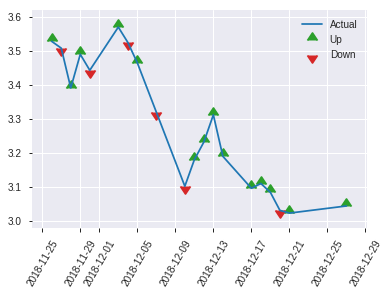


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21798482227455118
RMSE: 0.46688844735605867
LogLoss: 0.619918441947934
Mean Per-Class Error: 0.3106605181066052
AUC: 0.7452190424521904
pr_auc: 0.6672665686005141
Gini: 0.4904380849043808
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28087830543518066: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   91   0.6233   (91.0/146.0)
1      6    95   0.0594   (6.0/101.0)
Total  61   186  0.3927   (97.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280878     0.662021  185
max f2                       0.195112     0.819536  199
max f0point5                 0.733845     0.656836  67
max accuracy                 0.733845     0.712551  67
max precision                0.917413     1         0
max recall                   0.0480607    1         246
max specificity              0.917413     1         0
max absolute_mcc             0.733845     0.39075   67
max min_per_class_accuracy   0.595662     0.650685  116
max mean_per_class_accuracy  0.682934     0.689339  88

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.897361           2.44554    2.44554            1                0.907797   1                           0.907797            0.029703        0.029703                   144.554   144.554
    2        0.0202429                   0.892015           1.22277    1.95644            0.5              0.895782   0.8                         0.902991            0.00990099      0.039604                   22.2772   95.6436
    3        0.0323887                   0.883348           2.44554    2.13985            1                0.88888    0.875                       0.897699            0.029703        0.0693069                  144.554   113.985
    4        0.0404858                   0.87946            2.44554    2.20099            1                0.880433   0.9                         0.894246            0.019802        0.0891089                  144.554   120.099
    5        0.0526316                   0.874709           1.63036    2.06931            0.666667         0.877383   0.846154                    0.890355            0.019802        0.108911                   63.0363   106.931
    6        0.101215                    0.858557           2.03795    2.05426            0.833333         0.867046   0.84                        0.879167            0.0990099       0.207921                   103.795   105.426
    7        0.149798                    0.819256           1.42657    1.85068            0.583333         0.83527    0.756757                    0.86493             0.0693069       0.277228                   42.6568   85.0682
    8        0.202429                    0.785289           1.88119    1.85861            0.769231         0.803847   0.76                        0.849048            0.0990099       0.376238                   88.1188   85.8614
    9        0.299595                    0.707937           1.22277    1.65239            0.5              0.746142   0.675676                    0.815673            0.118812        0.49505                    22.2772   65.2395
    10       0.40081                     0.64902            1.07604    1.50685            0.44             0.682075   0.616162                    0.781936            0.108911        0.60396                    7.60396   50.6851
    11       0.502024                    0.578425           0.684752   1.34111            0.28             0.612876   0.548387                    0.747851            0.0693069       0.673267                   -31.5248  34.1105
    12       0.59919                     0.468036           0.917079   1.27234            0.375            0.509615   0.52027                     0.709219            0.0891089       0.762376                   -8.29208  27.2344
    13       0.700405                    0.326531           1.17386    1.25811            0.48             0.391137   0.514451                    0.663253            0.118812        0.881188                   17.3861   25.8113
    14       0.797571                    0.219325           0.917079   1.21657            0.375            0.275735   0.497462                    0.616043            0.0891089       0.970297                   -8.29208  21.6565
    15       0.898785                    0.105715           0.0978218  1.09058            0.04             0.15637    0.445946                    0.564278            0.00990099      0.980198                   -90.2178  9.05807
    16       1                           0.0480607          0.195644   1                  0.08             0.0779152  0.408907 

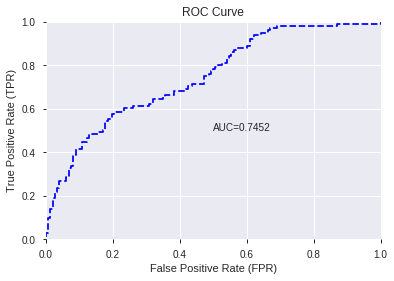

This function is available for GLM models only


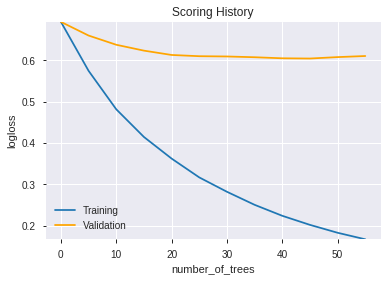

--2019-08-26 14:15:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_141508_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_141508_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'day',
 'DX_8',
 'ADX_24',
 'DIV',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'SUB',
 'STOCH_slowd',
 'TRANGE',
 'WILLR_8',
 'CORREL_8',
 'DX_12',
 'CORREL_30',
 'CORREL_14',
 'CORREL_12',
 'SIN',
 'ADOSC',
 'month',
 'WILLR_12',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastk',
 'DX_20',
 'CORREL_24',
 'DX_30',
 'DX_24',
 'WILLR_20',
 'WILLR_30',
 'WILLR_24',
 'aroondown_8',
 'AROONOSC_8',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'aroondown_14',
 'CDLLONGLINE',
 'days_in_month',
 'quarter',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLBELTHOLD',
 'CDLDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'CDLMARUBOZU',
 'CDLTAKURI']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


59

['BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_141532_model_5  0.755663  0.664183              0.312458  0.477137  0.227660
1  DeepLearning_grid_1_AutoML_20190826_141532_model_3  0.755323  0.682694              0.294215  0.479432  0.229855
2  DeepLearning_grid_1_AutoML_20190826_141532_model_8  0.751458  0.618562              0.331446  0.462040  0.213481
3  DeepLearning_grid_1_AutoML_20190826_141532_model_9  0.749830  0.606408              0.353520  0.458138  0.209890
4  DeepLearning_grid_1_AutoML_20190826_141532_model_6  0.742167  0.654834              0.321613  0.476733  0.227275
5  DeepLearning_grid_1_AutoML_20190826_141532_model_7  0.732334  0.710589              0.353520  0.476325  0.226886
6               DeepLearning_1_AutoML_20190826_141532  0.727723  0.722000              0.336023  0.500244  0.250245
7  DeepLearning_grid_1_AutoML_20190826_141532_model_4  0.727248  0.764974              0.353181  0.492629  0.242683
8  DeepLearning_grid_1_AutoML_20190826_141532_model_1  0.726027  0.850880              0.344432  0.496357  0.246371
9  DeepLearning_grid_1_AutoML_20190826_141532_model_2  0.701139  0.725509              0.358470  0.495799  0.245816

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.036570
1   CDLCLOSINGMARUBOZU             0.818280           0.818280    0.029925
2         CDLSHORTLINE             0.737347           0.737347    0.026965
3                  SUB             0.633526           0.633526    0.023168
4         CDLENGULFING             0.606961           0.606961    0.022197
5          CDLLONGLINE             0.569446           0.569446    0.020825
6                  DIV             0.551155           0.551155    0.020156
7               TRANGE             0.547994           0.547994    0.020040
8         STOCHF_fastk             0.533732           0.533732    0.019519
9       STOCHRSI_fastd             0.528959           0.528959    0.019344
10       CDLHANGINGMAN             0.518418           0.518418    0.018959
11      STOCHRSI_fastk             0.491880           0.491880    0.017988
12               CCI_8             0.488563           0.488563    0.017867
13            WILLR_12             0.483980           0.483980    0.017699
14         CDLBELTHOLD             0.475297           0.475297    0.017382
15              ULTOSC             0.468255           0.468255    0.017124
16         STOCH_slowk             0.465857           0.465857    0.017036
17        STOCHF_fastd             0.464083           0.464083    0.016972
18          MINUS_DM_8             0.459073           0.459073    0.016788
19          MINUS_DI_8             0.458561           0.458561    0.016770
20               MOM_8             0.448733           0.448733    0.016410
21             WILLR_8             0.446999           0.446999    0.016347
22               ADOSC             0.444215           0.444215    0.016245
23            WILLR_14             0.443998           0.443998    0.016237
24          ROCR100_14             0.437249           0.437249    0.015990
25            WILLR_20             0.437152           0.437152    0.015987
26         CDLMARUBOZU             0.430132           0.430132    0.015730
27           ROCR100_8             0.428383           0.428383    0.015666
28            WILLR_30             0.427236           0.427236    0.015624
29              CCI_14             0.425635           0.425635    0.015566
30              CCI_24             0.424293           0.424293    0.015516
31              CMO_30             0.422429           0.422429    0.015448
32               RSI_8             0.420864           0.420864    0.015391
33             ROCP_12             0.419880           0.419880    0.015355
34              MOM_20             0.419211           0.419211    0.015331
35             ROCR_14             0.417060           0.417060    0.015252
36            WILLR_24             0.415405           0.415405    0.015191
37              MOM_12             0.415263           0.415263    0.015186
38              ROCP_8             0.414003           0.414003    0.015140
39              ROC_14             0.413074           0.413074    0.015106
40              RSI_30             0.412416           0.412416    0.015082
41               CMO_8             0.408225           0.408225    0.014929
42              CCI_12             0.407802           0.407802    0.014913
43              CCI_20             0.403769           0.403769    0.014766
44               ROC_8             0.403595           0.403595    0.014760
45              ROCR_8             0.403210           0.403210    0.014745
46             ROCP_14             0.399460           0.399460    0.014608
47              RSI_24             0.399043           0.399043    0.014593
48             ROCR_12             0.398346           0.398346    0.014568
49              ROC_12             0.395778           0.395778    0.014474
50              CMO_24             0.394389           0.394389    0.014423
51              RSI_20             0.390728           0.390728    0.014289
52          ROCR100_12             0.38

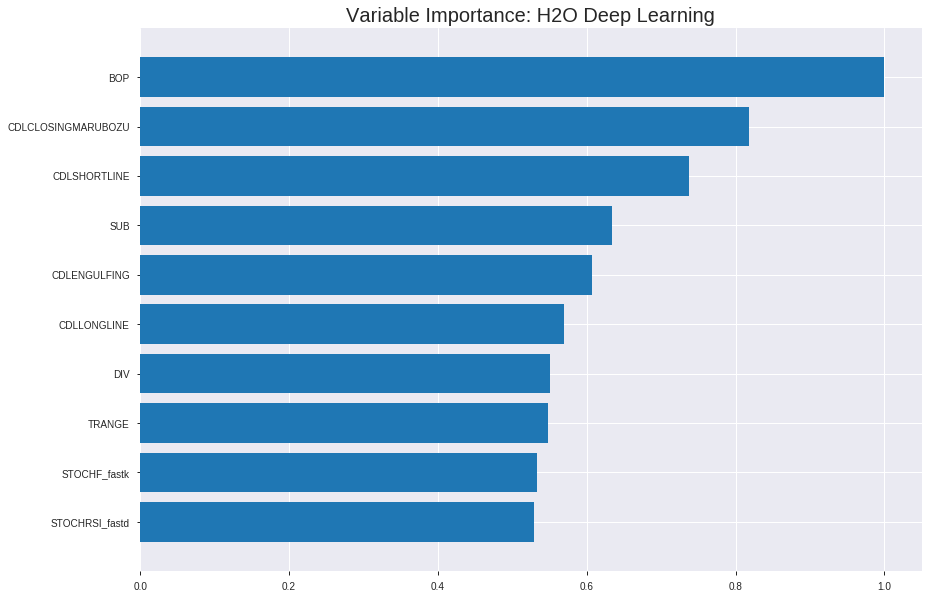

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_141532_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18931056801528803
RMSE: 0.4350983429240889
LogLoss: 0.5558869718961134
Mean Per-Class Error: 0.29137733668830124
AUC: 0.7913064665925117
pr_auc: 0.7741027068964912
Gini: 0.5826129331850234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44061616635636697: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      425  459   0.5192   (459.0/884.0)
1      87   751   0.1038   (87.0/838.0)
Total  512  1210  0.3171   (546.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440616     0.733398  255
max f2                       0.287663     0.850683  308
max f0point5                 0.658946     0.71188   147
max accuracy                 0.615346     0.709059  168
max precision                0.996497     1         0
max recall                   0.0122625    1         395
max specificity              0.996497     1         0
max absolute_mcc             0.534997     0.420671  209
max min_per_class_accuracy   0.576275     0.702864  188
max mean_per_class_accuracy  0.534997     0.708623  209

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 54.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.973539           2.05489    2.05489            1                0.985514   1                           0.985514            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.965011           1.93402    1.99618            0.941176         0.969522   0.971429                    0.977747            0.0190931       0.0405728                  93.4017   99.6181
    3        0.0301974                   0.954921           1.93402    1.97586            0.941176         0.960591   0.961538                    0.972138            0.0190931       0.0596659                  93.4017   97.5858
    4        0.0400697                   0.946553           1.69226    1.90599            0.823529         0.951071   0.927536                    0.966948            0.0167064       0.0763723                  69.2264   90.5987
    5        0.0505226                   0.936685           1.71241    1.86594            0.833333         0.941091   0.908046                    0.961598            0.0178998       0.0942721                  71.2411   86.5937
    6        0.100465                    0.889072           1.74427    1.80545            0.848837         0.914089   0.878613                    0.937981            0.0871122       0.181384                   74.4269   80.5455
    7        0.150407                    0.847124           1.67259    1.76134            0.813953         0.865706   0.857143                    0.913982            0.0835322       0.264916                   67.2587   76.1337
    8        0.200348                    0.800256           1.6009     1.72134            0.77907          0.826609   0.837681                    0.892202            0.0799523       0.344869                   60.0905   72.1345
    9        0.300232                    0.697803           1.44559    1.62961            0.703488         0.747199   0.793037                    0.843961            0.144391        0.48926                    44.5593   62.9605
    10       0.400116                    0.630039           1.18276    1.51806            0.575581         0.662383   0.738752                    0.798633            0.118138        0.607399                   18.2758   51.8056
    11       0.5                         0.572121           1.05134    1.42482            0.511628         0.597643   0.69338                     0.758481            0.105012        0.712411                   5.13404   42.4821
    12       0.599884                    0.516752           0.967711   1.34871            0.47093          0.543591   0.656341                    0.722701            0.0966587       0.809069                   -3.22889  34.871
    13       0.699768                    0.442413           0.812399   1.27216            0.395349         0.482162   0.619087                    0.688367            0.0811456       0.890215                   -18.7601  27.2158
    14       0.799652                    0.314232           0.669035   1.19682            0.325581         0.385385   0.582426                    0.650522            0.0668258       0.957041                   -33.0965  19.6822
    15       0.899535                    0.101061           0.334517   1.10107            0.162791         0.205192   0.53583                     0.601072            0.0334129       0.990453                   -66.5483  10.1072
    16       1                           0.00260135         0.0950239  1                  0.0462428        0.0482899  0.486643  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21181436667632647
RMSE: 0.4602329482732918
LogLoss: 0.6176502169520972
Mean Per-Class Error: 0.29922537076271194
AUC: 0.7406316207627118
pr_auc: 0.7350914656580129
Gini: 0.48126324152542366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5093272760368078: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  102  0.4322   (102.0/236.0)
1      49   207  0.1914   (49.0/256.0)
Total  183  309  0.3069   (151.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509327     0.732743  241
max f2                       0.0765259    0.852843  379
max f0point5                 0.545479     0.708576  216
max accuracy                 0.545479     0.703252  216
max precision                0.966431     1         0
max recall                   0.0404205    1         390
max specificity              0.966431     1         0
max absolute_mcc             0.545479     0.405105  216
max min_per_class_accuracy   0.570227     0.690678  195
max mean_per_class_accuracy  0.545479     0.700775  216

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 56.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.960243           1.92187   1.92187            1                0.963352   1                           0.963352            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.950563           1.92187   1.92187            1                0.957488   1                           0.96042             0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.940853           1.15312   1.66562            0.6              0.946799   0.866667                    0.95588             0.0117188       0.0507812                  15.3125   66.5625
    4        0.0406504                   0.930599           1.92187   1.72969            1                0.936173   0.9                         0.950953            0.0195312       0.0703125                  92.1875   72.9687
    5        0.050813                    0.92269            0.76875   1.5375             0.4              0.92699    0.8                         0.94616             0.0078125       0.078125                   -23.125   53.75
    6        0.101626                    0.873099           1.5375    1.5375             0.8              0.899261   0.8                         0.922711            0.078125        0.15625                    53.75     53.75
    7        0.150407                    0.844452           1.52148   1.53231            0.791667         0.859732   0.797297                    0.902285            0.0742188       0.230469                   52.1484   53.2306
    8        0.20122                     0.805032           1.46062   1.5142             0.76             0.824738   0.787879                    0.882703            0.0742188       0.304688                   46.0625   51.4205
    9        0.300813                    0.699302           1.33355   1.45439            0.693878         0.74513    0.756757                    0.837155            0.132812        0.4375                     33.3546   45.4392
    10       0.400407                    0.633566           1.2551    1.40482            0.653061         0.669664   0.730964                    0.795495            0.125           0.5625                     25.5102   40.4822
    11       0.5                         0.572223           1.17666   1.35937            0.612245         0.604253   0.707317                    0.757402            0.117188        0.679688                   17.6658   35.9375
    12       0.599593                    0.52494            0.941327  1.28994            0.489796         0.55011    0.671186                    0.72297             0.09375         0.773438                   -5.86735  28.9936
    13       0.699187                    0.476191           0.745217  1.21235            0.387755         0.500764   0.630814                    0.691319            0.0742188       0.847656                   -25.4783  21.2346
    14       0.79878                     0.382848           0.627551  1.13943            0.326531         0.43126    0.592875                    0.658894            0.0625          0.910156                   -37.2449  13.9432
    15       0.898374                    0.188009           0.549107  1.07399            0.285714         0.293757   0.558824                    0.618415            0.0546875       0.964844                   -45.0893  7.3989
    16       1                           0.0139301          0.345937  1                  0.18             0.0923386  0.520325                    0.56


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:19:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:19:11  1 min 38.179 sec  1221 obs/sec      1.29501   1             2230       0.444503         0.576947            0.209104       0.773768        0.745971           1.82657          0.321138                         0.471727           0.636146              0.108422         0.721125          0.721284             1.5375             0.373984
    2019-08-26 14:19:19  1 min 46.224 sec  1954 obs/sec      10.3664   8             17851      0.435098         0.555887            0.242217       0.791306        0.774103           2.05489          0.317073                         0.460233           0.61765               0.15134          0.740632          0.735091             1.92187            0.306911
    2019-08-26 14:19:28  1 min 54.429 sec  2155 obs/sec      20.7898   16            35800      0.433001         0.545798            0.249504       0.803184        0.789343           2.05489          0.306039                         0.467453           0.631062              0.124504         0.725842          0.716414             1.5375             0.378049
    2019-08-26 14:19:35  2 min  2.194 sec  2271 obs/sec      31.1951   24            53718      0.419926         0.518473            0.294146       0.813698        0.801607           2.05489          0.279907                         0.461572           0.627112              0.146396         0.736974          0.726031             1.5375             0.337398
    2019-08-26 14:19:43  2 min  9.918 sec  2338 obs/sec      41.6161   32            71663      0.421119         0.51797             0.290127       0.818425        0.811853           2.05489          0.278746                         0.4657             0.640596              0.131057         0.723691          0.711872             1.15312            0.398374
    2019-08-26 14:19:51  2 min 17.494 sec  2389 obs/sec      52.054    40            89637      0.40855          0.493783            0.331872       0.837876        0.831396           2.05489          0.259001                         0.46657            0.640421              0.127809         0.726033          0.721052             1.5375             0.398374
    2019-08-26 14:19:51  2 min 18.259 sec  2387 obs/sec      52.054    40            89637      0.435098         0.555887            0.242217       0.791306        0.774103           2.05489          0.317073                         0.460233           0.61765               0.15134          0.740632          0.735091             1.92187            0.306911

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03657016542149966
CDLCLOSINGMARUBOZU  0.8182801008224487     0.8182801008224487   0.029924638648198373
CDLSHORTLINE        0.7373469471931458     0.7373469471931458   0.026964899831891116
SUB                 0.6335262060165405     0.6335262060165405   0.023168158152879963
CDLENGULFING        0.6069613695144653     0.6069613695144653   0.02219667768760398
---                 ---                    ---                  ---
MOM_14              0.3860188126564026     0.3860188126564026   0.01411677183465553
CMO_14              0.3848106563091278     0.3848106563091278   0.014072589357180657
CMO_12              0.38432052731513977    0.38432052731513977  0.014054665258792641
CMO_20              0.38328975439071655    0.38328975439071655  0.014016969722434481
RSI_14              0.3624500334262848     0.3624500334262848   0.013254857679427317


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7044534412955465)

('F1', 0.6718146718146718)

('auc', 0.7556625525566255)

('logloss', 0.6641826993203094)

('mean_per_class_error', 0.30832090058320905)

('rmse', 0.47713719136794014)

('mse', 0.22765989938648631)

deeplearning prediction progress: |███████████████████████████████████████| 100%


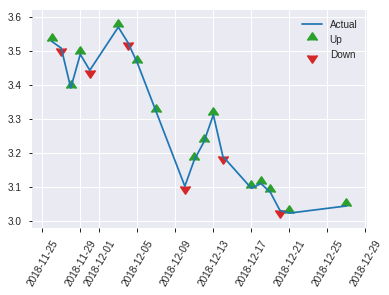


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22765989938648631
RMSE: 0.47713719136794014
LogLoss: 0.6641826993203094
Mean Per-Class Error: 0.30832090058320905
AUC: 0.7556625525566255
pr_auc: 0.633527281982633
Gini: 0.511325105113251
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5399860897733937: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   71   0.4863   (71.0/146.0)
1      14   87   0.1386   (14.0/101.0)
Total  89   158  0.3441   (85.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539986     0.671815  157
max f2                       0.329089     0.807504  208
max f0point5                 0.782736     0.647841  49
max accuracy                 0.782736     0.704453  49
max precision                0.801752     0.785714  41
max recall                   0.0870142    1         229
max specificity              0.994724     0.993151  0
max absolute_mcc             0.539986     0.384099  157
max min_per_class_accuracy   0.624007     0.664384  116
max mean_per_class_accuracy  0.606003     0.691679  124

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 57.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.974308           0.815182  0.815182           0.333333         0.983038   0.333333                    0.983038            0.00990099      0.00990099                 -18.4818  -18.4818
    2        0.0202429                   0.95975            2.44554   1.46733            1                0.970965   0.6                         0.978209            0.019802        0.029703                   144.554   46.7327
    3        0.0323887                   0.955666           1.63036   1.52847            0.666667         0.958454   0.625                       0.970801            0.019802        0.049505                   63.0363   52.8465
    4        0.0404858                   0.948041           1.22277   1.46733            0.5              0.951216   0.6                         0.966884            0.00990099      0.0594059                  22.2772   46.7327
    5        0.0526316                   0.942963           1.63036   1.50495            0.666667         0.945469   0.615385                    0.961942            0.019802        0.0792079                  63.0363   50.495
    6        0.101215                    0.894677           2.24175   1.85861            0.916667         0.924632   0.76                        0.944033            0.108911        0.188119                   124.175   85.8614
    7        0.149798                    0.83425            2.03795   1.91678            0.833333         0.867899   0.783784                    0.919341            0.0990099       0.287129                   103.795   91.6778
    8        0.202429                    0.782374           1.88119   1.90752            0.769231         0.803211   0.78                        0.889147            0.0990099       0.386139                   88.1188   90.7525
    9        0.299595                    0.710285           1.01898   1.61935            0.416667         0.748753   0.662162                    0.843614            0.0990099       0.485149                   1.89769   61.9347
    10       0.40081                     0.66418            1.17386   1.50685            0.48             0.690593   0.616162                    0.804972            0.118812        0.60396                    17.3861   50.6851
    11       0.502024                    0.610753           1.17386   1.43972            0.48             0.634187   0.58871                     0.77054             0.118812        0.722772                   17.3861   43.9716
    12       0.59919                     0.56186            0.917079  1.35496            0.375            0.584918   0.554054                    0.740439            0.0891089       0.811881                   -8.29208  35.4964
    13       0.700405                    0.504943           0.782574  1.27225            0.32             0.533867   0.520231                    0.710588            0.0792079       0.891089                   -21.7426  27.2249
    14       0.797571                    0.402154           0.509488  1.17932            0.208333         0.472441   0.482234                    0.681575            0.049505        0.940594                   -49.0512  17.9324
    15       0.898785                    0.11587            0.391287  1.09058            0.16             0.286431   0.445946                    0.637077            0.039604        0.980198                   -60.8713  9.05807
    16       1                           0.00925268         0.195644  1                  0.08             0.0644419  0.408907                   

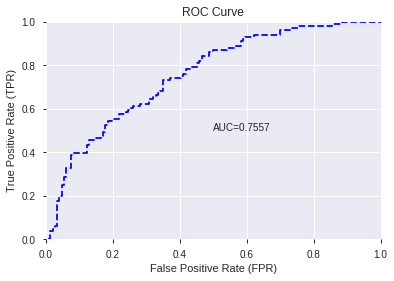

This function is available for GLM models only


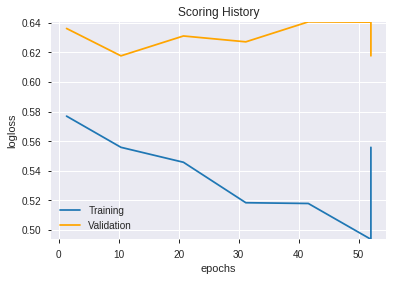

--2019-08-26 14:25:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_141532_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_141532_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'SUB',
 'CDLENGULFING',
 'CDLLONGLINE',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'CDLHANGINGMAN',
 'STOCHRSI_fastk',
 'CCI_8',
 'WILLR_12',
 'CDLBELTHOLD',
 'ULTOSC',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MINUS_DM_8',
 'MINUS_DI_8',
 'MOM_8',
 'WILLR_8',
 'ADOSC',
 'WILLR_14',
 'ROCR100_14',
 'WILLR_20',
 'CDLMARUBOZU',
 'ROCR100_8',
 'WILLR_30',
 'CCI_14',
 'CCI_24',
 'CMO_30',
 'RSI_8',
 'ROCP_12',
 'MOM_20',
 'ROCR_14',
 'WILLR_24',
 'MOM_12',
 'ROCP_8',
 'ROC_14',
 'RSI_30',
 'CMO_8',
 'CCI_12',
 'CCI_20',
 'ROC_8',
 'ROCR_8',
 'ROCP_14',
 'RSI_24',
 'ROCR_12',
 'ROC_12',
 'CMO_24',
 'RSI_20',
 'ROCR100_12',
 'RSI_12',
 'MOM_14',
 'CMO_14',
 'CMO_12',
 'CMO_20',
 'RSI_14']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_142537_model_1  0.741015  0.607743              0.332599  0.458327  0.210063

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.582002           1.000000    0.128146
1   CDLCLOSINGMARUBOZU             0.315954           0.542875    0.069567
2                CCI_8             0.265807           0.456711    0.058526
3                  SUB             0.264112           0.453800    0.058153
4         STOCHF_fastk             0.236373           0.406139    0.052045
5         CDLENGULFING             0.170890           0.293625    0.037627
6                MOM_8             0.165787           0.284856    0.036503
7             WILLR_12             0.163630           0.281150    0.036028
8          CDLLONGLINE             0.159658           0.274326    0.035154
9           MINUS_DM_8             0.159013           0.273218    0.035012
10              TRANGE             0.146242           0.251273    0.032200
11         CDLMARUBOZU             0.117978           0.202710    0.025976
12            WILLR_14             0.116488           0.200151    0.025649
13       CDLHANGINGMAN             0.112096           0.192605    0.024682
14            WILLR_20             0.105376           0.181057    0.023202
15              ULTOSC             0.099423           0.170830    0.021891
16              MOM_20             0.084667           0.145475    0.018642
17             WILLR_8             0.083696           0.143808    0.018428
18          MINUS_DI_8             0.072568           0.124688    0.015978
19              MOM_12             0.071102           0.122168    0.015655
20      STOCHRSI_fastd             0.067090           0.115275    0.014772
21              CCI_14             0.062576           0.107518    0.013778
22        CDLSHORTLINE             0.059744           0.102652    0.013154
23              CCI_24             0.056291           0.096719    0.012394
24              CCI_20             0.050206           0.086265    0.011055
25      STOCHRSI_fastk             0.049524           0.085092    0.010904
26           ROCR100_8             0.042809           0.073554    0.009426
27              ROCR_8             0.042609           0.073211    0.009382
28              ROCP_8             0.042434           0.072911    0.009343
29               ROC_8             0.042383           0.072823    0.009332
30          ROCR100_14             0.036430           0.062594    0.008021
31             ROCR_14             0.035964           0.061794    0.007919
32             ROCP_14             0.035755           0.061434    0.007872
33              ROC_14             0.035707           0.061352    0.007862
34              RSI_30             0.035159           0.060410    0.007741
35              CMO_30             0.034358           0.059035    0.007565
36        STOCHF_fastd             0.032670           0.056134    0.007193
37         STOCH_slowk             0.032435           0.055731    0.007142
38               ADOSC             0.029394           0.050505    0.006472
39              MOM_14             0.029368           0.050460    0.006466
40              CCI_12             0.020834           0.035797    0.004587
41            WILLR_24             0.019412           0.033354    0.004274
42            WILLR_30             0.016317           0.028036    0.003593
43              ROC_12             0.014651           0.025174    0.003226
44             ROCP_12             0.014391           0.024726    0.003169
45             ROCR_12             0.014062           0.024162    0.003096
46              CMO_24             0.014059           0.024157    0.003096
47              RSI_24             0.013774           0.023667    0.003033
48          ROCR100_12             0.013435           0.023085    0.002958
49               CMO_8             0.011410           0.019604    0.002512
50               RSI_8             0.008774           0.015075    0.001932
51              CMO_14             0.007311           0.012562    0.001610
52              RSI_14             0.00

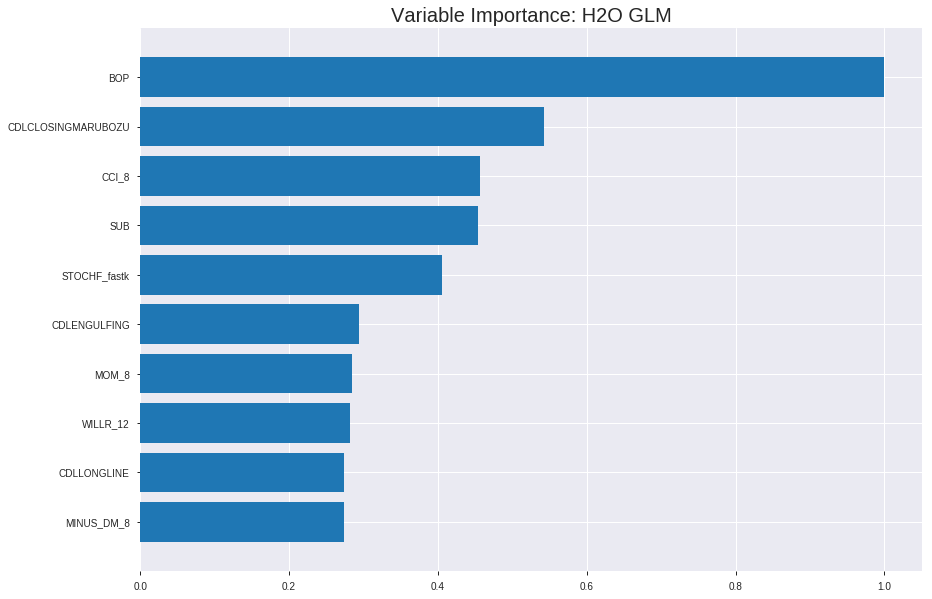

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_142537_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1860703981541466
RMSE: 0.43135878124149346
LogLoss: 0.5504790711263654
Null degrees of freedom: 1721
Residual degrees of freedom: 1662
Null deviance: 2385.969939946232
Residual deviance: 1895.8499209592023
AIC: 2015.8499209592023
AUC: 0.7919341731552176
pr_auc: 0.7615298406938753
Gini: 0.5838683463104353
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3692191666288951: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      465  419   0.474    (419.0/884.0)
1      97   741   0.1158   (97.0/838.0)
Total  562  1160  0.2997   (516.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369219     0.741742  255
max f2                       0.204163     0.85206   323
max f0point5                 0.571411     0.722735  157
max accuracy                 0.490102     0.714866  196
max precision                0.950752     1         0
max recall                   0.0422272    1         392
max specificity              0.950752     1         0
max absolute_mcc             0.369219     0.437338  255
max min_per_class_accuracy   0.494404     0.713604  194
max mean_per_class_accuracy  0.490102     0.715051  196

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.907908           1.94073    1.94073            0.944444         0.927789   0.944444                    0.927789            0.0202864       0.0202864                  94.0732   94.0732
    2        0.0203252                   0.892659           1.69226    1.82005            0.823529         0.898192   0.885714                    0.913413            0.0167064       0.0369928                  69.2264   82.0048
    3        0.0301974                   0.884069           1.69226    1.77827            0.823529         0.889038   0.865385                    0.905445            0.0167064       0.0536993                  69.2264   77.8272
    4        0.0400697                   0.874549           1.93402    1.81664            0.941176         0.880068   0.884058                    0.899192            0.0190931       0.0727924                  93.4017   81.6644
    5        0.0505226                   0.8645             1.71241    1.79508            0.833333         0.870173   0.873563                    0.893189            0.0178998       0.0906921                  71.2411   79.5079
    6        0.100465                    0.815467           1.69648    1.74606            0.825581         0.838242   0.849711                    0.865874            0.0847255       0.175418                   69.6481   74.6065
    7        0.150407                    0.770768           1.6248     1.7058             0.790698         0.789328   0.830116                    0.840457            0.0811456       0.256563                   62.4799   70.5799
    8        0.200348                    0.721064           1.57701    1.6737             0.767442         0.74674    0.814493                    0.817096            0.0787589       0.335322                   57.7011   67.3695
    9        0.300232                    0.643254           1.52922    1.62563            0.744186         0.680867   0.791103                    0.771774            0.152745        0.488067                   52.9222   62.5631
    10       0.400116                    0.555991           1.29028    1.54192            0.627907         0.599443   0.750363                    0.728754            0.128878        0.616945                   29.0281   54.1915
    11       0.5                         0.489958           1.02745    1.43914            0.5              0.520356   0.700348                    0.687123            0.102625        0.71957                    2.74463   43.9141
    12       0.599884                    0.420728           0.979658   1.36263            0.476744         0.456841   0.663117                    0.64878             0.097852        0.817422                   -2.03419  36.2634
    13       0.699768                    0.350604           0.848241   1.28921            0.412791         0.385313   0.627386                    0.611173            0.0847255       0.902148                   -15.1759  28.9211
    14       0.799652                    0.25055            0.418147   1.18041            0.203488         0.305242   0.574437                    0.572959            0.0417661       0.943914                   -58.1853  18.0407
    15       0.899535                    0.139364           0.477882   1.1024             0.232558         0.194424   0.536475                    0.530927            0.0477327       0.991647                   -52.2118  10.2399
    16       1                           0.00718662         0.0831459  1                  0.0404624        0.0901405  0.486643 



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20429504013214886
RMSE: 0.45199008853308814
LogLoss: 0.5956647564713745
Null degrees of freedom: 491
Residual degrees of freedom: 432
Null deviance: 683.4768170160789
Residual deviance: 586.1341203678328
AIC: 706.1341203678328
AUC: 0.7472606594279662
pr_auc: 0.7432412892551967
Gini: 0.4945213188559323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.301631498663097: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      73   163  0.6907   (163.0/236.0)
1      19   237  0.0742   (19.0/256.0)
Total  92   400  0.3699   (182.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301631     0.722561  317
max f2                       0.123318     0.851703  381
max f0point5                 0.606193     0.726852  168
max accuracy                 0.545793     0.711382  201
max precision                0.961132     1         0
max recall                   0.108095     1         387
max specificity              0.961132     1         0
max absolute_mcc             0.545793     0.422797  201
max min_per_class_accuracy   0.54373      0.710938  203
max mean_per_class_accuracy  0.545793     0.711566  201

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 53.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.924201           1.92187   1.92187            1                0.948345  1                           0.948345            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.911442           1.5375    1.72969            0.8              0.919342  0.9                         0.933844            0.015625        0.0351562                  53.75     72.9687
    3        0.0304878                   0.890561           1.5375    1.66562            0.8              0.902934  0.866667                    0.92354             0.015625        0.0507812                  53.75     66.5625
    4        0.0406504                   0.881283           0.76875   1.44141            0.4              0.88599   0.75                        0.914153            0.0078125       0.0585938                  -23.125   44.1406
    5        0.050813                    0.870761           1.92187   1.5375             1                0.876656  0.8                         0.906654            0.0195312       0.078125                   92.1875   53.75
    6        0.101626                    0.826486           1.69125   1.61437            0.88             0.846023  0.84                        0.876338            0.0859375       0.164062                   69.125    61.4375
    7        0.150407                    0.780034           1.52148   1.58425            0.791667         0.804945  0.824324                    0.853184            0.0742188       0.238281                   52.1484   58.4248
    8        0.20122                     0.74299            1.30688   1.5142             0.68             0.759162  0.787879                    0.829441            0.0664062       0.304688                   30.6875   51.4205
    9        0.300813                    0.678001           1.45121   1.49335            0.755102         0.712528  0.777027                    0.790733            0.144531        0.449219                   45.1212   49.3349
    10       0.400407                    0.616067           1.37277   1.46336            0.714286         0.645548  0.761421                    0.754621            0.136719        0.585938                   37.2768   46.3357
    11       0.5                         0.549874           1.13744   1.39844            0.591837         0.581036  0.727642                    0.720045            0.113281        0.699219                   13.7436   39.8437
    12       0.599593                    0.473006           0.705995  1.28342            0.367347         0.511954  0.667797                    0.685481            0.0703125       0.769531                   -29.4005  28.3422
    13       0.699187                    0.40104            0.666773  1.19559            0.346939         0.435358  0.622093                    0.649853            0.0664062       0.835938                   -33.3227  19.5585
    14       0.79878                     0.317815           0.745217  1.13943            0.387755         0.364936  0.592875                    0.614329            0.0742188       0.910156                   -25.4783  13.9432
    15       0.898374                    0.198619           0.549107  1.07399            0.285714         0.265289  0.558824                    0.575634            0.0546875       0.964844                   -45.0893  7.3989
    16       1                           0.0505927          0.345937  1                  0.18             0.133917  0.520325                    0.530744            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 14:25:37  0.000 sec   2            .23E2     60            1.358207102220938   1.369998901805022
     2019-08-26 14:25:37  0.013 sec   4            .14E2     60            1.3468131761580542  1.3619778588385065
     2019-08-26 14:25:37  0.026 sec   6            .87E1     60            1.3322400884442276  1.3515663521244894
     2019-08-26 14:25:37  0.040 sec   8            .54E1     60            1.3139563318922192  1.3382414440757235
     2019-08-26 14:25:37  0.052 sec   10           .34E1     60            1.2916222477300736  1.3216029593287006
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 14:25:38  0.205 sec   34           .11E-1    60            1.0976831350012688  1.192092481802227
     2019-08-26 14:25:38  0.222 sec   36           .69E-2    60            1.0953111453526256  1.1936213522016264
     2019-08-26 14:25:38  0.234 sec   38           .43E-2    60            1.0936378090498988  1.1960287821940472
     2019-08-26 14:25:38  0.247 sec   40           .26E-2    60            1.0925258716423112  1.198647000728328
     2019-08-26 14:25:38  0.259 sec   42           .16E-2    60            1.0917945942244038  1.201466157961675


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7004048582995951)

('F1', 0.6666666666666666)

('auc', 0.741014512410145)

('logloss', 0.6077425152731857)

('mean_per_class_error', 0.31099959310999603)

('rmse', 0.45832678410077915)

('mse', 0.21006344102416222)

glm prediction progress: |████████████████████████████████████████████████| 100%


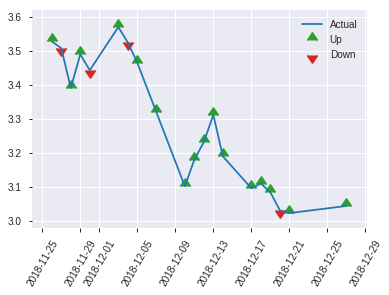


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21006344102416222
RMSE: 0.45832678410077915
LogLoss: 0.6077425152731857
Null degrees of freedom: 246
Residual degrees of freedom: 187
Null deviance: 340.1862737963396
Residual deviance: 300.2248025449537
AIC: 420.2248025449537
AUC: 0.741014512410145
pr_auc: 0.6217101541583402
Gini: 0.4820290248202901
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36336150236900355: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   87   0.5959   (87.0/146.0)
1      7    94   0.0693   (7.0/101.0)
Total  66   181  0.3806   (94.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363362     0.666667  180
max f2                       0.294299     0.819536  199
max f0point5                 0.639762     0.635294  80
max accuracy                 0.639762     0.700405  80
max precision                0.961246     1         0
max recall                   0.129934     1         236
max specificity              0.961246     1         0
max absolute_mcc             0.543066     0.372362  115
max min_per_class_accuracy   0.543066     0.684932  115
max mean_per_class_accuracy  0.543066     0.689     115

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.917673           1.63036    1.63036            0.666667         0.934862  0.666667                    0.934862            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.908221           1.22277    1.46733            0.5              0.914832  0.6                         0.92685             0.00990099      0.029703                   22.2772   46.7327
    3        0.0323887                   0.899056           1.63036    1.52847            0.666667         0.904048  0.625                       0.918299            0.019802        0.049505                   63.0363   52.8465
    4        0.0404858                   0.885948           2.44554    1.71188            1                0.894314  0.7                         0.913502            0.019802        0.0693069                  144.554   71.1881
    5        0.0526316                   0.878387           2.44554    1.88119            1                0.88333   0.769231                    0.906539            0.029703        0.0990099                  144.554   88.1188
    6        0.101215                    0.807762           1.42657    1.66297            0.583333         0.837853  0.68                        0.87357             0.0693069       0.168317                   42.6568   66.297
    7        0.149798                    0.761022           2.03795    1.78459            0.833333         0.783408  0.72973                     0.844328            0.0990099       0.267327                   103.795   78.4587
    8        0.202429                    0.711502           1.69307    1.76079            0.692308         0.735595  0.72                        0.816058            0.0891089       0.356436                   69.3069   76.0792
    9        0.299595                    0.643931           1.32467    1.61935            0.541667         0.669171  0.662162                    0.768419            0.128713        0.485149                   32.467    61.9347
    10       0.40081                     0.584534           0.880396   1.43274            0.36             0.61948   0.585859                    0.730808            0.0891089       0.574257                   -11.9604  43.2743
    11       0.502024                    0.522485           1.3695     1.41999            0.56             0.554038  0.580645                    0.695169            0.138614        0.712871                   36.9505   41.9994
    12       0.59919                     0.455549           0.305693   1.2393             0.125            0.485486  0.506757                    0.661166            0.029703        0.742574                   -69.4307  23.9296
    13       0.700405                    0.369808           1.56515    1.28638            0.64             0.415879  0.526012                    0.62572             0.158416        0.90099                    56.5149   28.6385
    14       0.797571                    0.303274           0.611386   1.20415            0.25             0.345748  0.492386                    0.591612            0.0594059       0.960396                   -38.8614  20.4151
    15       0.898785                    0.169528           0.293465   1.1016             0.12             0.232618  0.45045                     0.551185            0.029703        0.990099                   -70.6535  10.1597
    16       1                           0.0420441          0.0978218  1                  0.04             0.12885   0.408907                    

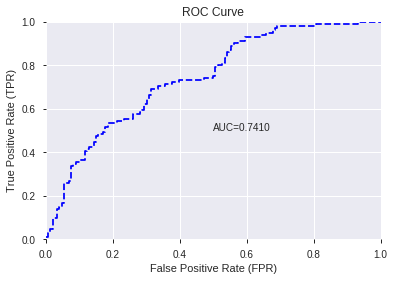

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


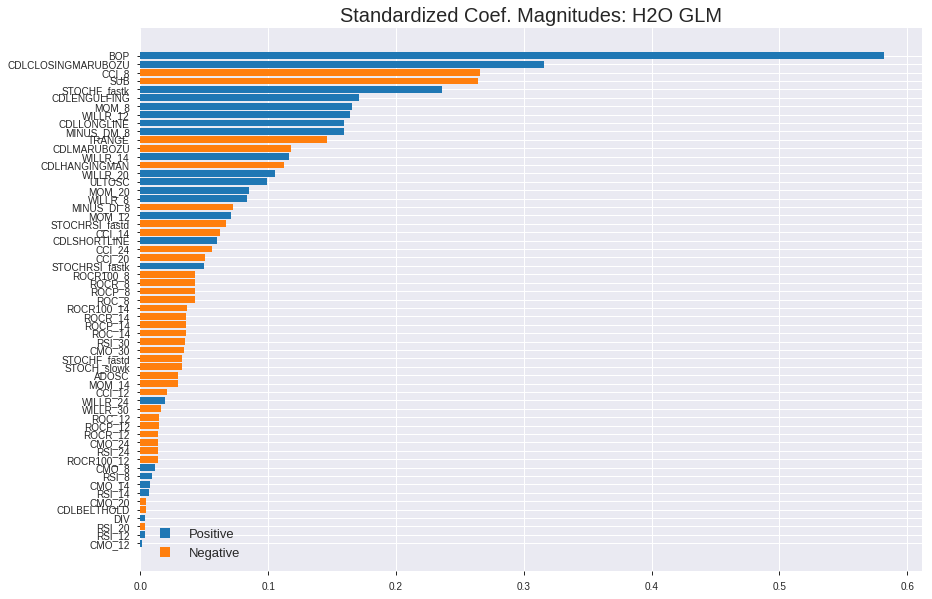

'log_likelihood'
--2019-08-26 14:25:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_142537_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_142537_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'SUB',
 'STOCHF_fastk',
 'CDLENGULFING',
 'MOM_8',
 'WILLR_12',
 'CDLLONGLINE',
 'MINUS_DM_8',
 'TRANGE',
 'CDLMARUBOZU',
 'WILLR_14',
 'CDLHANGINGMAN',
 'WILLR_20',
 'ULTOSC',
 'MOM_20',
 'WILLR_8',
 'MINUS_DI_8',
 'MOM_12',
 'STOCHRSI_fastd',
 'CCI_14',
 'CDLSHORTLINE',
 'CCI_24',
 'CCI_20',
 'STOCHRSI_fastk',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'ROC_14',
 'RSI_30',
 'CMO_30',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ADOSC',
 'MOM_14',
 'CCI_12',
 'WILLR_24',
 'WILLR_30',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'CMO_24',
 'RSI_24',
 'ROCR100_12',
 'CMO_8',
 'RSI_8',
 'CMO_14',
 'RSI_14',
 'CMO_20',
 'CDLBELTHOLD',
 'DIV',
 'RSI_20',
 'RSI_12',
 'CMO_12']

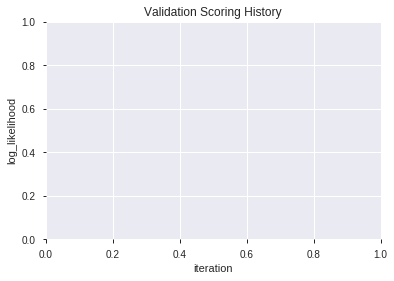

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_142547_model_6  0.739184  0.602759              0.348942  0.457682  0.209472
1  XGBoost_grid_1_AutoML_20190826_142547_model_4  0.737353  0.609464              0.327275  0.460200  0.211784
2               XGBoost_2_AutoML_20190826_142547  0.731859  0.617789              0.341720  0.463958  0.215257
3               XGBoost_1_AutoML_20190826_142547  0.731656  0.613916              0.341720  0.463392  0.214732
4  XGBoost_grid_1_AutoML_20190826_142547_model_2  0.730571  0.609853              0.334125  0.461049  0.212567
5               XGBoost_3_AutoML_20190826_142547  0.729418  0.606061              0.328801  0.459557  0.211193
6  XGBoost_grid_1_AutoML_20190826_142547_model_1  0.726977  0.614445              0.343246  0.462668  0.214061
7  XGBoost_grid_1_AutoML_20190826_142547_model_3  0.721958  0.618665              0.353147  0.465405  0.216602
8  XGBoost_grid_1_AutoML_20190826_142547_model_7  0.719517  0.625620              0.328801  0.466908  0.218003
9  XGBoost_grid_1_AutoML_20190826_142547_model_5  0.699851  0.667527              0.356198  0.483098  0.233384

variable  relative_importance  scaled_importance  percentage
0                  BOP          2449.760498           1.000000    0.252151
1         STOCHF_fastk           449.923401           0.183660    0.046310
2                  SUB           448.521912           0.183088    0.046166
3                  DIV           428.669464           0.174984    0.044122
4               TRANGE           361.392487           0.147522    0.037198
5                ROC_8           307.500458           0.125523    0.031651
6                CCI_8           300.198090           0.122542    0.030899
7               ULTOSC           232.439285           0.094882    0.023925
8                ADOSC           229.938126           0.093861    0.023667
9           MINUS_DI_8           223.264114           0.091137    0.022980
10              MOM_20           219.565826           0.089627    0.022600
11               MOM_8           214.244995           0.087455    0.022052
12              CCI_20           203.328186           0.082999    0.020928
13          MINUS_DM_8           200.590515           0.081882    0.020647
14         STOCH_slowk           195.003281           0.079601    0.020071
15      STOCHRSI_fastd           181.293396           0.074005    0.018660
16              MOM_12           178.039124           0.072676    0.018325
17      STOCHRSI_fastk           169.055756           0.069009    0.017401
18             WILLR_8           165.081589           0.067387    0.016992
19              ROC_12           162.348694           0.066271    0.016710
20            WILLR_12           159.282593           0.065020    0.016395
21  CDLCLOSINGMARUBOZU           148.628525           0.060671    0.015298
22            WILLR_24           141.277695           0.057670    0.014542
23              ROC_14           134.844009           0.055044    0.013879
24              MOM_14           130.659637           0.053336    0.013449
25              CMO_30           124.962158           0.051010    0.012862
26               CMO_8           123.745102           0.050513    0.012737
27              CCI_24           106.484337           0.043467    0.010960
28         CDLLONGLINE           104.068390           0.042481    0.010712
29              CMO_14           102.412262           0.041805    0.010541
30            WILLR_14           100.779381           0.041138    0.010373
31              CMO_20           100.431198           0.040996    0.010337
32            WILLR_30            97.910507           0.039967    0.010078
33              CCI_12            95.309814           0.038906    0.009810
34            WILLR_20            93.927086           0.038341    0.009668
35              CMO_12            86.151161           0.035167    0.008867
36              CCI_14            85.526146           0.034912    0.008803
37        CDLSHORTLINE            74.443985           0.030388    0.007662
38              CMO_24            72.092819           0.029429    0.007420
39        STOCHF_fastd            44.840046           0.018304    0.004615
40             ROCP_12            41.965454           0.017130    0.004319
41             ROCP_14            32.004990           0.013065    0.003294
42              ROCP_8            30.249910           0.012348    0.003114
43         CDLBELTHOLD            28.041286           0.011447    0.002886
44              RSI_30            26.790882           0.010936    0.002758
45              RSI_24            23.111673           0.009434    0.002379
46        CDLENGULFING            22.405258           0.009146    0.002306
47       CDLHANGINGMAN            21.660866           0.008842    0.002230
48               RSI_8            20.665941           0.008436    0.002127
49              RSI_14             9.599004           0.003918    0.000988
50              RSI_20             4.417500           0.001803    0.000455
51             ROCR_12             4.260120           0.001739    0.000438
52              RSI_12             2.33

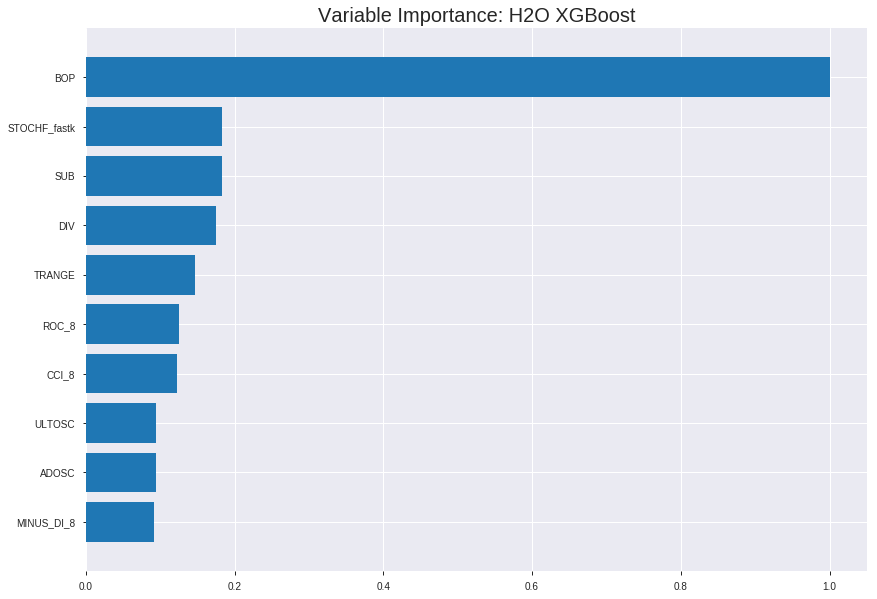

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_142547_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13527521129204173
RMSE: 0.36779778587158696
LogLoss: 0.43337519811678915
Mean Per-Class Error: 0.17345759673430594
AUC: 0.9125604758150736
pr_auc: 0.9081942512037182
Gini: 0.8251209516301472
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47453362743059796: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      697  187  0.2115   (187.0/884.0)
1      114  724  0.136    (114.0/838.0)
Total  811  911  0.1748   (301.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474534     0.827902  207
max f2                       0.338603     0.893842  273
max f0point5                 0.607644     0.835848  146
max accuracy                 0.516676     0.826945  188
max precision                0.926174     1         0
max recall                   0.184292     1         341
max specificity              0.926174     1         0
max absolute_mcc             0.516676     0.653593  188
max min_per_class_accuracy   0.507512     0.822196  192
max mean_per_class_accuracy  0.516676     0.826542  188

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.895964           2.05489    2.05489            1                0.908416  1                           0.908416            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.882481           2.05489    2.05489            1                0.887354  1                           0.898186            0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.872144           2.05489    2.05489            1                0.877744  1                           0.891503            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.860658           2.05489    2.05489            1                0.867409  1                           0.885567            0.0202864       0.0823389                  105.489   105.489
    5        0.0505226                   0.851608           2.05489    2.05489            1                0.854945  1                           0.879231            0.0214797       0.103819                   105.489   105.489
    6        0.100465                    0.812239           2.05489    2.05489            1                0.832462  1                           0.855982            0.102625        0.206444                   105.489   105.489
    7        0.150407                    0.776047           1.93542    2.01522            0.94186          0.794469  0.980695                    0.835557            0.0966587       0.303103                   93.5422   101.522
    8        0.200348                    0.739571           1.91153    1.98937            0.930233         0.758056  0.968116                    0.816238            0.0954654       0.398568                   91.1528   98.9374
    9        0.300232                    0.657951           1.69648    1.89193            0.825581         0.700114  0.920696                    0.777605            0.169451        0.568019                   69.6481   89.1932
    10       0.400116                    0.571189           1.43365    1.77753            0.697674         0.614528  0.865022                    0.736895            0.143198        0.711217                   43.3646   77.7527
    11       0.5                         0.496596           1.20665    1.66348            0.587209         0.535263  0.809524                    0.696615            0.120525        0.831742                   20.6652   66.3484
    12       0.599884                    0.413115           0.872135   1.53172            0.424419         0.456253  0.745402                    0.656594            0.0871122       0.918854                   -12.7865  53.1721
    13       0.699768                    0.317945           0.513723   1.38641            0.25             0.3676    0.674689                    0.615343            0.0513126       0.970167                   -48.6277  38.6413
    14       0.799652                    0.22545            0.262835   1.24607            0.127907         0.273115  0.606391                    0.572596            0.026253        0.99642                    -73.7165  24.6068
    15       0.899535                    0.139299           0.0358412  1.11168            0.0174419        0.182038  0.540994                    0.529228            0.00357995      1                          -96.4159  11.1685
    16       1                           0.0502586          0          1                  0                0.103455  0.486643                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20399925995828555
RMSE: 0.4516627723847578
LogLoss: 0.5929128567365601
Mean Per-Class Error: 0.311573093220339
AUC: 0.745017876059322
pr_auc: 0.7451353619201515
Gini: 0.49003575211864403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32332056760787964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      81   155  0.6568   (155.0/236.0)
1      18   238  0.0703   (18.0/256.0)
Total  99   393  0.3516   (173.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323321     0.733436  312
max f2                       0.168313     0.858008  373
max f0point5                 0.627569     0.703125  152
max accuracy                 0.534254     0.689024  203
max precision                0.923989     1         0
max recall                   0.095311     1         395
max specificity              0.923989     1         0
max absolute_mcc             0.534254     0.376919  203
max min_per_class_accuracy   0.550063     0.683594  195
max mean_per_class_accuracy  0.534254     0.688427  203

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.886042           1.92187   1.92187            1                0.902776  1                           0.902776            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.867062           1.92187   1.92187            1                0.877777  1                           0.890276            0.0195312       0.0390625                  92.1875   92.1875
    3        0.0304878                   0.860068           1.5375    1.79375            0.8              0.862884  0.933333                    0.881145            0.015625        0.0546875                  53.75     79.375
    4        0.0406504                   0.855327           1.92187   1.82578            1                0.857734  0.95                        0.875293            0.0195312       0.0742188                  92.1875   82.5781
    5        0.050813                    0.847425           1.5375    1.76812            0.8              0.851898  0.92                        0.870614            0.015625        0.0898438                  53.75     76.8125
    6        0.101626                    0.819239           1.46062   1.61437            0.76             0.831692  0.84                        0.851153            0.0742188       0.164062                   46.0625   61.4375
    7        0.150407                    0.783336           1.36133   1.53231            0.708333         0.804146  0.797297                    0.835907            0.0664062       0.230469                   36.1328   53.2306
    8        0.20122                     0.746596           1.46062   1.5142             0.76             0.764511  0.787879                    0.817878            0.0742188       0.304688                   46.0625   51.4205
    9        0.300813                    0.687375           1.49043   1.50633            0.77551          0.717151  0.783784                    0.784529            0.148438        0.453125                   49.0434   50.6334
    10       0.400407                    0.618295           1.17666   1.42433            0.612245         0.652479  0.741117                    0.751684            0.117188        0.570312                   17.6658   42.4334
    11       0.5                         0.554694           1.09821   1.35937            0.571429         0.586328  0.707317                    0.718747            0.109375        0.679688                   9.82143   35.9375
    12       0.599593                    0.464339           0.902105  1.28342            0.469388         0.513243  0.667797                    0.684613            0.0898438       0.769531                   -9.78954  28.3422
    13       0.699187                    0.393196           0.666773  1.19559            0.346939         0.431396  0.622093                    0.648544            0.0664062       0.835938                   -33.3227  19.5585
    14       0.79878                     0.321507           0.941327  1.16388            0.489796         0.356349  0.605598                    0.612113            0.09375         0.929688                   -5.86735  16.3884
    15       0.898374                    0.198625           0.352997  1.07399            0.183673         0.260069  0.558824                    0.573085            0.0351562       0.964844                   -64.7003  7.3989
    16       1                           0.0809413          0.345937  1                  0.18             0.148323  0.520325                    0.529918           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:25:58  6.401 sec   0                  0.5              0.693147            0.5             0                  1                0.513357                         0.5                0.693147              0.5               0                    1                  0.479675
    2019-08-26 14:25:58  6.476 sec   5                  0.470084         0.634698            0.845627        0.810696           2.05489          0.24216                          0.482377           0.658298              0.730527          0.72244              1.92187            0.359756
    2019-08-26 14:25:58  6.525 sec   10                 0.448506         0.593428            0.856459        0.844576           2.05489          0.238676                         0.471102           0.635997              0.739117          0.737496             1.92187            0.349593
    2019-08-26 14:25:58  6.576 sec   15                 0.43076          0.559445            0.867429        0.857814           2.05489          0.2259                           0.461786           0.61721               0.746367          0.745343             1.92187            0.331301
    2019-08-26 14:25:58  6.627 sec   20                 0.418522         0.535439            0.873741        0.866836           2.05489          0.220093                         0.457443           0.607878              0.747716          0.75145              1.92187            0.349593
    2019-08-26 14:25:58  6.683 sec   25                 0.408271         0.515096            0.880034        0.876346           2.05489          0.210801                         0.455712           0.603641              0.743909          0.744358             1.92187            0.343496
    2019-08-26 14:25:58  6.740 sec   30                 0.399378         0.497148            0.885703        0.879962           2.05489          0.207898                         0.452862           0.597235              0.745697          0.743159             1.92187            0.349593
    2019-08-26 14:25:58  6.795 sec   35                 0.393034         0.483775            0.889317        0.884656           2.05489          0.199768                         0.451504           0.593605              0.747815          0.748993             1.92187            0.343496
    2019-08-26 14:25:58  6.848 sec   40                 0.386168         0.47018             0.895551        0.889997           2.05489          0.200348                         0.451184           0.592628              0.746292          0.743668             1.92187            0.343496
    2019-08-26 14:25:58  6.905 sec   45                 0.380897         0.45941             0.900264        0.896201           2.05489          0.189895                         0.450807           0.591459              0.74736           0.746315             1.92187            0.347561
    2019-08-26 14:25:58  6.956 sec   50                 0.376504         0.450527            0.904653        0.900685           2.05489          0.183508                         0.451748           0.593101              0.74501           0.745767             1.92187            0.347561
    2019-08-26 14:25:58  7.012 sec   55                 0.371756         0.441232            0.909358        0.904848           2.05489          0.187573                         0.451508           0.592476              0.745821          0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2449.760498046875      1.0                    0.25215106836077933
STOCHF_fastk  449.92340087890625     0.18366015830429852    0.04631010513173873
SUB           448.52191162109375     0.1830880659471355     0.04616585143267903
DIV           428.6694641113281      0.17498423394984702    0.044122461536746475
TRANGE        361.3924865722656      0.14752155847904058    0.03719771857673726
---           ---                    ---                    ---
RSI_8         20.66594123840332      0.008435902715746985   0.002127121882363202
RSI_14        9.599003791809082      0.003918343772569644   0.0009880145684582422
RSI_20        4.4175004959106445     0.0018032377040255948  0.0004546883135784925
ROCR_12       4.260120391845703      0.0017389946467183943  0.0004384893580437191
RSI_12        2.3386917114257812     0.0009546613692605274  0.00024071888418180642


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6923076923076923)

('F1', 0.6622073578595318)

('auc', 0.7391835073918351)

('logloss', 0.6027588994393646)

('mean_per_class_error', 0.31099959310999603)

('rmse', 0.4576815077157905)

('mse', 0.20947236250499923)

xgboost prediction progress: |████████████████████████████████████████████| 100%


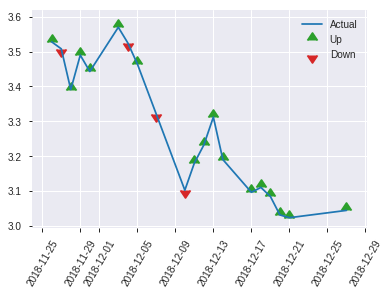


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20947236250499923
RMSE: 0.4576815077157905
LogLoss: 0.6027588994393646
Mean Per-Class Error: 0.31099959310999603
AUC: 0.7391835073918351
pr_auc: 0.6362916630071745
Gini: 0.4783670147836703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24193350970745087: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   99   0.6781   (99.0/146.0)
1      2    99   0.0198   (2.0/101.0)
Total  49   198  0.4089   (101.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.241934     0.662207  197
max f2                       0.241934     0.822259  197
max f0point5                 0.696982     0.623003  52
max accuracy                 0.70227      0.692308  50
max precision                0.901914     1         0
max recall                   0.107796     1         239
max specificity              0.901914     1         0
max absolute_mcc             0.241934     0.37246   197
max min_per_class_accuracy   0.548394     0.684932  115
max mean_per_class_accuracy  0.548394     0.689     115

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 48.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.8866             1.63036    1.63036            0.666667         0.897357  0.666667                    0.897357            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.870145           2.44554    1.95644            1                0.879522  0.8                         0.890223            0.019802        0.039604                   144.554   95.6436
    3        0.0323887                   0.848643           1.63036    1.83416            0.666667         0.859933  0.75                        0.878864            0.019802        0.0594059                  63.0363   83.4158
    4        0.0404858                   0.844687           2.44554    1.95644            1                0.846766  0.8                         0.872445            0.019802        0.0792079                  144.554   95.6436
    5        0.0526316                   0.828491           1.63036    1.88119            0.666667         0.835556  0.769231                    0.863932            0.019802        0.0990099                  63.0363   88.1188
    6        0.101215                    0.788519           2.03795    1.95644            0.833333         0.807009  0.8                         0.836609            0.0990099       0.19802                    103.795   95.6436
    7        0.149798                    0.759713           1.22277    1.71849            0.5              0.775549  0.702703                    0.816806            0.0594059       0.257426                   22.2772   71.8491
    8        0.202429                    0.710642           2.06931    1.8097             0.846154         0.734656  0.74                        0.795447            0.108911        0.366337                   106.931   80.9703
    9        0.299595                    0.64023            1.12087    1.5863             0.458333         0.674436  0.648649                    0.7562              0.108911        0.475248                   12.0875   58.6299
    10       0.40081                     0.584079           0.978218   1.43274            0.4              0.61248   0.585859                    0.719907            0.0990099       0.574257                   -2.17822  43.2743
    11       0.502024                    0.515816           1.3695     1.41999            0.56             0.553391  0.580645                    0.686335            0.138614        0.712871                   36.9505   41.9994
    12       0.59919                     0.443273           0.611386   1.28887            0.25             0.481806  0.527027                    0.653168            0.0594059       0.772277                   -38.8614  28.8868
    13       0.700405                    0.314396           0.880396   1.22984            0.36             0.376968  0.50289                     0.613255            0.0891089       0.861386                   -11.9604  22.984
    14       0.797571                    0.242119           1.12087    1.21657            0.458333         0.277656  0.497462                    0.57237             0.108911        0.970297                   12.0875   21.6565
    15       0.898785                    0.164784           0.195644   1.1016             0.08             0.208207  0.45045                     0.531361            0.019802        0.990099                   -80.4356  10.1597
    16       1                           0.0639064          0.0978218  1                  0.04             0.120269  0.408907                    

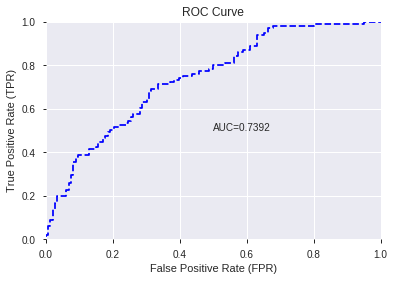

This function is available for GLM models only


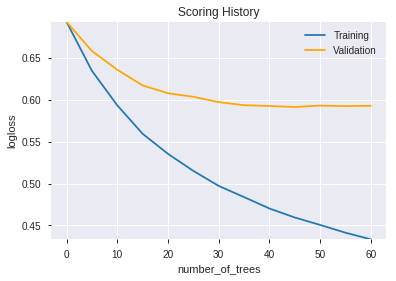

--2019-08-26 14:26:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_142547_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_142547_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'DIV',
 'TRANGE',
 'ROC_8',
 'CCI_8',
 'ULTOSC',
 'ADOSC',
 'MINUS_DI_8',
 'MOM_20',
 'MOM_8',
 'CCI_20',
 'MINUS_DM_8',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'MOM_12',
 'STOCHRSI_fastk',
 'WILLR_8',
 'ROC_12',
 'WILLR_12',
 'CDLCLOSINGMARUBOZU',
 'WILLR_24',
 'ROC_14',
 'MOM_14',
 'CMO_30',
 'CMO_8',
 'CCI_24',
 'CDLLONGLINE',
 'CMO_14',
 'WILLR_14',
 'CMO_20',
 'WILLR_30',
 'CCI_12',
 'WILLR_20',
 'CMO_12',
 'CCI_14',
 'CDLSHORTLINE',
 'CMO_24',
 'STOCHF_fastd',
 'ROCP_12',
 'ROCP_14',
 'ROCP_8',
 'CDLBELTHOLD',
 'RSI_30',
 'RSI_24',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'RSI_8',
 'RSI_14',
 'RSI_20',
 'ROCR_12',
 'RSI_12']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

98

['BBANDS_upperband_14_6_3',
 'BBANDS_middleband_14_6_4',
 'BBANDS_upperband_14_7_3',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_20_2_2',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_lowerband_20_5_2',
 'BBANDS_upperband_20_5_3',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_middleband_20_7_2',
 'BBANDS_upperband_20_7_3',
 'BBANDS_lowerband_20_7_5',
 'BBANDS_lowerband_24_0_4',
 'BBANDS_upperband_30_1_2',
 'BBANDS_upperband_30_7_2',
 'BOP',
 'ADX_8',
 'ADXR_8',
 'aroondown_8',
 'aroonup_8',
 'CCI_8',
 'CMO_8',
 'DX_8',
 'MACDFIX_signal_8',
 'MFI_8',
 'MOM_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'ADXR_12',
 'aroondown_12',
 'AROONOSC_12',
 'CCI_12',
 'DX_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'RSI_12',
 'aroonup_14',
 'CCI_14',
 'DX_14',
 'MACDFIX_14',
 'MFI_14',
 'MINUS_DI_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROCR_14',
 'MINUS_DI_20',
 'MOM_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROCP_20',
 'ROCR_20',
 'RSI_20',
 'WIL

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_142715_model_8  0.732402  0.599627              0.332226  0.453248  0.205434
1  DeepLearning_grid_1_AutoML_20190826_142715_model_7  0.730571  0.835239              0.329581  0.517377  0.267678
2  DeepLearning_grid_1_AutoML_20190826_142715_model_6  0.730300  0.609914              0.376339  0.462780  0.214166
3  DeepLearning_grid_1_AutoML_20190826_142715_model_5  0.724739  0.620611              0.366472  0.463435  0.214772
4  DeepLearning_grid_1_AutoML_20190826_142715_model_9  0.721619  0.616605              0.367218  0.465094  0.216313
5  DeepLearning_grid_1_AutoML_20190826_142715_model_3  0.706904  0.752796              0.356944  0.496830  0.246840
6  DeepLearning_grid_1_AutoML_20190826_142715_model_4  0.703852  0.886503              0.374068  0.526805  0.277523
7               DeepLearning_1_AutoML_20190826_142715  0.691103  0.784045              0.377492  0.520158  0.270564
8  DeepLearning_grid_1_AutoML_20190826_142715_model_2  0.666079  0.909170              0.353554  0.527195  0.277935
9  DeepLearning_grid_1_AutoML_20190826_142715_model_1  0.642886  1.351472              0.374847  0.573772  0.329214

variable  relative_importance  scaled_importance  percentage
0         CDLCLOSINGMARUBOZU             1.000000           1.000000    0.028813
1                        BOP             0.999859           0.999859    0.028809
2               CDLSHORTLINE             0.714211           0.714211    0.020578
3                CDLLONGLINE             0.640711           0.640711    0.018461
4                  CORREL_12             0.512627           0.512627    0.014770
..                       ...                  ...                ...         ...
93                MACDFIX_14             0.264989           0.264989    0.007635
94  BBANDS_middleband_14_6_4             0.263229           0.263229    0.007584
95   BBANDS_lowerband_20_5_2             0.262366           0.262366    0.007559
96   BBANDS_upperband_30_1_2             0.260530           0.260530    0.007507
97  BBANDS_middleband_20_7_2             0.250440           0.250440    0.007216

[98 rows x 4 columns]

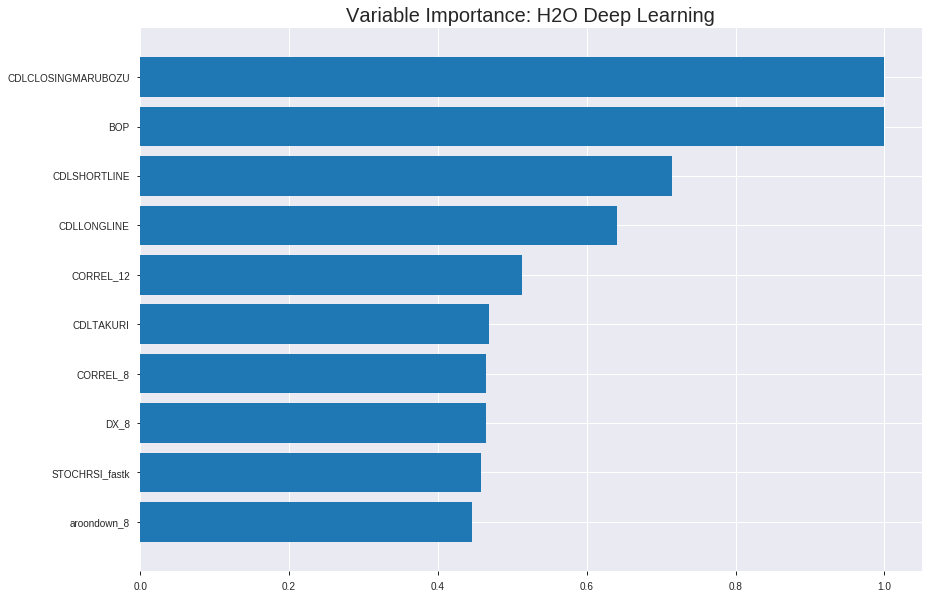

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_142715_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17506144567796764
RMSE: 0.41840344845372346
LogLoss: 0.5244521151717583
Mean Per-Class Error: 0.2533707167464012
AUC: 0.826091534465815
pr_auc: 0.8073560921611738
Gini: 0.6521830689316299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34472240085325934: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      504  380   0.4299   (380.0/884.0)
1      80   758   0.0955   (80.0/838.0)
Total  584  1138  0.2671   (460.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344722     0.767206  261
max f2                       0.256696     0.858672  301
max f0point5                 0.549969     0.744373  155
max accuracy                 0.403567     0.744483  229
max precision                0.999402     1         0
max recall                   0.0620313    1         382
max specificity              0.999402     1         0
max absolute_mcc             0.344722     0.501144  261
max min_per_class_accuracy   0.447116     0.73747   207
max mean_per_class_accuracy  0.403567     0.746629  229

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 44.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.946746           1.94073   1.94073            0.944444         0.97537    0.944444                    0.97537             0.0202864       0.0202864                  94.0732   94.0732
    2        0.0203252                   0.895029           1.93402   1.93747            0.941176         0.918313   0.942857                    0.947657            0.0190931       0.0393795                  93.4017   93.747
    3        0.0301974                   0.859163           2.05489   1.97586            1                0.87496    0.961538                    0.92389             0.0202864       0.0596659                  105.489   97.5858
    4        0.0400697                   0.839684           1.81314   1.93577            0.882353         0.84969    0.942029                    0.905609            0.0178998       0.0775656                  81.3141   93.5768
    5        0.0505226                   0.822259           2.05489   1.96041            1                0.830218   0.954023                    0.890011            0.0214797       0.0990453                  105.489   96.0415
    6        0.100465                    0.763108           1.88763   1.92423            0.918605         0.790639   0.936416                    0.840612            0.0942721       0.193317                   88.7634   92.4235
    7        0.150407                    0.710943           1.72038   1.85654            0.837209         0.738115   0.903475                    0.806578            0.0859189       0.279236                   72.0375   85.6544
    8        0.200348                    0.666628           1.52922   1.77495            0.744186         0.688509   0.863768                    0.777147            0.0763723       0.355609                   52.9222   77.4951
    9        0.300232                    0.57297            1.52922   1.6932             0.744186         0.617981   0.823985                    0.724194            0.152745        0.508353                   52.9222   69.32
    10       0.400116                    0.503225           1.26639   1.58665            0.616279         0.535826   0.772134                    0.67717             0.126492        0.634845                   26.6387   58.6651
    11       0.5                         0.441721           1.11108   1.49165            0.540698         0.475205   0.7259                      0.636824            0.110979        0.745823                   11.1076   49.1647
    12       0.599884                    0.384558           0.979658  1.4064             0.476744         0.413585   0.684414                    0.599654            0.097852        0.843675                   -2.03419  40.6398
    13       0.699768                    0.315604           0.788505  1.3182             0.383721         0.350705   0.641494                    0.564119            0.0787589       0.922434                   -21.1495  31.8201
    14       0.799652                    0.210302           0.442041  1.20876            0.215116         0.269725   0.588235                    0.527347            0.0441527       0.966587                   -55.7959  20.876
    15       0.899535                    0.112882           0.215047  1.09842            0.104651         0.160385   0.534538                    0.486599            0.0214797       0.988067                   -78.4953  9.8419
    16       1                           0.0171746          0.11878   1                  0.0578035        0.0721034  0.486643                    0.44



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20814124758228217
RMSE: 0.45622499666533195
LogLoss: 0.6105663513115793
Mean Per-Class Error: 0.3024695444915254
AUC: 0.7462096133474576
pr_auc: 0.7376727673482424
Gini: 0.4924192266949152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33954060949070286: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  134  0.5678   (134.0/236.0)
1      33   223  0.1289   (33.0/256.0)
Total  135  357  0.3394   (167.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339541     0.727569  279
max f2                       0.0476302    0.848806  391
max f0point5                 0.527457     0.715548  173
max accuracy                 0.476803     0.699187  210
max precision                0.988286     1         0
max recall                   0.0476302    1         391
max specificity              0.988286     1         0
max absolute_mcc             0.476803     0.396626  210
max min_per_class_accuracy   0.495585     0.690678  197
max mean_per_class_accuracy  0.476803     0.69753   210

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 47.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.92317            1.15312   1.15312            0.6              0.951499   0.6                         0.951499            0.0117188       0.0117188                  15.3125   15.3125
    2        0.0203252                   0.845707           1.5375    1.34531            0.8              0.874861   0.7                         0.91318             0.015625        0.0273438                  53.75     34.5312
    3        0.0304878                   0.816394           1.92187   1.5375             1                0.830011   0.8                         0.885457            0.0195312       0.046875                   92.1875   53.75
    4        0.0406504                   0.79503            1.92187   1.63359            1                0.807159   0.85                        0.865883            0.0195312       0.0664062                  92.1875   63.3594
    5        0.050813                    0.791395           1.5375    1.61437            0.8              0.792638   0.84                        0.851234            0.015625        0.0820312                  53.75     61.4375
    6        0.101626                    0.7484             1.69125   1.65281            0.88             0.77209    0.86                        0.811662            0.0859375       0.167969                   69.125    65.2812
    7        0.150407                    0.717411           1.68164   1.66216            0.875            0.735651   0.864865                    0.787009            0.0820312       0.25                       68.1641   66.2162
    8        0.20122                     0.675785           1.30688   1.57244            0.68             0.694751   0.818182                    0.763712            0.0664062       0.316406                   30.6875   57.2443
    9        0.300813                    0.594509           1.29432   1.48036            0.673469         0.628669   0.77027                     0.719002            0.128906        0.445312                   29.4324   48.0363
    10       0.400407                    0.550505           1.2551    1.42433            0.653061         0.571164   0.741117                    0.68223             0.125           0.570312                   25.5102   42.4334
    11       0.5                         0.4987             1.09821   1.35937            0.571429         0.52473    0.707317                    0.650858            0.109375        0.679688                   9.82143   35.9375
    12       0.599593                    0.436368           0.941327  1.28994            0.489796         0.473272   0.671186                    0.621361            0.09375         0.773438                   -5.86735  28.9936
    13       0.699187                    0.357369           0.705995  1.20676            0.367347         0.400669   0.627907                    0.589925            0.0703125       0.84375                    -29.4005  20.6759
    14       0.79878                     0.265401           0.509885  1.11987            0.265306         0.315114   0.582697                    0.555661            0.0507812       0.894531                   -49.0115  11.9871
    15       0.898374                    0.158233           0.745217  1.07834            0.387755         0.219731   0.561086                    0.51842             0.0742188       0.96875                    -25.4783  7.83371
    16       1                           0.0219978          0.3075    1                  0.16             0.0960962  0.520325                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:34:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:34:43  1 min 44.432 sec  602 obs/sec       0.647503  1             1115       0.497486         0.713846            0.00932541     0.743466        0.715945           1.94073          0.347271                         0.578226           0.971882              -0.339597        0.716035          0.733632             1.92187            0.394309
    2019-08-26 14:34:58  1 min 59.696 sec  914 obs/sec       8.34553   13            14371      0.437943         0.568019            0.232277       0.795713        0.76203            1.94073          0.271196                         0.459312           0.617027              0.154735         0.743363          0.74328              1.92187            0.345528
    2019-08-26 14:35:12  2 min 14.051 sec  1010 obs/sec      16.7886   26            28910      0.425303         0.539369            0.275951       0.813823        0.794245           2.05489          0.283391                         0.463278           0.617806              0.140074         0.743371          0.758736             1.92187            0.325203
    2019-08-26 14:35:27  2 min 29.222 sec  1055 obs/sec      25.8206   40            44463      0.418403         0.524452            0.299254       0.826092        0.807356           1.94073          0.267131                         0.456225           0.610566              0.166057         0.74621           0.737673             1.15312            0.339431
    2019-08-26 14:35:44  2 min 45.789 sec  1088 obs/sec      36.0772   56            62125      0.411788         0.509754            0.321239       0.835472        0.814022           2.05489          0.261905                         0.463017           0.639177              0.141042         0.734152          0.721833             1.92187            0.331301
    2019-08-26 14:36:01  3 min  2.610 sec  1103 obs/sec      46.3298   72            79780      0.3964           0.470874            0.371019       0.85247         0.839741           2.05489          0.246806                         0.461241           0.648979              0.147619         0.743801          0.729734             1.15312            0.329268
    2019-08-26 14:36:17  3 min 18.464 sec  1124 obs/sec      56.6231   88            97505      0.388245         0.452003            0.396631       0.875634        0.864576           2.05489          0.239837                         0.459493           0.635068              0.154065         0.746938          0.730129             1.5375             0.315041
    2019-08-26 14:36:18  3 min 19.987 sec  1124 obs/sec      56.6231   88            97505      0.418403         0.524452            0.299254       0.826092        0.807356           1.94073          0.267131                         0.456225           0.610566              0.166057         0.74621           0.737673             1.15312            0.339431

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLCLOSINGMARUBOZU        1.0                    1.0                  0.0288127816710683
BOP                       0.9998591542243958     0.9998591542243958   0.028808723512486523
CDLSHORTLINE              0.7142106294631958     0.7142106294631958   0.02057839493387932
CDLLONGLINE               0.6407110095024109     0.6407110095024109   0.018460666431042733
CORREL_12                 0.5126265287399292     0.5126265287399292   0.0147701962513812
---                       ---                    ---                  ---
MACDFIX_14                0.26498880982398987    0.26498880982398987  0.0076350647227348585
BBANDS_middleband_14_6_4  0.26322945952415466    0.26322945952415466  0.007584372946662778
BBANDS_lowerband_20_5_2   0.2623656988143921     0.2623656988143921   0.007559485597916343
BBANDS_upperband_30_1_2   0.26052987575531006    0.26052987575531006  0.0075065904289283
BBANDS_middleband_20_7_2  0.25044047832489014    0.25044047832489014  0.007215886823572972


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7165991902834008)

('F1', 0.6642599277978339)

('auc', 0.73240200732402)

('logloss', 0.5996273872901302)

('mean_per_class_error', 0.325918893259189)

('rmse', 0.4532479946776702)

('mse', 0.20543374467932934)

deeplearning prediction progress: |███████████████████████████████████████| 100%


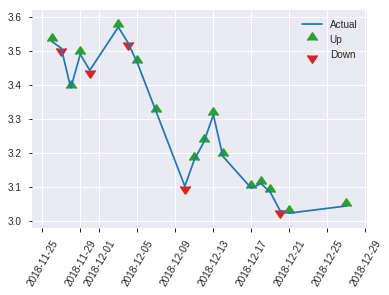


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20543374467932934
RMSE: 0.4532479946776702
LogLoss: 0.5996273872901302
Mean Per-Class Error: 0.325918893259189
AUC: 0.73240200732402
pr_auc: 0.6351943923431701
Gini: 0.4648040146480401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33028076065846823: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   84   0.5753   (84.0/146.0)
1      9    92   0.0891   (9.0/101.0)
Total  71   176  0.3765   (93.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330281     0.66426   175
max f2                       0.188301     0.810147  206
max f0point5                 0.636865     0.669782  54
max accuracy                 0.636865     0.716599  54
max precision                0.855236     0.818182  10
max recall                   0.0680106    1         236
max specificity              0.982134     0.993151  0
max absolute_mcc             0.636865     0.405972  54
max min_per_class_accuracy   0.468704     0.630137  117
max mean_per_class_accuracy  0.59102      0.674081  68

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 46.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.976587           1.63036    1.63036            0.666667         0.980646   0.666667                    0.980646            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.952239           2.44554    1.95644            1                0.967953   0.8                         0.975569            0.019802        0.039604                   144.554   95.6436
    3        0.0323887                   0.905419           1.63036    1.83416            0.666667         0.938915   0.75                        0.961824            0.019802        0.0594059                  63.0363   83.4158
    4        0.0404858                   0.857055           2.44554    1.95644            1                0.867614   0.8                         0.942982            0.019802        0.0792079                  144.554   95.6436
    5        0.0526316                   0.813516           1.63036    1.88119            0.666667         0.840713   0.769231                    0.919381            0.019802        0.0990099                  63.0363   88.1188
    6        0.101215                    0.780512           1.83416    1.85861            0.75             0.800481   0.76                        0.862309            0.0891089       0.188119                   83.4158   85.8614
    7        0.149798                    0.715326           1.83416    1.85068            0.75             0.744855   0.756757                    0.824216            0.0891089       0.277228                   83.4158   85.0682
    8        0.202429                    0.650504           2.06931    1.90752            0.846154         0.685545   0.78                        0.788162            0.108911        0.386139                   106.931   90.7525
    9        0.299595                    0.58358            1.12087    1.65239            0.458333         0.611762   0.675676                    0.730951            0.108911        0.49505                    12.0875   65.2395
    10       0.40081                     0.526626           0.880396   1.45745            0.36             0.55792    0.59596                     0.687256            0.0891089       0.584158                   -11.9604  45.7446
    11       0.502024                    0.456071           0.684752   1.30166            0.28             0.489258   0.532258                    0.647337            0.0693069       0.653465                   -31.5248  30.1661
    12       0.59919                     0.413619           1.12087    1.27234            0.458333         0.435824   0.52027                     0.613038            0.108911        0.762376                   12.0875   27.2344
    13       0.700405                    0.336548           1.27168    1.27225            0.52             0.381585   0.520231                    0.579591            0.128713        0.891089                   27.1683   27.2249
    14       0.797571                    0.234286           0.509488   1.17932            0.208333         0.293644   0.482234                    0.544755            0.049505        0.940594                   -49.0512  17.9324
    15       0.898785                    0.137138           0.489109   1.1016             0.2              0.181628   0.45045                     0.503862            0.049505        0.990099                   -51.0891  10.1597
    16       1                           0.0253955          0.0978218  1                  0.04             0.0756424  0.408907 

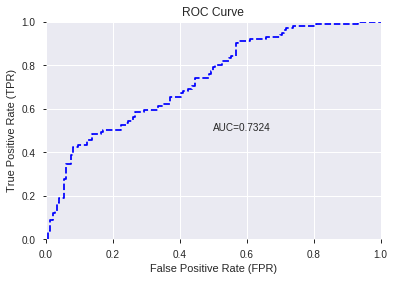

This function is available for GLM models only


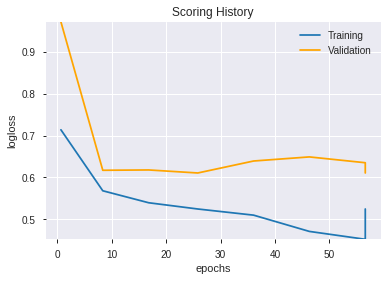

--2019-08-26 14:38:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_142715_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_142715_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CORREL_12',
 'CDLTAKURI',
 'CORREL_8',
 'DX_8',
 'STOCHRSI_fastk',
 'aroondown_8',
 'WILLR_8',
 'CCI_8',
 'ULTOSC',
 'ADXR_12',
 'MFI_14',
 'aroonup_14',
 'BETA_12',
 'aroonup_30',
 'DX_12',
 'CDLSPINNINGTOP',
 'MACDEXT_hist',
 'aroonup_8',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'STOCH_slowd',
 'CDLBELTHOLD',
 'ADXR_8',
 'MFI_30',
 'DX_24',
 'aroondown_12',
 'STDDEV_8',
 'MOM_8',
 'DX_14',
 'AROONOSC_12',
 'aroondown_24',
 'WILLR_20',
 'ADX_8',
 'PLUS_DM_8',
 'AROONOSC_30',
 'STOCHF_fastd',
 'MFI_8',
 'CCI_12',
 'PLUS_DI_8',
 'CCI_14',
 'MACDFIX_signal_24',
 'MINUS_DM_30',
 'WILLR_24',
 'ROCR_14',
 'ROCR_30',
 'CCI_30',
 'ROCR_24',
 'ROCP_20',
 'MOM_20',
 'WILLR_30',
 'MOM_12',
 'ROCR_20',
 'PLUS_DM_30',
 'ROCP_24',
 'LINEARREG_SLOPE_8',
 'ROCR_12',
 'MACDFIX_signal_8',
 'CMO_8',
 'CCI_24',
 'PLUS_DM_20',
 'ROC_12',
 'MOM_14',
 'BBANDS_lowerband_24_0_4',
 'MINUS_DI_12',
 'PLUS_DI_30',
 'PLUS_DI_14',
 '

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_143815_model_1  0.706904  0.64671              0.342873  0.474055  0.224728

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.676775           1.000000    0.082251
1                CCI_8             0.380973           0.562924    0.046301
2          STOCH_slowd             0.377727           0.558127    0.045906
3            PLUS_DM_8             0.280694           0.414752    0.034114
4   CDLCLOSINGMARUBOZU             0.262553           0.387948    0.031909
..                 ...                  ...                ...         ...
93   LINEARREG_SLOPE_8             0.004930           0.007284    0.000599
94          aroonup_30             0.004720           0.006974    0.000574
95          PLUS_DI_30             0.004533           0.006697    0.000551
96              CMO_24             0.003183           0.004703    0.000387
97               DX_24             0.001473           0.002176    0.000179

[98 rows x 4 columns]

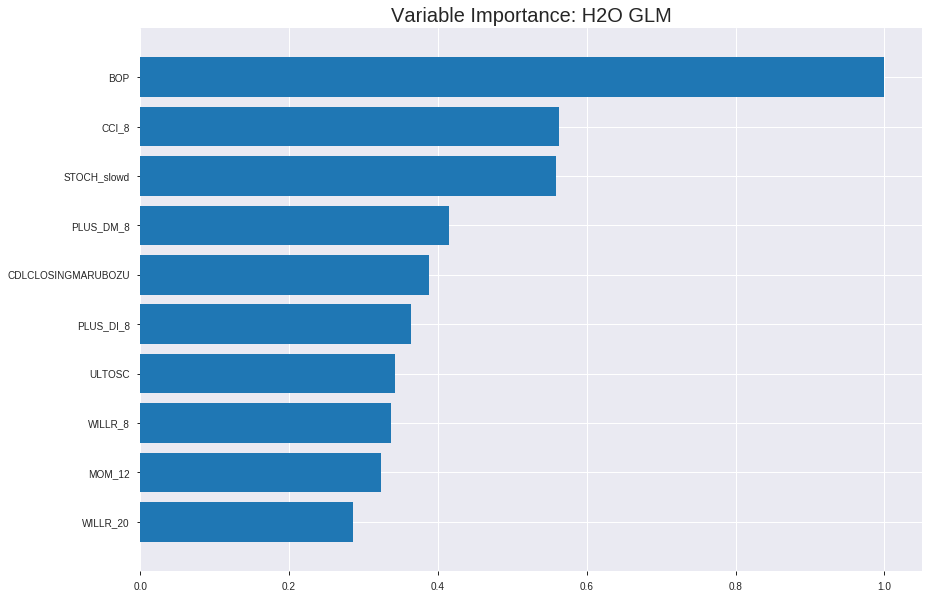

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_143815_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18570802329994812
RMSE: 0.43093853772892965
LogLoss: 0.5510115527726115
Null degrees of freedom: 1721
Residual degrees of freedom: 1623
Null deviance: 2385.969939946232
Residual deviance: 1897.6837877488738
AIC: 2095.683787748874
AUC: 0.7929040810375922
pr_auc: 0.7690238086139078
Gini: 0.5858081620751845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3787521059581105: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      519  365   0.4129   (365.0/884.0)
1      137  701   0.1635   (137.0/838.0)
Total  656  1066  0.2915   (502.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378752     0.736345  248
max f2                       0.185752     0.843808  338
max f0point5                 0.547017     0.721897  174
max accuracy                 0.520228     0.722997  184
max precision                0.954517     1         0
max recall                   0.0734899    1         387
max specificity              0.954517     1         0
max absolute_mcc             0.520228     0.445712  184
max min_per_class_accuracy   0.477334     0.717184  201
max mean_per_class_accuracy  0.501959     0.722224  191

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.927177           2.05489   2.05489            1                0.937454  1                           0.937454            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.91527            1.81314   1.93747            0.882353         0.920706  0.942857                    0.929319            0.0178998       0.0393795                  81.3141   93.747
    3        0.0301974                   0.906828           1.69226   1.85731            0.823529         0.910775  0.903846                    0.923257            0.0167064       0.0560859                  69.2264   85.7307
    4        0.0400697                   0.897458           1.81314   1.84643            0.882353         0.902933  0.898551                    0.918249            0.0178998       0.0739857                  81.3141   84.6425
    5        0.0505226                   0.885844           1.59825   1.79508            0.777778         0.891672  0.873563                    0.912751            0.0167064       0.0906921                  59.825    79.5079
    6        0.100465                    0.827134           1.76816   1.7817             0.860465         0.853474  0.867052                    0.883284            0.0883055       0.178998                   76.8163   78.1699
    7        0.150407                    0.774775           1.6248    1.7296             0.790698         0.80117   0.841699                    0.856018            0.0811456       0.260143                   62.4799   72.9601
    8        0.200348                    0.729531           1.64869   1.70943            0.802326         0.752642  0.831884                    0.830249            0.0823389       0.342482                   64.8693   70.9432
    9        0.300232                    0.650721           1.49338   1.63755            0.726744         0.686105  0.796905                    0.782294            0.149165        0.491647                   49.3381   63.7555
    10       0.400116                    0.573057           1.24249   1.53893            0.604651         0.613472  0.748911                    0.74015             0.124105        0.615752                   24.2493   53.8933
    11       0.5                         0.468803           1.07523   1.4463             0.523256         0.519357  0.703833                    0.696043            0.107399        0.72315                    7.52345   44.6301
    12       0.599884                    0.390728           0.943817  1.36263            0.459302         0.432494  0.663117                    0.65216             0.0942721       0.817422                   -5.6183   36.2634
    13       0.699768                    0.327928           0.704876  1.26875            0.343023         0.357084  0.617427                    0.610042            0.0704057       0.887828                   -29.5124  26.8747
    14       0.799652                    0.250624           0.561511  1.18041            0.273256         0.28988   0.574437                    0.57005             0.0560859       0.943914                   -43.8489  18.0407
    15       0.899535                    0.15332            0.394253  1.09311            0.19186          0.205419  0.531956                    0.529562            0.0393795       0.983294                   -60.5747  9.31127
    16       1                           0.0229077          0.166292  1                  0.0809249        0.102361  0.486643                    0.486643          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2006993072392004
RMSE: 0.4479947625131352
LogLoss: 0.5886529292892444
Null degrees of freedom: 491
Residual degrees of freedom: 393
Null deviance: 683.4768170160789
Residual deviance: 579.2344824206165
AIC: 777.2344824206165
AUC: 0.7583090572033898
pr_auc: 0.7575334772297108
Gini: 0.5166181144067796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34876088558078683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   146  0.6186   (146.0/236.0)
1      25   231  0.0977   (25.0/256.0)
Total  115  377  0.3476   (171.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348761     0.729858  301
max f2                       0.104318     0.848244  393
max f0point5                 0.628459     0.737548  158
max accuracy                 0.587432     0.711382  184
max precision                0.943679     1         0
max recall                   0.104318     1         393
max specificity              0.943679     1         0
max absolute_mcc             0.611011     0.430057  167
max min_per_class_accuracy   0.560051     0.699153  202
max mean_per_class_accuracy  0.587432     0.713056  184

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 53.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.925642           1.92187   1.92187            1                0.936363  1                           0.936363            0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.905441           1.5375    1.72969            0.8              0.914951  0.9                         0.925657            0.015625        0.0351562                  53.75     72.9687
    3        0.0304878                   0.897431           1.92187   1.79375            1                0.902297  0.933333                    0.91787             0.0195312       0.0546875                  92.1875   79.375
    4        0.0406504                   0.886838           1.92187   1.82578            1                0.893648  0.95                        0.911814            0.0195312       0.0742188                  92.1875   82.5781
    5        0.050813                    0.880134           0.76875   1.61437            0.4              0.884667  0.84                        0.906385            0.0078125       0.0820312                  -23.125   61.4375
    6        0.101626                    0.842648           1.69125   1.65281            0.88             0.863322  0.86                        0.884854            0.0859375       0.167969                   69.125    65.2812
    7        0.150407                    0.802945           1.52148   1.61022            0.791667         0.822533  0.837838                    0.864641            0.0742188       0.242188                   52.1484   61.022
    8        0.20122                     0.759898           1.61437   1.61127            0.84             0.778082  0.838384                    0.842783            0.0820312       0.324219                   61.4375   61.1269
    9        0.300813                    0.698651           1.21588   1.48036            0.632653         0.731017  0.77027                     0.805779            0.121094        0.445312                   21.588    48.0363
    10       0.400407                    0.627028           1.56888   1.50238            0.816327         0.66587   0.781726                    0.77098             0.15625         0.601562                   56.8878   50.2379
    11       0.5                         0.566479           0.862883  1.375              0.44898          0.596153  0.715447                    0.736156            0.0859375       0.6875                     -13.7117  37.5
    12       0.599593                    0.448167           0.862883  1.28994            0.44898          0.509959  0.671186                    0.698585            0.0859375       0.773438                   -13.7117  28.9936
    13       0.699187                    0.384371           0.784439  1.21793            0.408163         0.416885  0.633721                    0.658459            0.078125        0.851562                   -21.5561  21.7932
    14       0.79878                     0.32237            0.549107  1.13454            0.285714         0.356328  0.590331                    0.620788            0.0546875       0.90625                    -45.0893  13.4542
    15       0.898374                    0.22933            0.549107  1.06964            0.285714         0.280643  0.556561                    0.58308             0.0546875       0.960938                   -45.0893  6.96408
    16       1                           0.0585817          0.384375  1                  0.2              0.153118  0.520325                    0.539385            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-26 14:38:15  0.000 sec   2            .23E2     99            1.364571801340119   1.3744512427089304
     2019-08-26 14:38:15  0.030 sec   4            .14E2     99            1.354965397854733   1.3673937724194016
     2019-08-26 14:38:15  0.056 sec   6            .87E1     99            1.341992888692793   1.3576095173540805
     2019-08-26 14:38:15  0.084 sec   8            .54E1     99            1.3249131755649588  1.3444512996918419
     2019-08-26 14:38:15  0.110 sec   10           .34E1     99            1.3032978978958976  1.3275421974798731
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-26 14:38:16  0.482 sec   38           .43E-2    99            1.0991825444449295  1.177667507685795
     2019-08-26 14:38:16  0.509 sec   40           .26E-2    99            1.0967731073752638  1.1788690060348228
     2019-08-26 14:38:16  0.547 sec   42           .16E-2    99            1.0948056345120194  1.1807997548968698
     2019-08-26 14:38:16  0.576 sec   44           .1E-2     99            1.0929046690860975  1.1829937296463406
     2019-08-26 14:38:16  0.604 sec   46           .63E-3    99            1.0915067908814629  1.185317364919225


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6720647773279352)

('F1', 0.6596491228070176)

('auc', 0.7069035670690357)

('logloss', 0.6467096150209011)

('mean_per_class_error', 0.33537908585379084)

('rmse', 0.4740551114926991)

('mse', 0.22472824873235536)

glm prediction progress: |████████████████████████████████████████████████| 100%


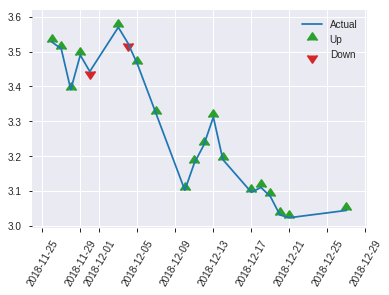


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.22472824873235536
RMSE: 0.4740551114926991
LogLoss: 0.6467096150209011
Null degrees of freedom: 246
Residual degrees of freedom: 148
Null deviance: 340.1862737963396
Residual deviance: 319.47454982032514
AIC: 517.4745498203251
AUC: 0.7069035670690357
pr_auc: 0.568842686292311
Gini: 0.41380713413807135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34631176151397064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   90   0.6164   (90.0/146.0)
1      7    94   0.0693   (7.0/101.0)
Total  63   184  0.3927   (97.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346312     0.659649  183
max f2                       0.254402     0.807504  208
max f0point5                 0.580382     0.6       105
max accuracy                 0.580382     0.672065  105
max precision                0.943357     1         0
max recall                   0.19808      1         225
max specificity              0.943357     1         0
max absolute_mcc             0.346312     0.354438  183
max min_per_class_accuracy   0.533731     0.643564  116
max mean_per_class_accuracy  0.580382     0.664621  105

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.93225            1.63036    1.63036            0.666667         0.938329  0.666667                    0.938329            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.91911            0          0.978218           0                0.926104  0.4                         0.933439            0               0.019802                   -100      -2.17822
    3        0.0323887                   0.913067           1.63036    1.22277            0.666667         0.917624  0.5                         0.927508            0.019802        0.039604                   63.0363   22.2772
    4        0.0404858                   0.901251           1.22277    1.22277            0.5              0.907659  0.5                         0.923539            0.00990099      0.049505                   22.2772   22.2772
    5        0.0526316                   0.892945           2.44554    1.50495            1                0.897567  0.615385                    0.917545            0.029703        0.0792079                  144.554   50.495
    6        0.101215                    0.82358            1.83416    1.66297            0.75             0.856016  0.68                        0.888011            0.0891089       0.168317                   83.4158   66.297
    7        0.149798                    0.768162           1.63036    1.65239            0.666667         0.793197  0.675676                    0.857261            0.0792079       0.247525                   63.0363   65.2395
    8        0.202429                    0.723133           1.12871    1.51624            0.461538         0.745024  0.62                        0.828079            0.0594059       0.306931                   12.8713   51.6238
    9        0.299595                    0.645399           1.12087    1.38801            0.458333         0.68843   0.567568                    0.782788            0.108911        0.415842                   12.0875   38.8012
    10       0.40081                     0.594371           1.46733    1.40804            0.6              0.621154  0.575758                    0.741971            0.148515        0.564356                   46.7327   40.8041
    11       0.502024                    0.512613           0.978218   1.32138            0.4              0.553939  0.540323                    0.704061            0.0990099       0.663366                   -2.17822  32.1383
    12       0.59919                     0.445272           1.12087    1.28887            0.458333         0.477765  0.527027                    0.667365            0.108911        0.772277                   12.0875   28.8868
    13       0.700405                    0.372431           0.978218   1.24398            0.4              0.407993  0.508671                    0.629883            0.0990099       0.871287                   -2.17822  24.3976
    14       0.797571                    0.292344           0.815182   1.19174            0.333333         0.337657  0.48731                     0.594282            0.0792079       0.950495                   -18.4818  19.1737
    15       0.898785                    0.213037           0.391287   1.1016             0.16             0.256329  0.45045                     0.556224            0.039604        0.990099                   -60.8713  10.1597
    16       1                           0.0565858          0.0978218  1                  0.04             0.141224  0.408907                    

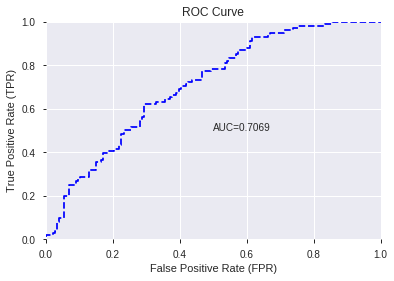

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


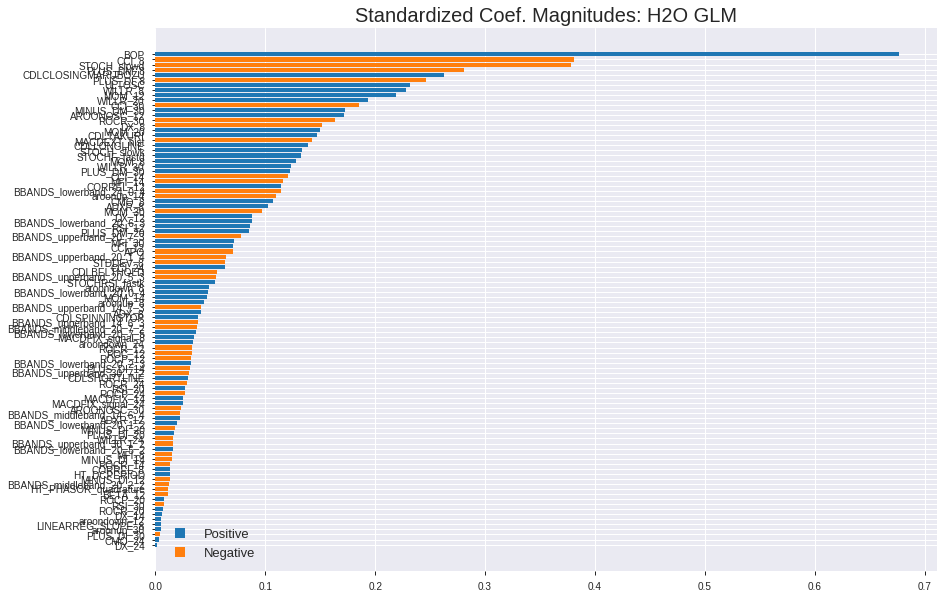

'log_likelihood'
--2019-08-26 14:38:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_143815_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_143815_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CCI_8',
 'STOCH_slowd',
 'PLUS_DM_8',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_8',
 'ULTOSC',
 'WILLR_8',
 'MOM_12',
 'WILLR_20',
 'CCI_30',
 'MINUS_DM_30',
 'AROONOSC_12',
 'ROCR_30',
 'DX_8',
 'MOM_20',
 'CDLTAKURI',
 'MACDEXT_hist',
 'CDLLONGLINE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MOM_8',
 'WILLR_30',
 'PLUS_DM_30',
 'CCI_14',
 'MFI_14',
 'CORREL_12',
 'BBANDS_lowerband_24_0_4',
 'aroonup_14',
 'CMO_8',
 'ADXR_8',
 'MOM_30',
 'DX_12',
 'BBANDS_lowerband_20_6_3',
 'RSI_12',
 'PLUS_DM_20',
 'BBANDS_upperband_20_7_3',
 'MFI_30',
 'CCI_12',
 'APO',
 'BBANDS_upperband_20_1_4',
 'STDDEV_8',
 'CCI_24',
 'CDLBELTHOLD',
 'BBANDS_upperband_20_5_3',
 'STOCHRSI_fastk',
 'aroondown_8',
 'BBANDS_lowerband_20_0_4',
 'MOM_14',
 'aroonup_8',
 'BBANDS_upperband_14_7_3',
 'ADX_8',
 'CDLSPINNINGTOP',
 'BBANDS_upperband_14_6_3',
 'BBANDS_middleband_20_7_2',
 'BBANDS_lowerband_20_7_5',
 'MACDFIX_signal_8',
 'aroondown_24',
 'ROCR_12',
 'ROC_12',
 'ROCP_12',
 'BBANDS_lowerband_20_2_3',
 'PLUS_DI_14',


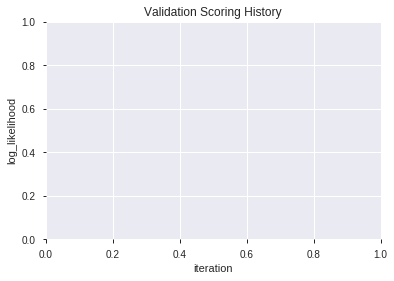

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_143828_model_1  0.739251  0.615084              0.352367  0.463970  0.215268
1               XGBoost_3_AutoML_20190826_143828  0.735115  0.618597              0.324597  0.465845  0.217011
2  XGBoost_grid_1_AutoML_20190826_143828_model_5  0.729893  0.658611              0.329547  0.478394  0.228861
3  XGBoost_grid_1_AutoML_20190826_143828_model_2  0.728537  0.627173              0.362641  0.469629  0.220551
4               XGBoost_1_AutoML_20190826_143828  0.725960  0.635326              0.350841  0.473209  0.223927
5  XGBoost_grid_1_AutoML_20190826_143828_model_7  0.721687  0.632115              0.345517  0.471582  0.222389
6  XGBoost_grid_1_AutoML_20190826_143828_model_3  0.720060  0.627421              0.340974  0.469443  0.220376
7               XGBoost_2_AutoML_20190826_143828  0.717822  0.631718              0.350095  0.471363  0.222183
8  XGBoost_grid_1_AutoML_20190826_143828_model_6  0.714092  0.624521              0.334497  0.468893  0.219861
9  XGBoost_grid_1_AutoML_20190826_143828_model_4  0.710294  0.639521              0.348196  0.474579  0.225225

variable  relative_importance  scaled_importance  percentage
0                       BOP          3698.040039           1.000000    0.406580
1        CDLCLOSINGMARUBOZU           302.817444           0.081886    0.033293
2                   WILLR_8           289.138245           0.078187    0.031789
3              CDLSHORTLINE           191.337097           0.051740    0.021036
4                  WILLR_24           183.526169           0.049628    0.020178
..                      ...                  ...                ...         ...
87                   CMO_24             5.115773           0.001383    0.000562
88  BBANDS_lowerband_20_6_3             3.879599           0.001049    0.000427
89              CDLBELTHOLD             3.772221           0.001020    0.000415
90  BBANDS_upperband_14_6_3             2.601320           0.000703    0.000286
91                   RSI_30             1.889498           0.000511    0.000208

[92 rows x 4 columns]

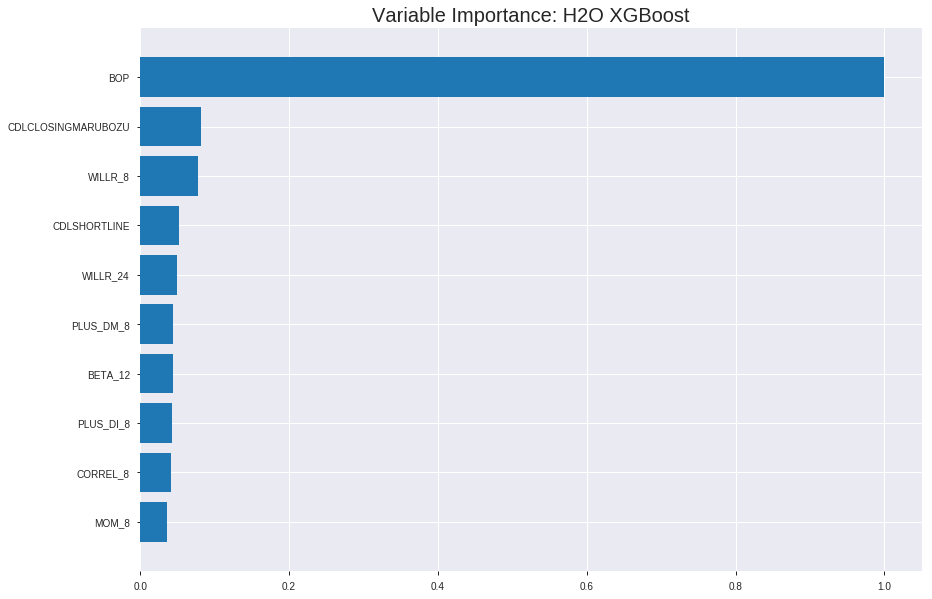

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_143828_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13558514134743332
RMSE: 0.36821887695694433
LogLoss: 0.4356780905319518
Mean Per-Class Error: 0.17101561571939228
AUC: 0.9170495901683604
pr_auc: 0.9169422973654336
Gini: 0.8340991803367208
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4618241637945175: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      688  196  0.2217   (196.0/884.0)
1      107  731  0.1277   (107.0/838.0)
Total  795  927  0.176    (303.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461824     0.828329  214
max f2                       0.326541     0.890081  278
max f0point5                 0.633978     0.852676  132
max accuracy                 0.506518     0.828688  194
max precision                0.927844     1         0
max recall                   0.199475     1         333
max specificity              0.927844     1         0
max absolute_mcc             0.497599     0.657741  198
max min_per_class_accuracy   0.506518     0.826923  194
max mean_per_class_accuracy  0.497599     0.828984  198

Gains/Lift Table: Avg response rate: 48.66 %, avg score: 48.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.894668           2.05489    2.05489            1                0.907345  1                           0.907345            0.0214797       0.0214797                  105.489   105.489
    2        0.0203252                   0.878042           2.05489    2.05489            1                0.885759  1                           0.89686             0.0202864       0.0417661                  105.489   105.489
    3        0.0301974                   0.862918           2.05489    2.05489            1                0.869526  1                           0.887924            0.0202864       0.0620525                  105.489   105.489
    4        0.0400697                   0.852717           2.05489    2.05489            1                0.857009  1                           0.880307            0.0202864       0.0823389                  105.489   105.489
    5        0.0505226                   0.842651           2.05489    2.05489            1                0.847755  1                           0.873572            0.0214797       0.103819                   105.489   105.489
    6        0.100465                    0.805914           2.05489    2.05489            1                0.822749  1                           0.848308            0.102625        0.206444                   105.489   105.489
    7        0.150407                    0.764419           2.05489    2.05489            1                0.786272  1                           0.827709            0.102625        0.309069                   105.489   105.489
    8        0.200348                    0.724173           1.98321    2.03702            0.965116         0.742028  0.991304                    0.806351            0.0990453       0.408115                   98.321    103.702
    9        0.300232                    0.650049           1.72038    1.93168            0.837209         0.686194  0.940039                    0.766376            0.171838        0.579952                   72.0375   93.1679
    10       0.400116                    0.58446            1.38586    1.79542            0.674419         0.618826  0.87373                     0.729542            0.138425        0.718377                   38.5858   79.5421
    11       0.5                         0.498222           1.19471    1.67542            0.581395         0.543182  0.815331                    0.692313            0.119332        0.837709                   19.4705   67.5418
    12       0.599884                    0.414023           0.752664   1.52177            0.366279         0.453681  0.740561                    0.65258             0.075179        0.912888                   -24.7336  52.1774
    13       0.699768                    0.329648           0.537617   1.3813             0.261628         0.373319  0.672199                    0.612718            0.0536993       0.966587                   -46.2383  38.1297
    14       0.799652                    0.233985           0.286729   1.24458            0.139535         0.282339  0.605664                    0.571451            0.0286396       0.995227                   -71.3271  24.4575
    15       0.899535                    0.150252           0.0477882  1.11168            0.0232558        0.193857  0.540994                    0.529523            0.00477327      1                          -95.2212  11.1685
    16       1                           0.0602663          0          1                  0                0.111424  0.486643                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20725386539050172
RMSE: 0.45525143095931253
LogLoss: 0.6036644347393969
Mean Per-Class Error: 0.30078125
AUC: 0.7448937367584746
pr_auc: 0.7432801166316713
Gini: 0.4897874735169492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.426399827003479: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  120  0.5085   (120.0/236.0)
1      38   218  0.1484   (38.0/256.0)
Total  154  338  0.3211   (158.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4264       0.734007  263
max f2                       0.086848     0.846561  395
max f0point5                 0.628422     0.718182  160
max accuracy                 0.61766      0.697154  170
max precision                0.938301     1         0
max recall                   0.086848     1         395
max specificity              0.938301     1         0
max absolute_mcc             0.61766      0.399567  170
max min_per_class_accuracy   0.58563      0.686441  191
max mean_per_class_accuracy  0.61766      0.699219  170

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.88417            1.92187   1.92187            1                0.91577   1                           0.91577             0.0195312       0.0195312                  92.1875   92.1875
    2        0.0203252                   0.859822           1.5375    1.72969            0.8              0.873798  0.9                         0.894784            0.015625        0.0351562                  53.75     72.9687
    3        0.0304878                   0.840897           1.15312   1.5375             0.6              0.849755  0.8                         0.879774            0.0117188       0.046875                   15.3125   53.75
    4        0.0406504                   0.833659           1.5375    1.5375             0.8              0.837586  0.8                         0.869227            0.015625        0.0625                     53.75     53.75
    5        0.050813                    0.826843           1.92187   1.61437            1                0.830299  0.84                        0.861442            0.0195312       0.0820312                  92.1875   61.4375
    6        0.101626                    0.774018           1.69125   1.65281            0.88             0.797579  0.86                        0.82951             0.0859375       0.167969                   69.125    65.2812
    7        0.150407                    0.749779           1.28125   1.53231            0.666667         0.761802  0.797297                    0.807551            0.0625          0.230469                   28.125    53.2306
    8        0.20122                     0.728802           1.61437   1.55303            0.84             0.738047  0.808081                    0.789999            0.0820312       0.3125                     61.4375   55.303
    9        0.300813                    0.693568           1.37277   1.49335            0.714286         0.711506  0.777027                    0.764012            0.136719        0.449219                   37.2768   49.3349
    10       0.400407                    0.648773           1.29432   1.44385            0.673469         0.674667  0.751269                    0.741789            0.128906        0.578125                   29.4324   44.3845
    11       0.5                         0.586776           0.980548  1.35156            0.510204         0.618996  0.703252                    0.71733             0.0976562       0.675781                   -1.94515  35.1562
    12       0.599593                    0.496661           0.862883  1.27039            0.44898          0.543837  0.661017                    0.688513            0.0859375       0.761719                   -13.7117  27.0392
    13       0.699187                    0.416893           0.902105  1.21793            0.469388         0.452551  0.633721                    0.654902            0.0898438       0.851562                   -9.78954  21.7932
    14       0.79878                     0.343391           0.666773  1.14921            0.346939         0.379647  0.597964                    0.620582            0.0664062       0.917969                   -33.3227  14.9213
    15       0.898374                    0.231199           0.392219  1.06529            0.204082         0.286269  0.554299                    0.58352             0.0390625       0.957031                   -60.7781  6.52927
    16       1                           0.0595253          0.422812  1                  0.22             0.154625  0.520325                    0.539934            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:38:34  0.018 sec   0                  0.5              0.693147            0.5             0                  1                0.513357                         0.5                0.693147              0.5               0                    1                  0.479675
    2019-08-26 14:38:34  0.131 sec   5                  0.468508         0.63171             0.851948        0.841562           2.05489          0.252613                         0.480562           0.654786              0.742957          0.724236             1.60156            0.341463
    2019-08-26 14:38:34  0.201 sec   10                 0.445847         0.588474            0.861309        0.852513           2.05489          0.244483                         0.470102           0.634137              0.738422          0.722597             1.5375             0.329268
    2019-08-26 14:38:34  0.263 sec   15                 0.428204         0.554707            0.870736        0.864845           2.05489          0.231707                         0.464489           0.622619              0.737404          0.729479             1.5375             0.329268
    2019-08-26 14:38:34  0.320 sec   20                 0.416143         0.531015            0.875541        0.871608           2.05489          0.224739                         0.461056           0.615474              0.739994          0.730931             1.5375             0.333333
    2019-08-26 14:38:34  0.401 sec   25                 0.405917         0.510571            0.882576        0.880258           2.05489          0.218931                         0.458929           0.610916              0.742105          0.738048             1.5375             0.331301
    2019-08-26 14:38:34  0.464 sec   30                 0.39734          0.493195            0.888986        0.889039           2.05489          0.204994                         0.457352           0.607446              0.744521          0.745583             1.92187            0.337398
    2019-08-26 14:38:34  0.523 sec   35                 0.390594         0.479369            0.893813        0.892501           2.05489          0.198606                         0.45592            0.60449               0.74693           0.746571             1.92187            0.335366
    2019-08-26 14:38:34  0.582 sec   40                 0.384885         0.467689            0.898614        0.899432           2.05489          0.194541                         0.455074           0.602774              0.74688           0.746557             1.92187            0.337398
    2019-08-26 14:38:35  0.641 sec   45                 0.3792           0.456521            0.90447         0.902737           2.05489          0.18583                          0.455227           0.603459              0.74587           0.742168             1.92187            0.337398
    2019-08-26 14:38:35  0.701 sec   50                 0.373573         0.445567            0.910954        0.910651           2.05489          0.181185                         0.455727           0.604683              0.744554          0.741474             1.92187            0.317073
    2019-08-26 14:38:35  0.761 sec   55                 0.368219         0.435678            0.91705         0.916942           2.05489          0.175958                         0.455251           0.603664              0.744894          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      3698.0400390625        1.0                    0.40657951190494807
CDLCLOSINGMARUBOZU       302.81744384765625     0.08188592893775815    0.033293141019396975
WILLR_8                  289.13824462890625     0.07818688861524778    0.031789187010553985
CDLSHORTLINE             191.33709716796875     0.051740136706706706   0.0210364795281081
WILLR_24                 183.5261688232422      0.04962795612936857    0.02017771017991885
---                      ---                    ---                    ---
CMO_24                   5.1157732009887695     0.0013833742055117616  0.0005624516092588674
BBANDS_lowerband_20_6_3  3.8795993328094482     0.0010490960865293865  0.0004265409748025091
CDLBELTHOLD              3.7722206115722656     0.0010200594292452743  0.00041473526485658356
BBANDS_upperband_14_6_3  2.601320266723633      0.000703432153044806   0.00028600110144320396
RSI_30                   1.8894977569580078     0.0005109457271958093  0.00020774006437319087


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6923076923076923)

('F1', 0.6599999999999999)

('auc', 0.7392513223925132)

('logloss', 0.6150838085358462)

('mean_per_class_error', 0.3166960531669605)

('rmse', 0.4639699765859906)

('mse', 0.21526813917320464)

xgboost prediction progress: |████████████████████████████████████████████| 100%


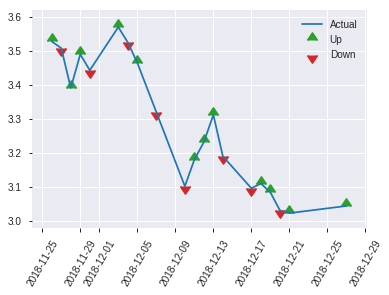


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21526813917320464
RMSE: 0.4639699765859906
LogLoss: 0.6150838085358462
Mean Per-Class Error: 0.3166960531669605
AUC: 0.7392513223925132
pr_auc: 0.6278387128521629
Gini: 0.47850264478502647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27518710494041443: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   100  0.6849   (100.0/146.0)
1      2    99   0.0198   (2.0/101.0)
Total  48   199  0.413    (102.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275187     0.66      198
max f2                       0.264712     0.822368  203
max f0point5                 0.700082     0.623229  62
max accuracy                 0.700082     0.692308  62
max precision                0.898121     1         0
max recall                   0.187095     1         221
max specificity              0.898121     1         0
max absolute_mcc             0.275187     0.366863  198
max min_per_class_accuracy   0.592723     0.657534  116
max mean_per_class_accuracy  0.57709      0.683304  124

Gains/Lift Table: Avg response rate: 40.89 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.882049           1.63036   1.63036            0.666667         0.892574  0.666667                    0.892574            0.019802        0.019802                   63.0363   63.0363
    2        0.0202429                   0.86002            2.44554   1.95644            1                0.867733  0.8                         0.882638            0.019802        0.039604                   144.554   95.6436
    3        0.0323887                   0.847725           2.44554   2.13985            1                0.853663  0.875                       0.871772            0.029703        0.0693069                  144.554   113.985
    4        0.0404858                   0.8367             1.22277   1.95644            0.5              0.840613  0.8                         0.86554             0.00990099      0.0792079                  22.2772   95.6436
    5        0.0526316                   0.832274           0.815182  1.69307            0.333333         0.8359    0.692308                    0.8587              0.00990099      0.0891089                  -18.4818  69.3069
    6        0.101215                    0.773503           1.63036   1.66297            0.666667         0.800695  0.68                        0.830858            0.0792079       0.168317                   63.0363   66.297
    7        0.149798                    0.745807           2.24175   1.85068            0.916667         0.761626  0.756757                    0.808404            0.108911        0.277228                   124.175   85.0682
    8        0.202429                    0.724637           1.50495   1.76079            0.615385         0.735461  0.72                        0.789439            0.0792079       0.356436                   50.495    76.0792
    9        0.299595                    0.674313           1.12087   1.55325            0.458333         0.698295  0.635135                    0.759879            0.108911        0.465347                   12.0875   55.3251
    10       0.40081                     0.626978           1.27168   1.48215            0.52             0.651995  0.606061                    0.732635            0.128713        0.594059                   27.1683   48.2148
    11       0.502024                    0.577671           1.17386   1.41999            0.48             0.600581  0.580645                    0.706011            0.118812        0.712871                   17.3861   41.9994
    12       0.59919                     0.4754             0.917079  1.33844            0.375            0.536412  0.547297                    0.678509            0.0891089       0.80198                    -8.29208  33.844
    13       0.700405                    0.365376           0.684752  1.24398            0.28             0.42622   0.508671                    0.642051            0.0693069       0.871287                   -31.5248  24.3976
    14       0.797571                    0.280011           0.917079  1.20415            0.375            0.319496  0.492386                    0.602755            0.0891089       0.960396                   -8.29208  20.4151
    15       0.898785                    0.186075           0.391287  1.11261            0.16             0.242692  0.454955                    0.562207            0.039604        1                          -60.8713  11.2613
    16       1                           0.0708764          0         1                  0                0.123595  0.408907                    0.517813           

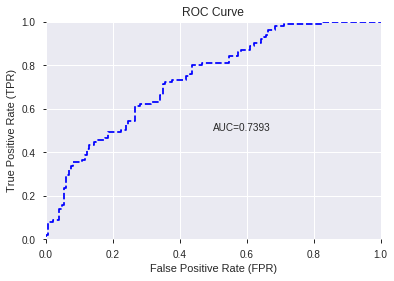

This function is available for GLM models only


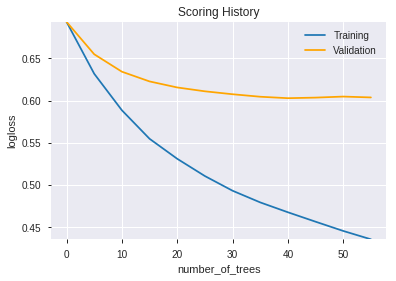

--2019-08-26 14:38:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_143828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_143828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a58e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'CDLSHORTLINE',
 'WILLR_24',
 'PLUS_DM_8',
 'BETA_12',
 'PLUS_DI_8',
 'CORREL_8',
 'MOM_8',
 'STDDEV_8',
 'CORREL_12',
 'ADXR_12',
 'MFI_14',
 'aroonup_14',
 'ROC_12',
 'HT_PHASOR_quadrature',
 'DX_8',
 'STOCHRSI_fastk',
 'MOM_12',
 'CCI_30',
 'ULTOSC',
 'BBANDS_middleband_20_7_2',
 'PLUS_DM_30',
 'WILLR_20',
 'RSI_12',
 'DX_24',
 'ROCP_24',
 'MACDFIX_signal_24',
 'aroonup_8',
 'STOCH_slowd',
 'WILLR_30',
 'PLUS_DI_14',
 'MINUS_DM_30',
 'ROCP_20',
 'CCI_24',
 'MACDFIX_signal_8',
 'DX_14',
 'MOM_20',
 'ROCR_30',
 'MOM_14',
 'STOCH_slowk',
 'CCI_12',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'CDLLONGLINE',
 'DX_12',
 'MACDEXT_hist',
 'ROCR_14',
 'CCI_8',
 'CDLTAKURI',
 'MACDFIX_14',
 'APO',
 'MINUS_DI_12',
 'AROONOSC_30',
 'BBANDS_lowerband_20_5_2',
 'CMO_8',
 'ADXR_8',
 'BBANDS_upperband_20_1_4',
 'aroonup_30',
 'MINUS_DI_14',
 'aroondown_8',
 'BBANDS_upperband_14_7_3',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'MFI_8',
 'ROCP_12',
 'HT_DCPERIOD',
 'PLUS_D

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.717
GLM             0.700
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.696  0.688    0.692
DLF          0.688  0.688    0.713
Fwe          0.704  0.700    0.692
RFE          0.717  0.672    0.692
XGBF         0.704  0.688    0.713





F1


DeepLearning    0.672
GLM             0.667
XGBoost         0.669
dtype: float64

DeepLearning    GLM  XGBoost
All          0.647  0.660    0.669
DLF          0.667  0.662    0.662
Fwe          0.672  0.667    0.662
RFE          0.664  0.660    0.660
XGBF         0.664  0.662    0.662





auc


DeepLearning    0.756
GLM             0.741
XGBoost         0.745
dtype: float64

DeepLearning    GLM  XGBoost
All          0.733  0.720    0.743
DLF          0.737  0.727    0.745
Fwe          0.756  0.741    0.739
RFE          0.732  0.707    0.739
XGBF         0.749  0.727    0.745





logloss


DeepLearning    0.664
GLM             0.653
XGBoost         0.620
dtype: float64

DeepLearning    GLM  XGBoost
All          0.623  0.653    0.607
DLF          0.650  0.607    0.620
Fwe          0.664  0.608    0.603
RFE          0.600  0.647    0.615
XGBF         0.601  0.607    0.620





mean_per_class_error


DeepLearning    0.326
GLM             0.335
XGBoost         0.317
dtype: float64

DeepLearning    GLM  XGBoost
All          0.322  0.325    0.314
DLF          0.311  0.332    0.311
Fwe          0.308  0.311    0.311
RFE          0.326  0.335    0.317
XGBF         0.316  0.332    0.311





rmse


DeepLearning    0.477
GLM             0.474
XGBoost         0.467
dtype: float64

DeepLearning    GLM  XGBoost
All          0.465  0.469    0.462
DLF          0.477  0.459    0.467
Fwe          0.477  0.458    0.458
RFE          0.453  0.474    0.464
XGBF         0.459  0.459    0.467





mse


DeepLearning    0.228
GLM             0.225
XGBoost         0.218
dtype: float64

DeepLearning    GLM  XGBoost
All          0.216  0.220    0.213
DLF          0.228  0.210    0.218
Fwe          0.228  0.210    0.209
RFE          0.205  0.225    0.215
XGBF         0.210  0.210    0.218

{'F1':       DeepLearning    GLM  XGBoost
 All          0.647    NaN      NaN
 DLF          0.667    NaN      NaN
 DLF            NaN  0.662      NaN
 DLF            NaN    NaN    0.662
 All            NaN  0.660      NaN
 All            NaN    NaN    0.669
 XGBF         0.664    NaN      NaN
 XGBF           NaN  0.662      NaN
 XGBF           NaN    NaN    0.662
 Fwe          0.672    NaN      NaN
 Fwe            NaN  0.667      NaN
 Fwe            NaN    NaN    0.662
 RFE          0.664    NaN      NaN
 RFE            NaN  0.660      NaN
 RFE            NaN    NaN    0.660,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.696    NaN      NaN
 DLF          0.688    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.688      NaN
 All            NaN    NaN    0.692
 XGBF         0.704    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.704    NaN      NaN
 Fwe     